In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_biketrips = pd.read_csv('biketrips2011.csv')
df_biketrips['StartTime'] = df_biketrips['StartTime'].astype('datetime64')
df_biketrips['EndTime'] = df_biketrips['EndTime'].astype('datetime64')
df_biketrips['StartNum'] = df_biketrips['StartNum'].astype(int)
df_biketrips['EndNum'] = df_biketrips['EndNum'].astype(int)

In [3]:
list_holidays = pd.read_csv('days_holidays.csv')['datetime'].values.tolist()
list_workdays = pd.read_csv('days_workingdays.csv')['datetime'].values.tolist()

In [4]:
# new features - to help group by hour
df_dhcombo_out = pd.DataFrame({
    'Day': df_biketrips['StartTime'].dt.date,
    'Hour': df_biketrips['StartTime'].dt.hour,
})

df_dhcombo_in = pd.DataFrame({
    'Day': df_biketrips['EndTime'].dt.date,
    'Hour': df_biketrips['EndTime'].dt.hour,
})

df_biketrips['StartHour'] = pd.to_datetime(df_dhcombo_out.Day) + pd.to_timedelta(df_dhcombo_out.Hour, unit='h')
df_biketrips['EndHour'] = pd.to_datetime(df_dhcombo_in.Day) + pd.to_timedelta(df_dhcombo_in.Hour, unit='h')

In [5]:
df_hourly_start = df_biketrips.pivot_table(values='count',index='StartHour',columns='StartNum',aggfunc='sum',fill_value=None)
df_hourly_end = df_biketrips.pivot_table(values='count',index='EndHour',columns='EndNum',aggfunc='sum',fill_value=None)

In [6]:
df_hourly_start['hourofday'] = df_hourly_start.index.hour
df_hourly_start['dayofweek'] = df_hourly_start.index.dayofweek
df_hourly_start['workday'] = df_hourly_start.index.isin(list_workdays)

df_hourly_end['hourofday'] = df_hourly_end.index.hour
df_hourly_end['dayofweek'] = df_hourly_end.index.dayofweek
df_hourly_end['workday'] = df_hourly_end.index.isin(list_workdays)

In [7]:
# take off last 3 columns (added features above)
sites = df_hourly_start.columns[0:len(df_hourly_start.columns)-3]

In [8]:
df_hourly_start['sum_all'] = df_hourly_start[sites].sum(axis=1)
df_hourly_end['sum_all'] = df_hourly_end[sites].sum(axis=1)

#NEW CODE starts here
df_hourly_start['weekofyear'] = df_hourly_start.index.weekofyear
df_hourly_end['weekofyear'] = df_hourly_end.index.weekofyear


In [9]:
sample_sites = [31103,31200]
#sample_sites = [31007,31100,31103,31200,31215]

31103


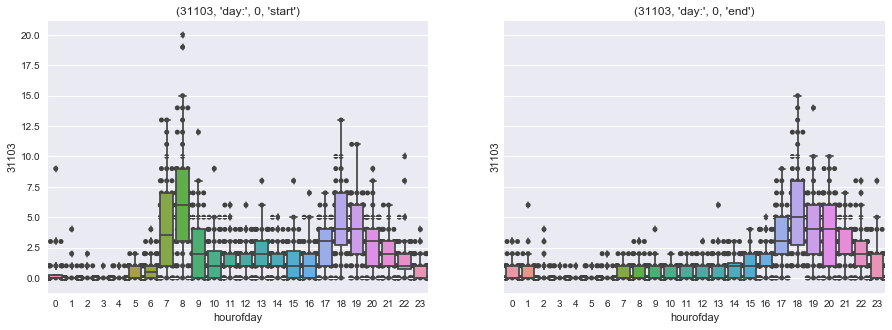

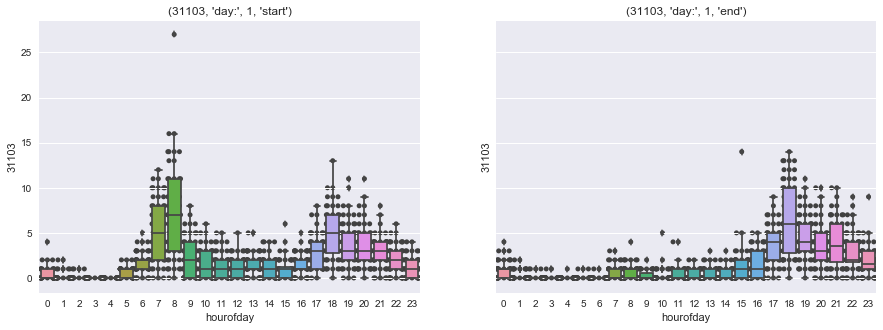

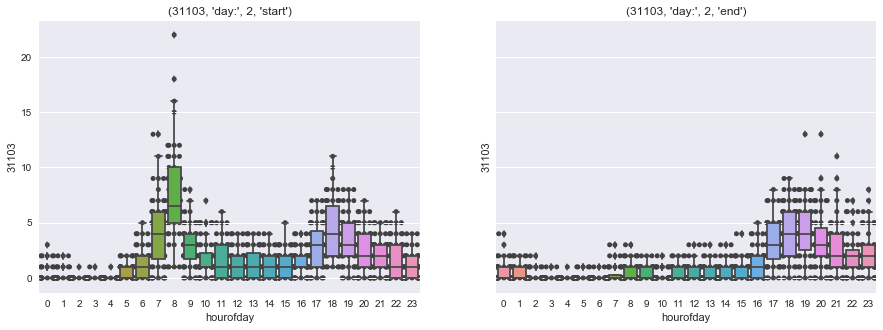

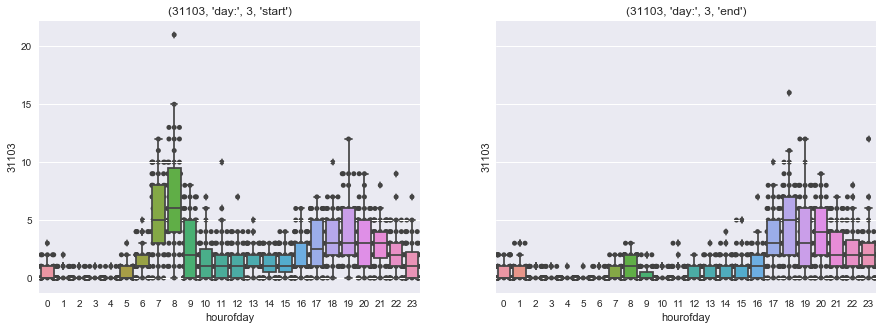

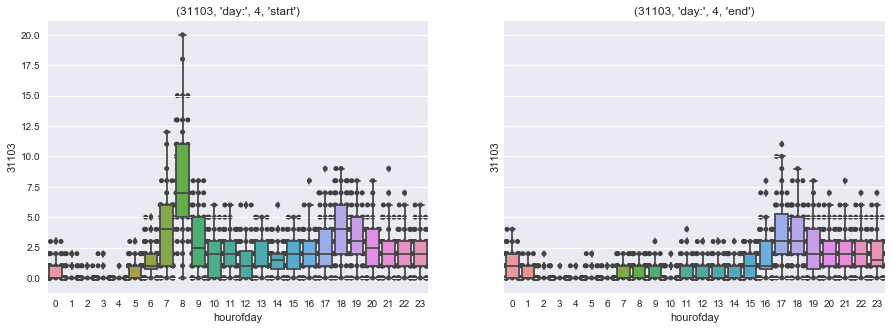

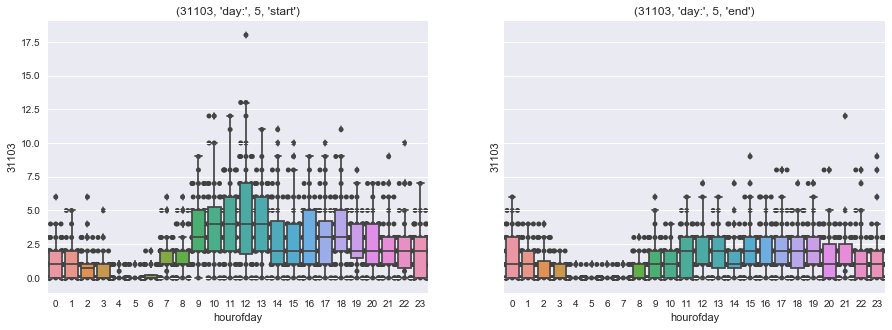

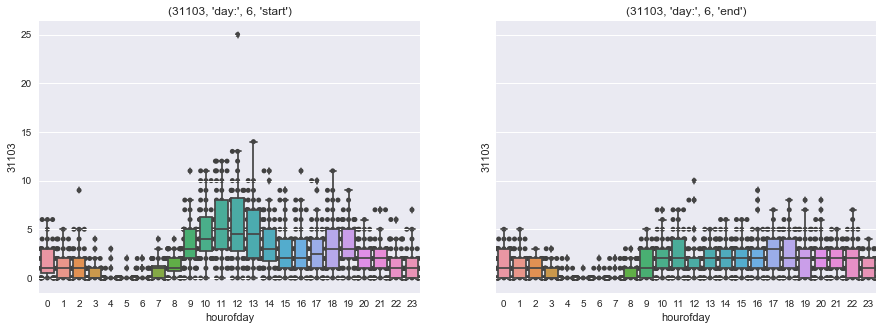

31200


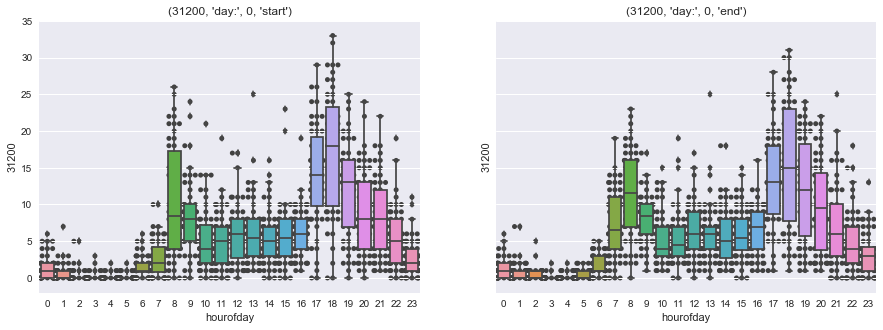

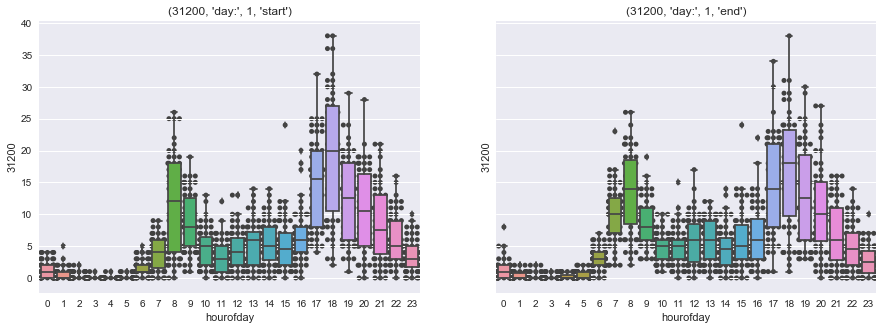

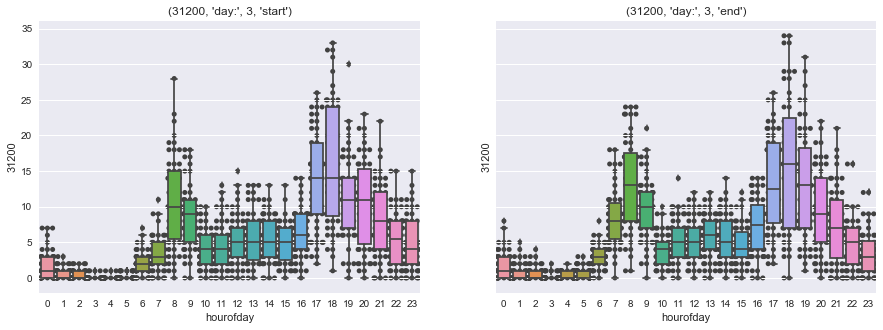

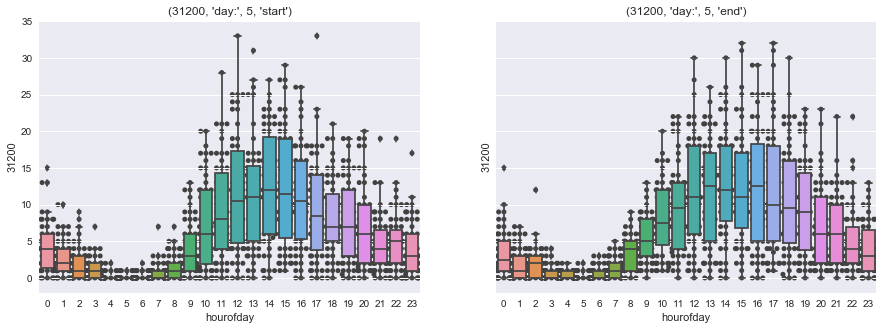

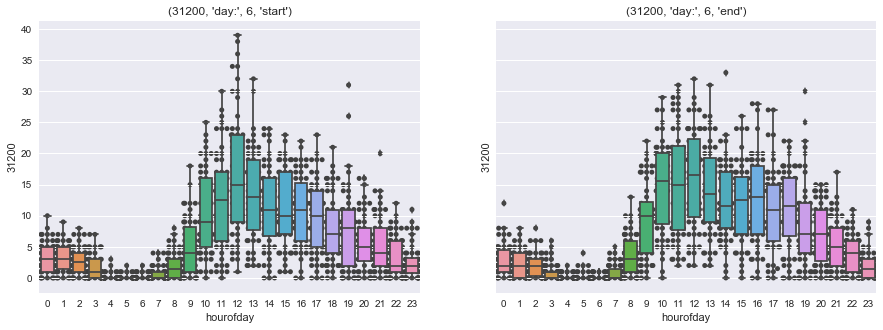

In [10]:
# boxplots per site/day of week
flierprops = dict(marker='o', markerfacecolor='blue', markersize=5,
                  linestyle='none')

for site in sample_sites: 
    group_site_start_day = df_hourly_start[[site,'hourofday','dayofweek','weekofyear']].fillna(0).groupby('dayofweek')
    group_site_end_day = df_hourly_end[[site,'hourofday','dayofweek','weekofyear']].fillna(0).groupby('dayofweek')
    print(site)
    for idx,group in group_site_start_day:
        group_end = group_site_end_day.get_group(idx)
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))

        df_start_site_day = group.pivot_table(values=site,index=['weekofyear','hourofday'],fill_value=0).reset_index()
        df_end_site_day = group_end.pivot_table(values=site,index=['weekofyear','hourofday'],fill_value=0).reset_index()
        
        sns.swarmplot(x='hourofday',y=site,data=df_start_site_day,color=".25",zorder=0.5,ax=ax1)
        sns.boxplot(x='hourofday',y=site,data=df_start_site_day,ax=ax1)
        ax1.set_title((site,'day:',idx,'start'))
        
        sns.swarmplot(x='hourofday',y=site,data=df_end_site_day,color=".25",zorder=0.5,ax=ax2)
        sns.boxplot(x='hourofday',y=site,data=df_end_site_day,ax=ax2)
        ax2.set_title((site,'day:',idx,'end'))
        plt.show()


31103


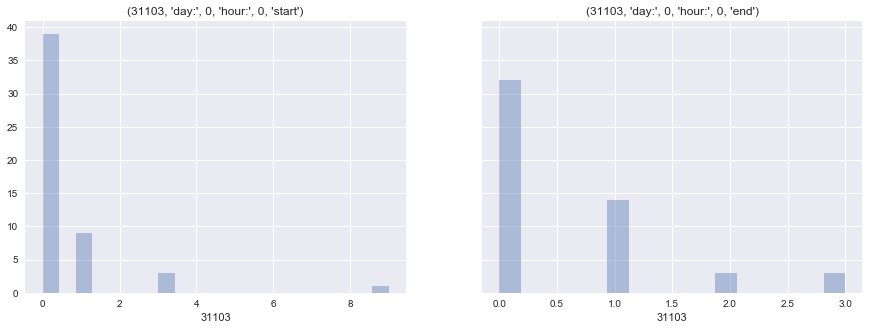

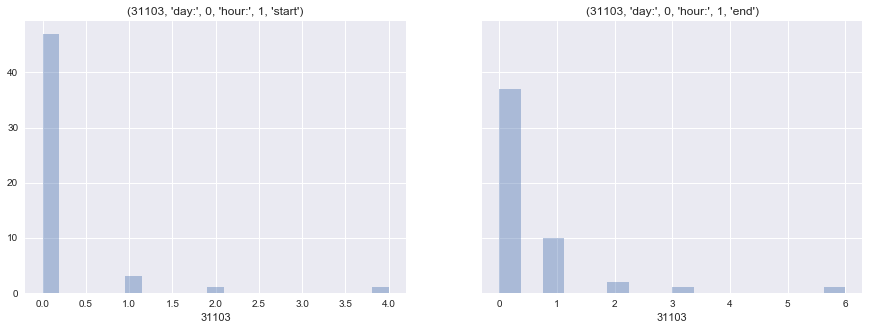

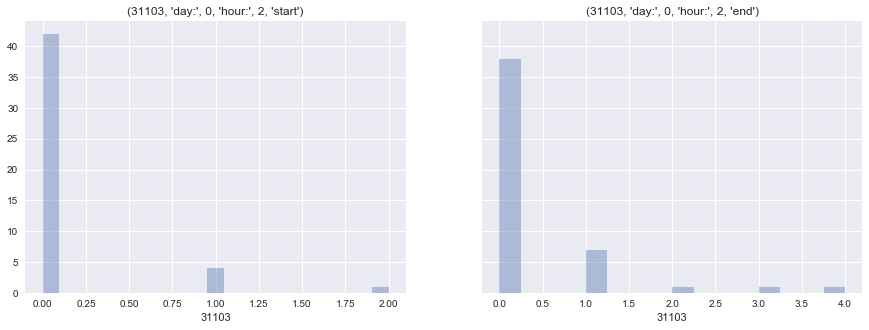

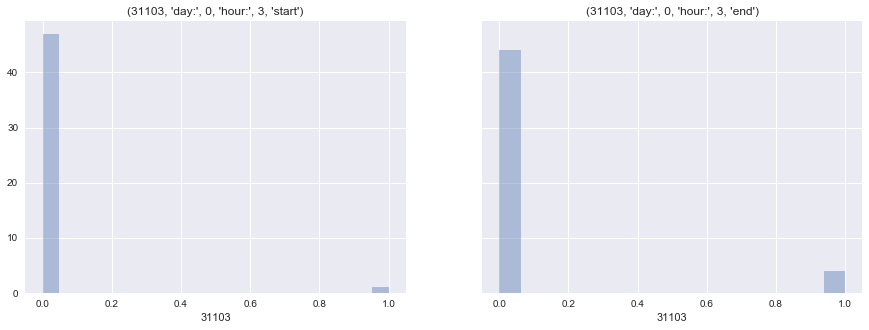

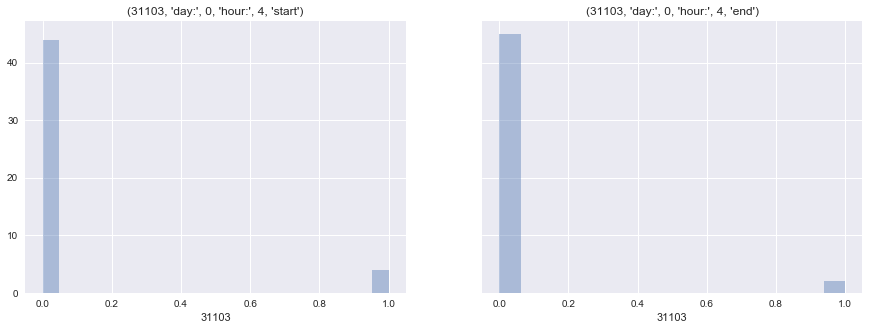

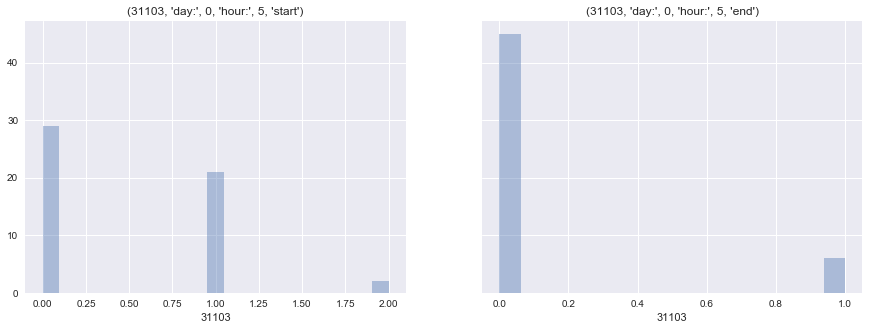

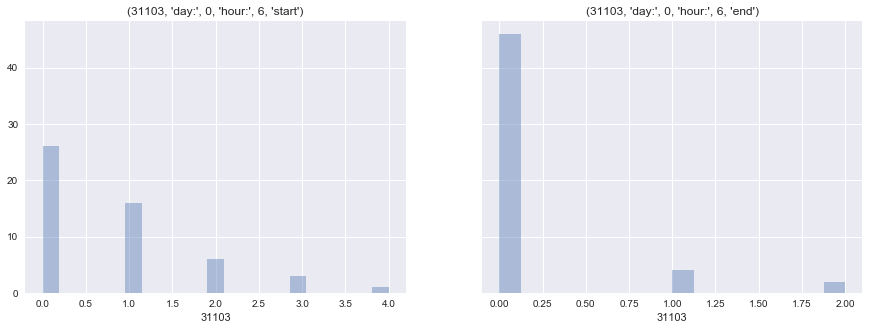

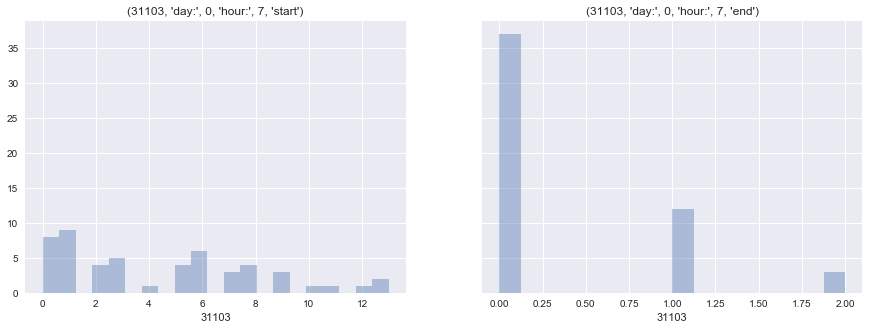

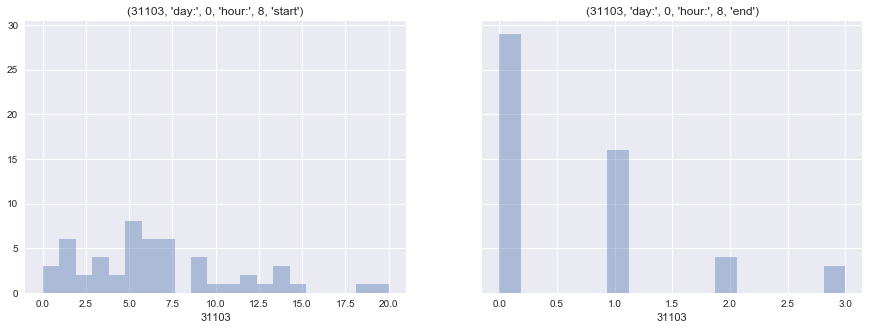

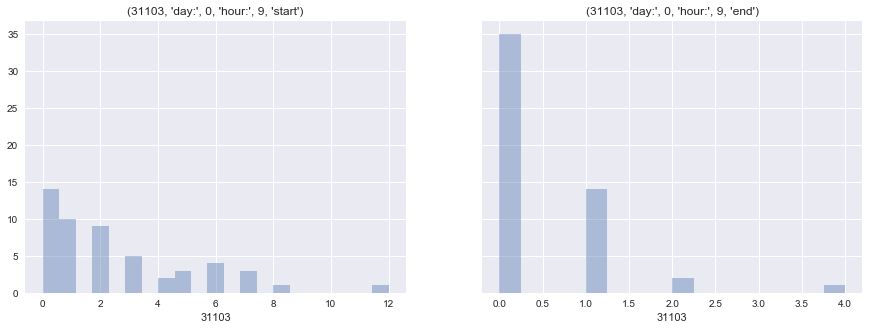

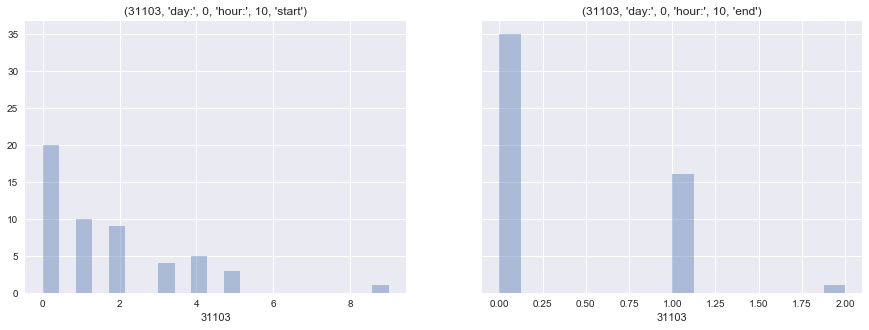

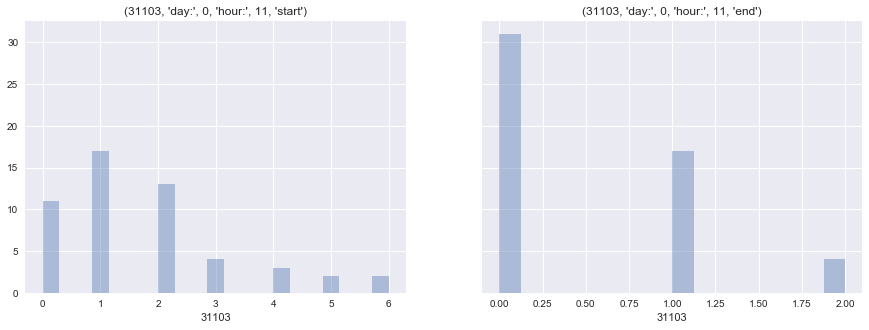

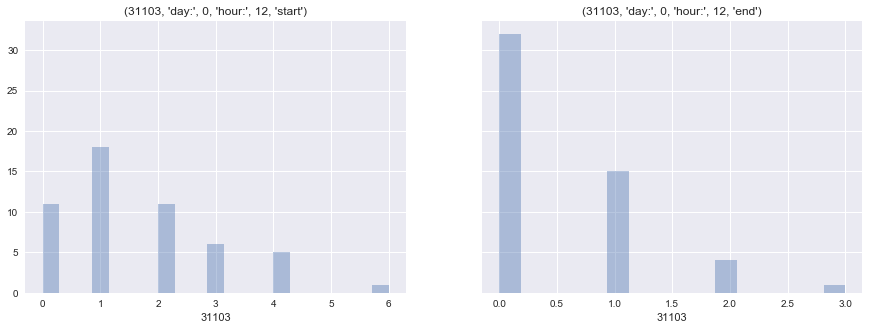

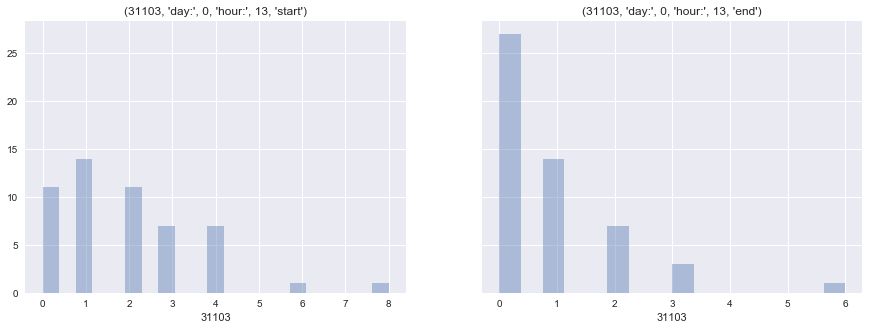

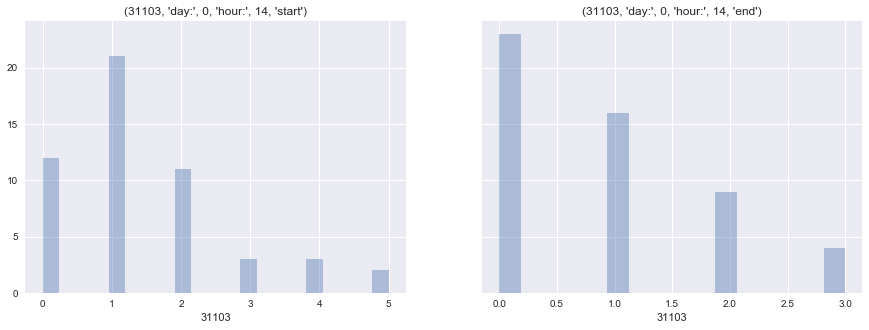

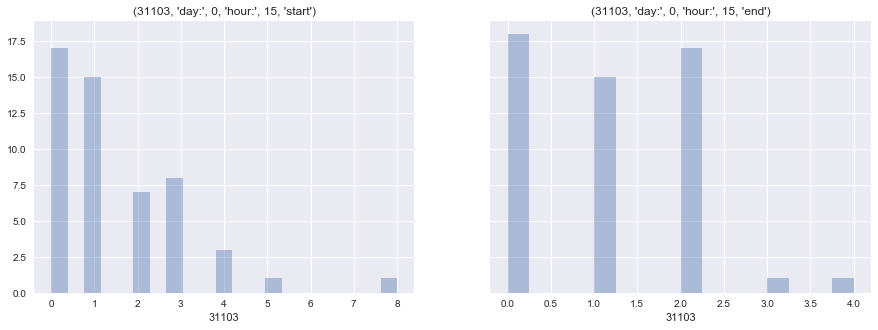

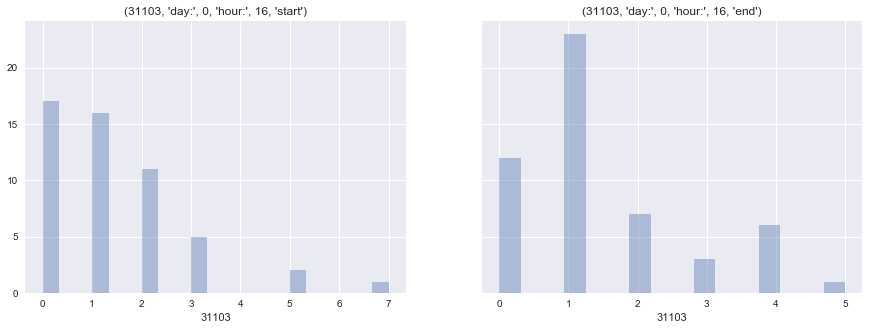

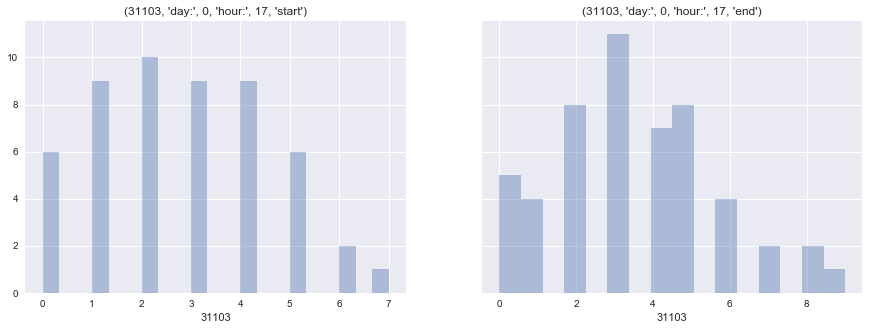

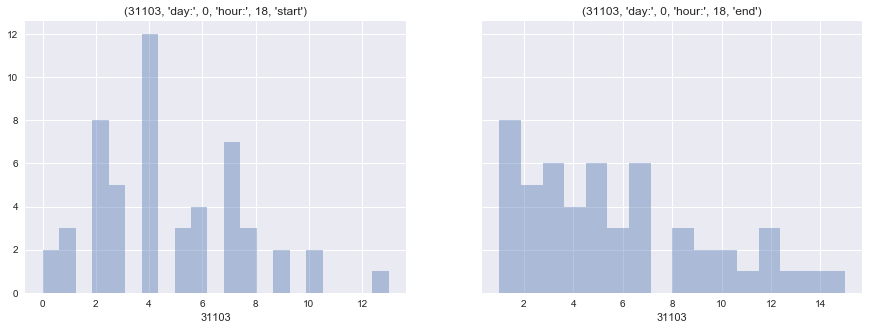

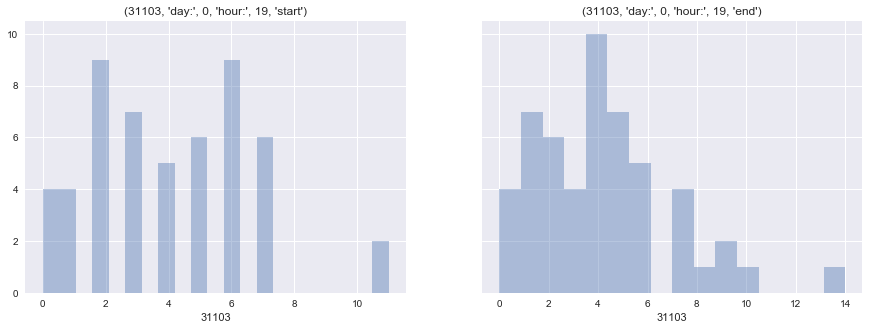

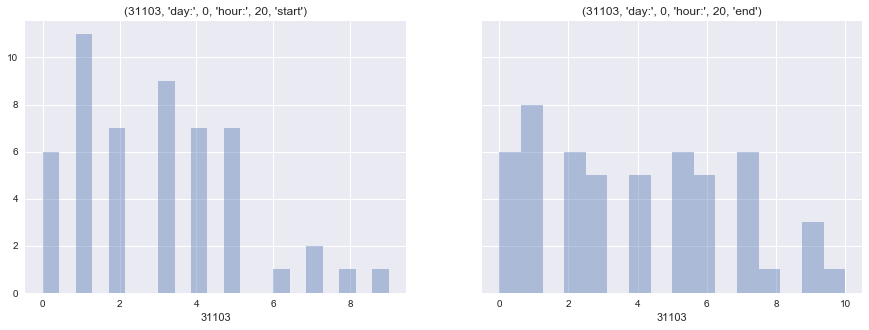

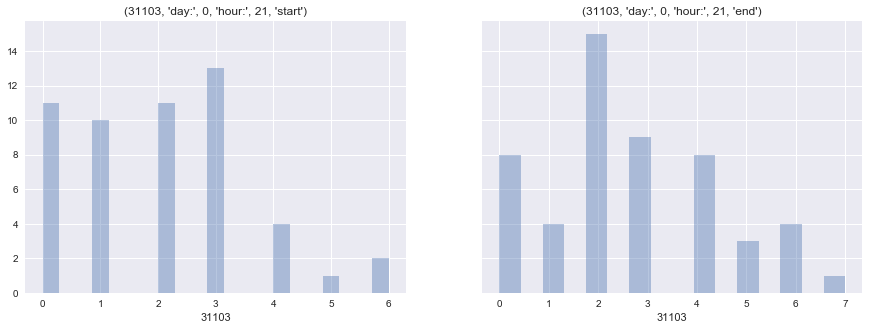

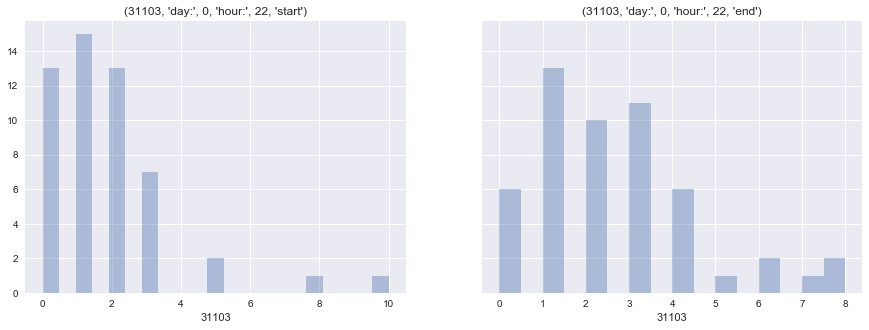

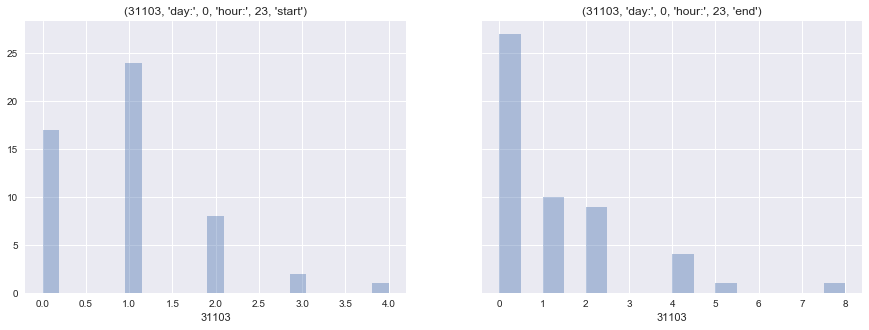

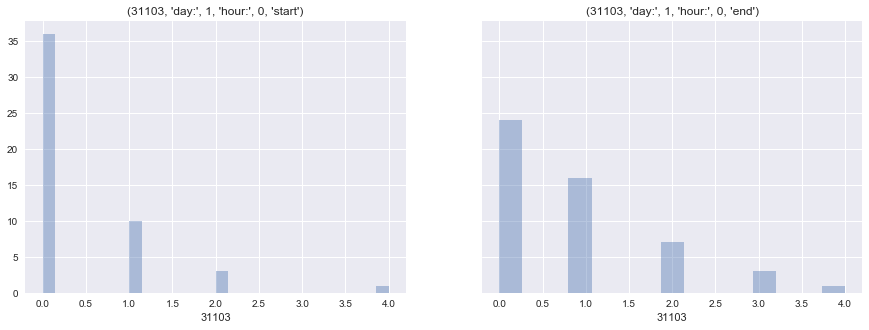

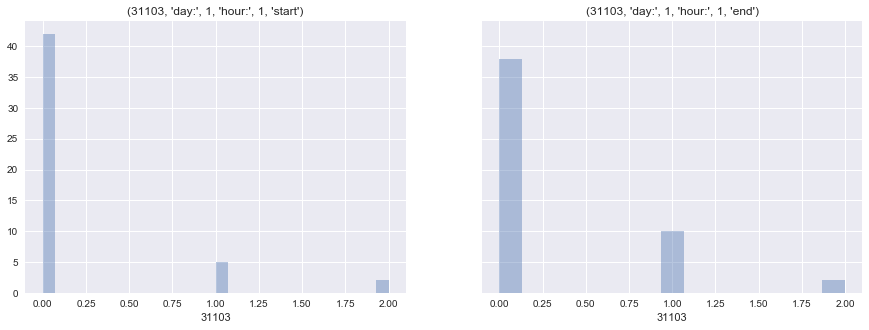

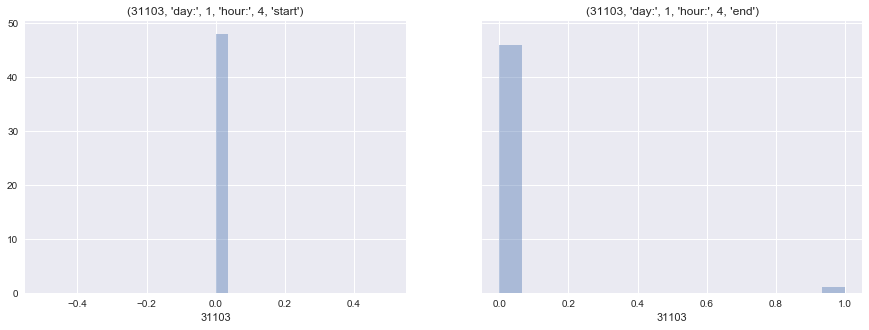

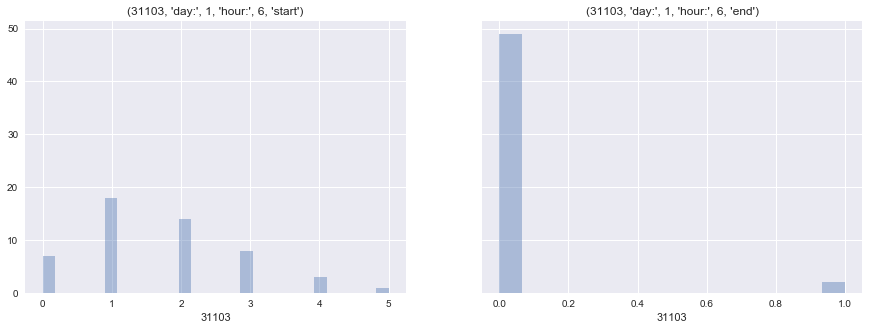

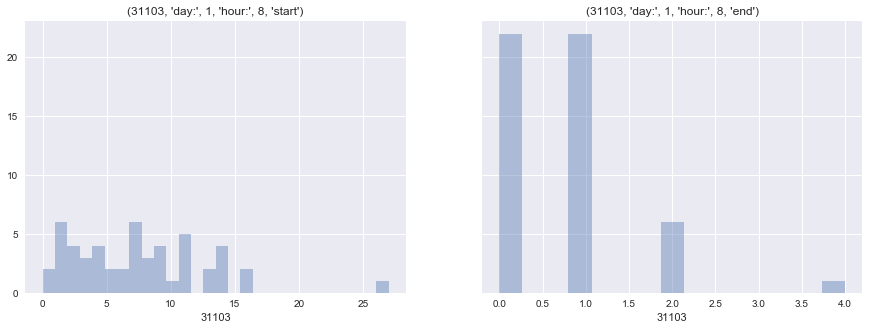

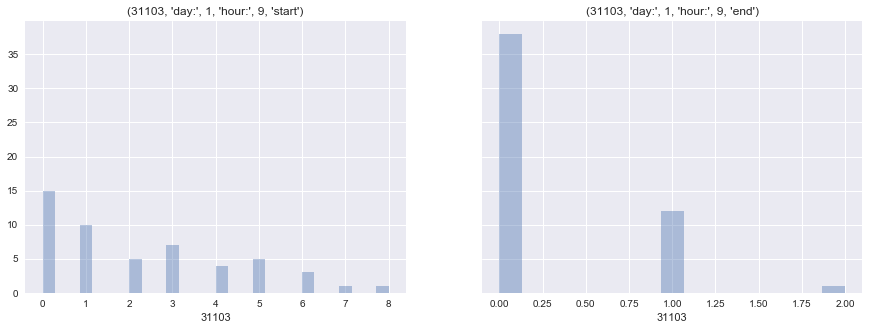

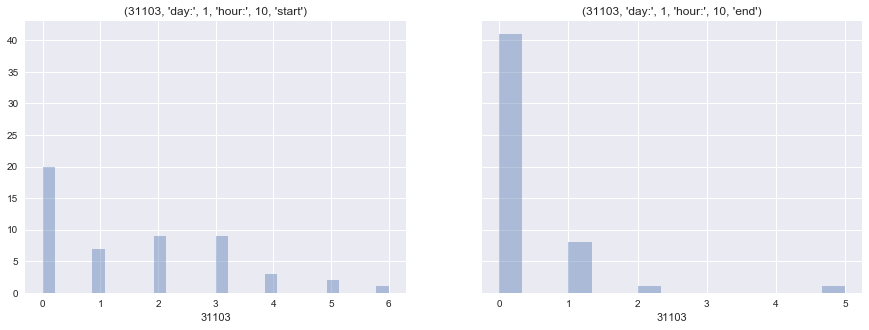

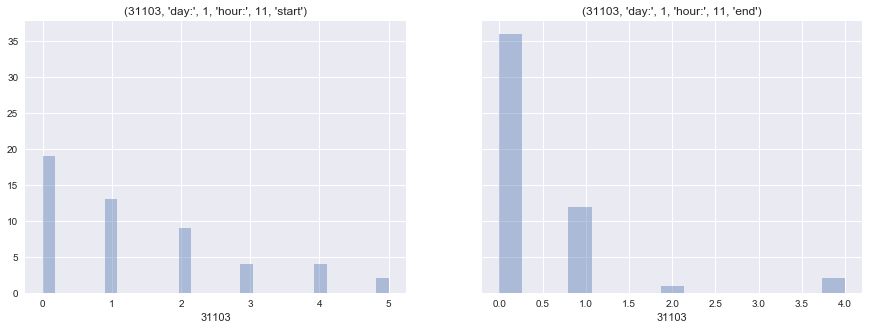

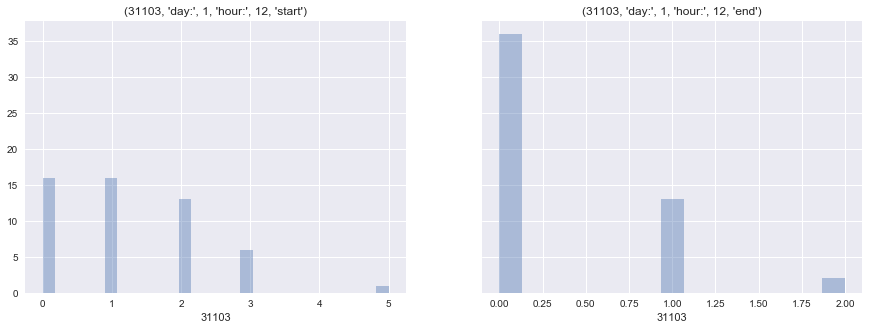

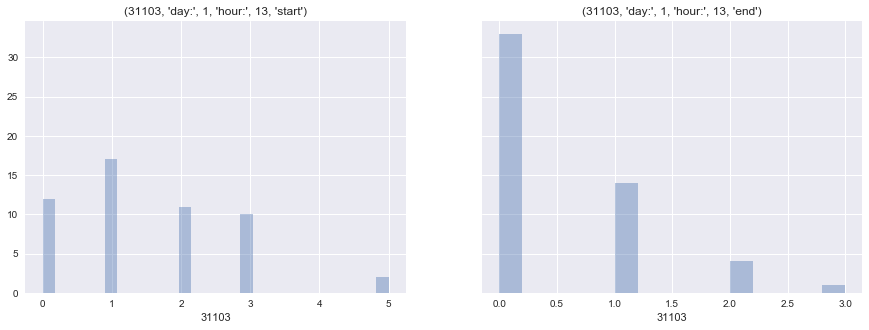

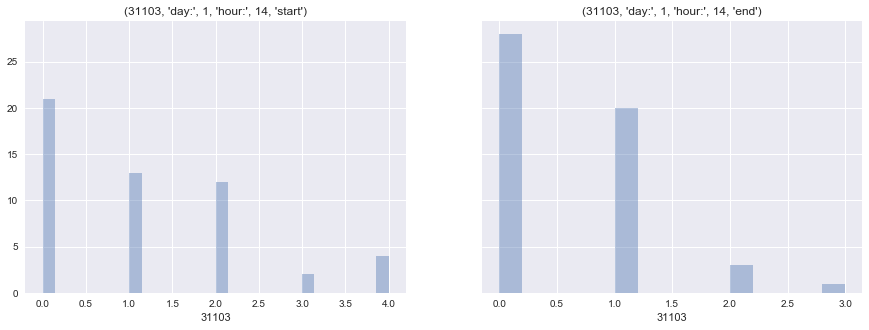

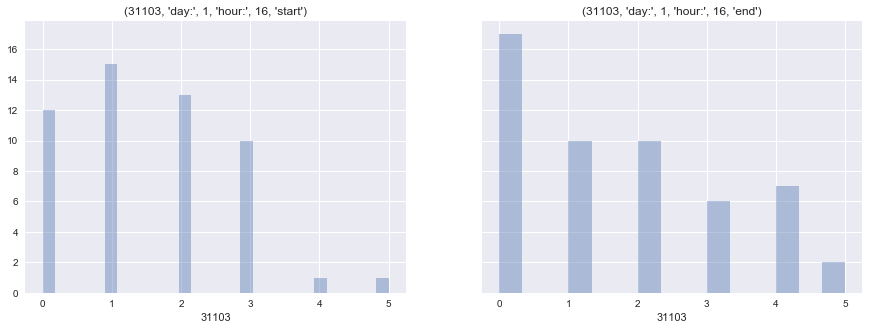

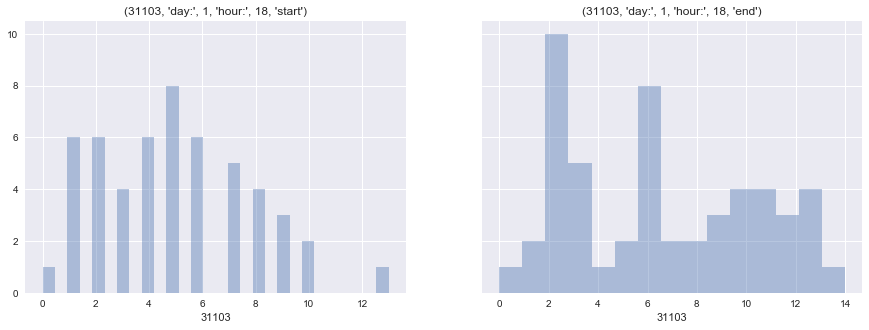

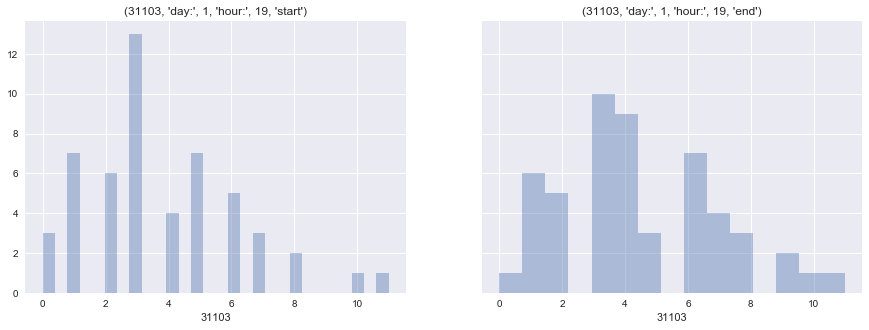

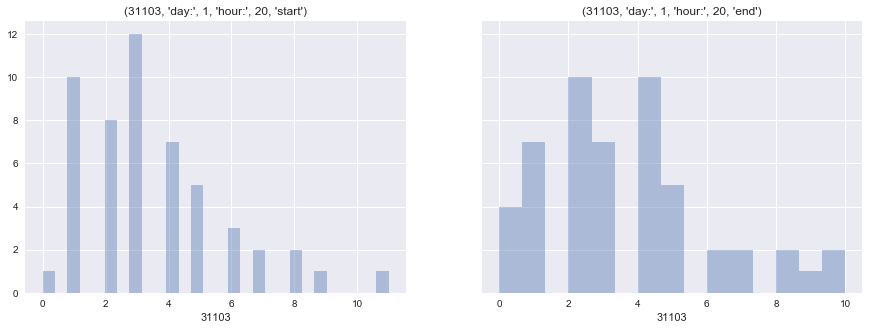

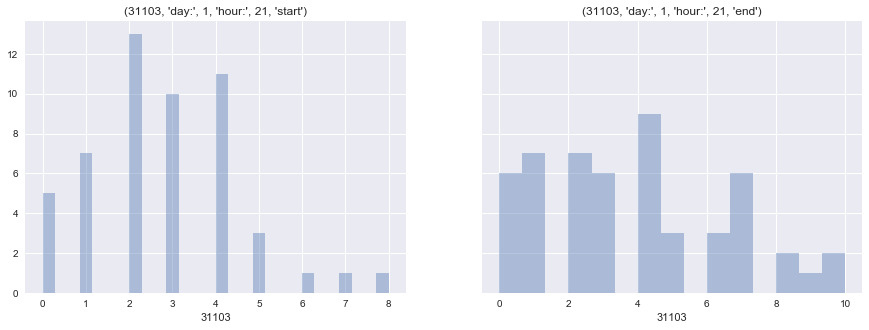

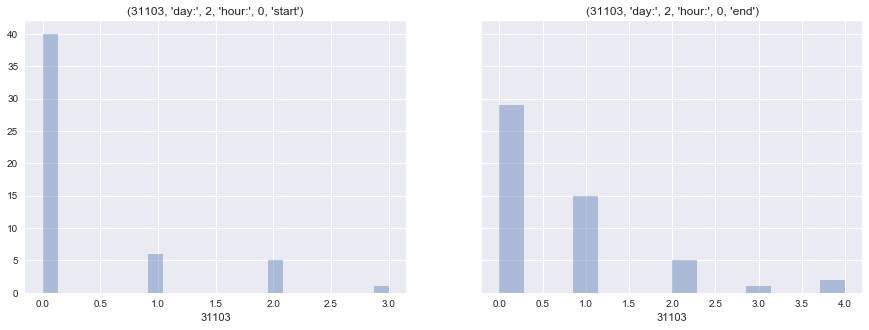

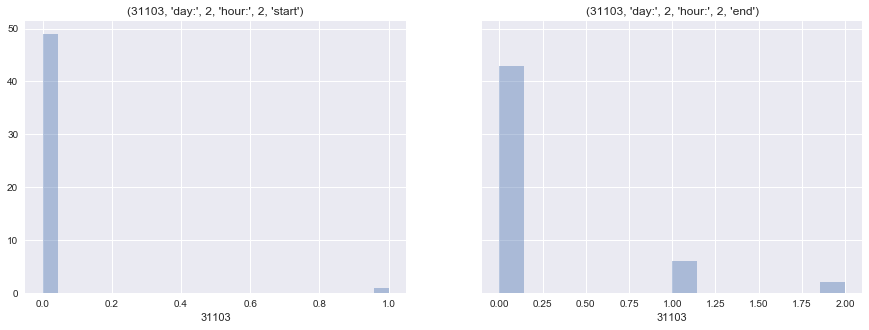

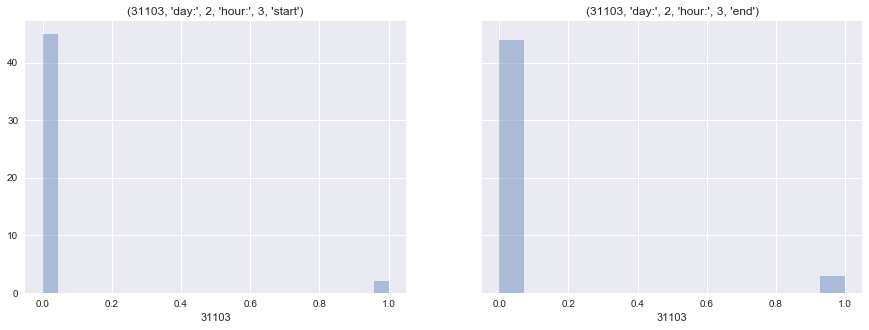

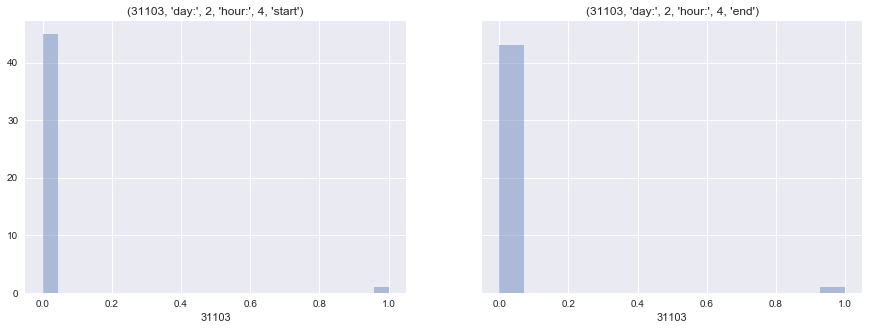

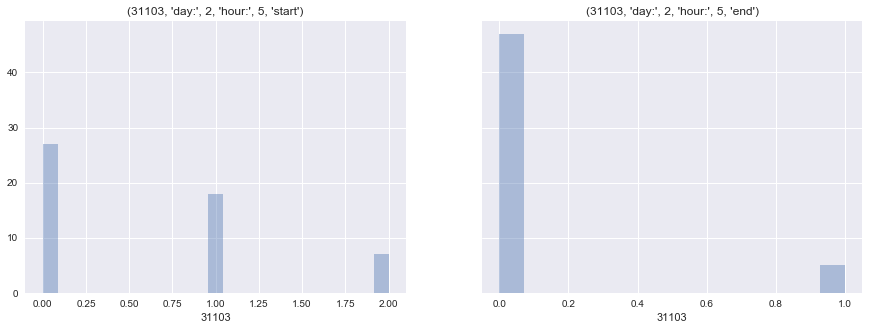

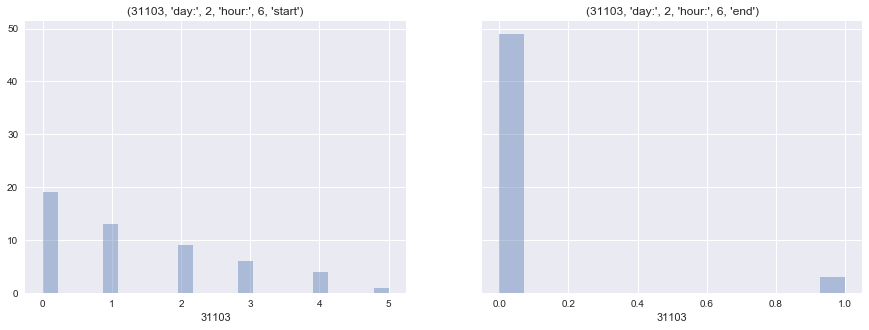

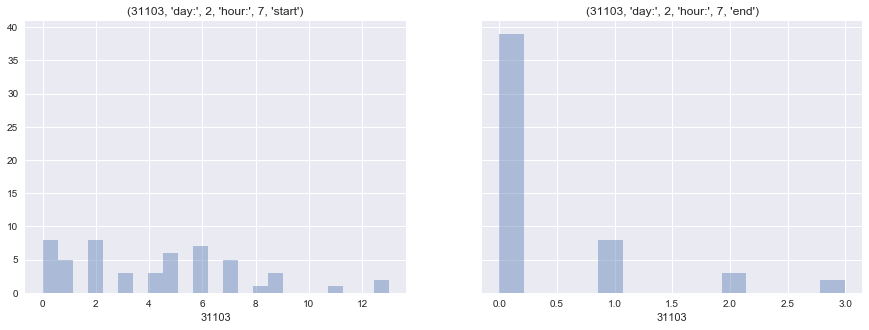

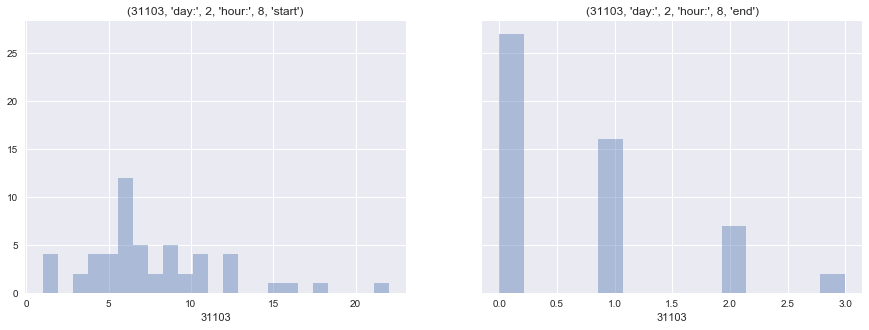

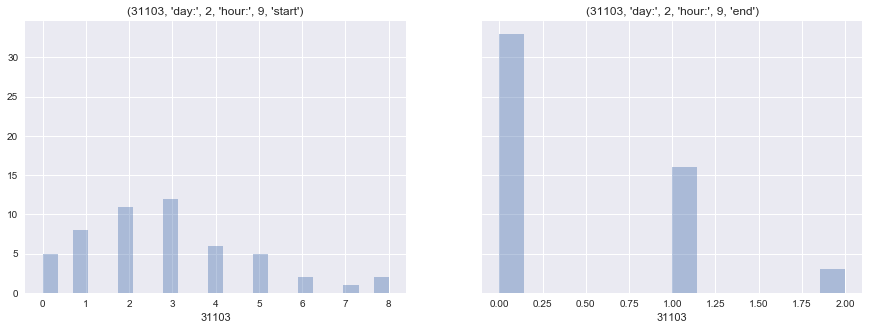

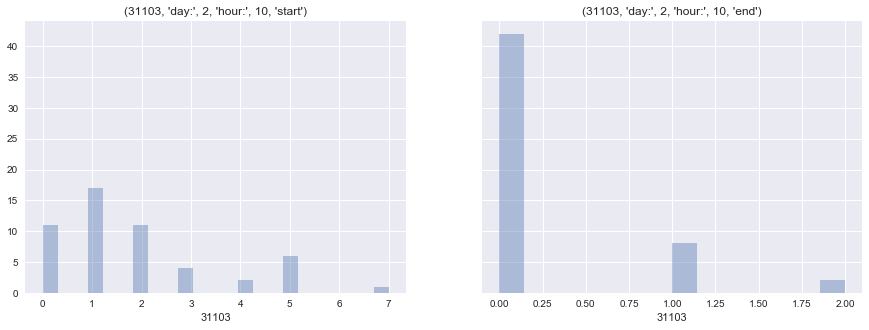

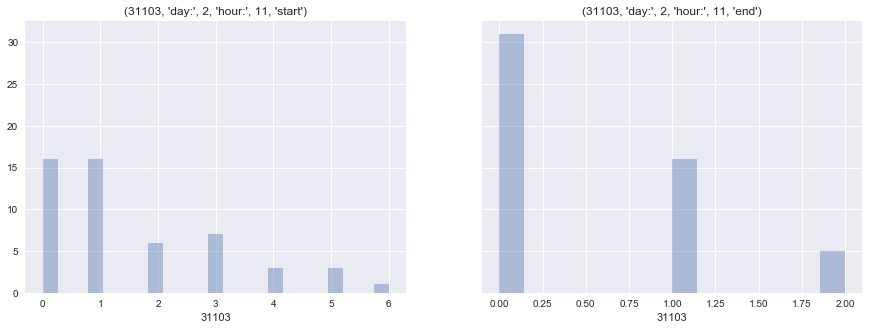

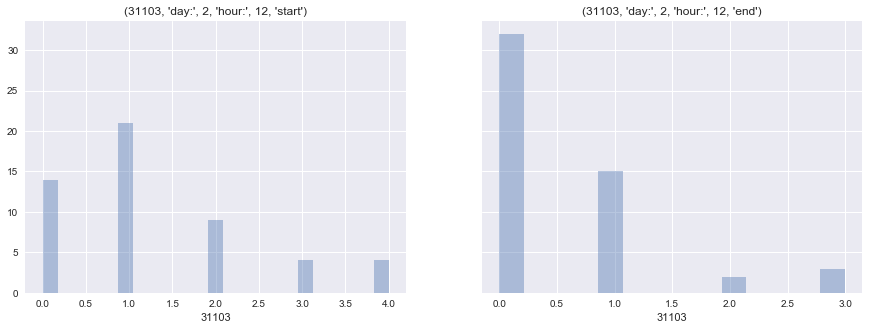

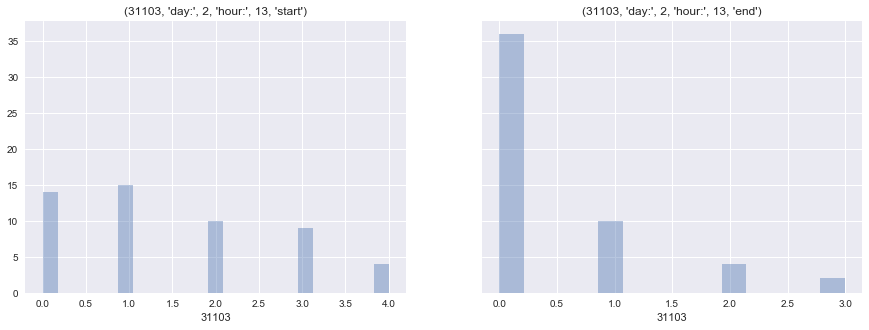

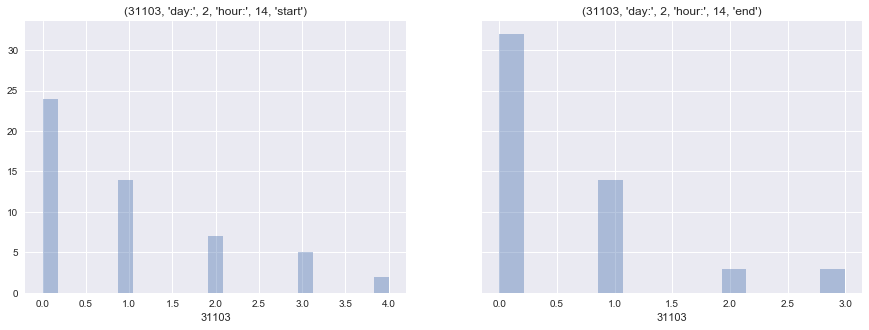

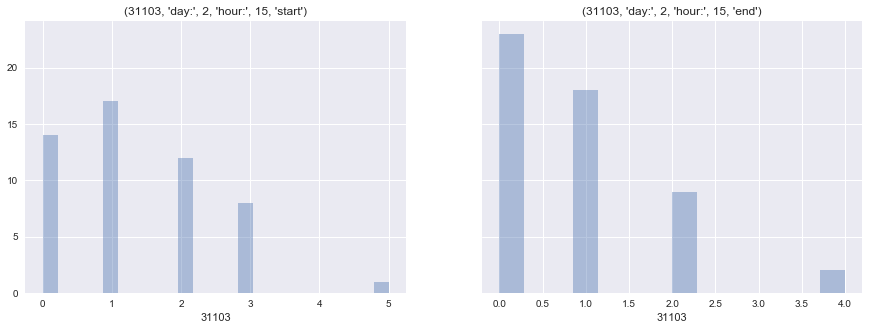

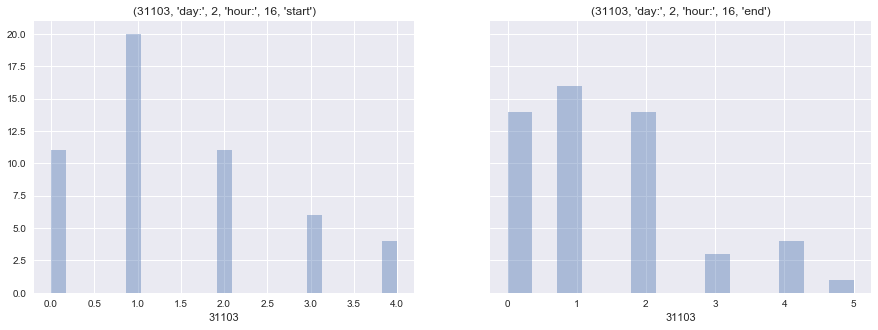

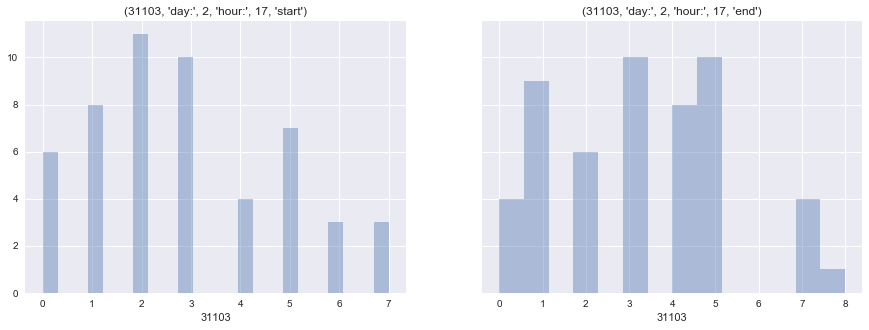

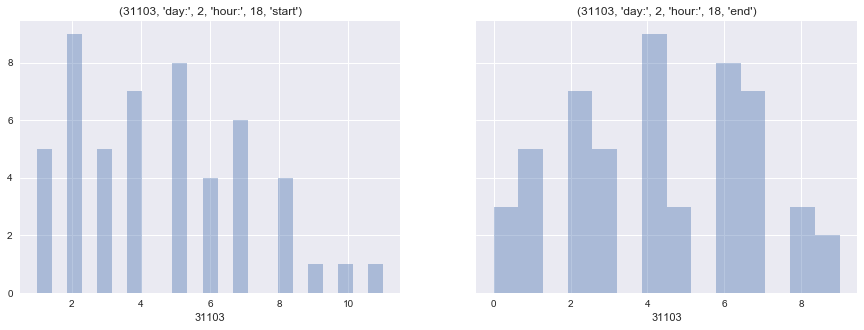

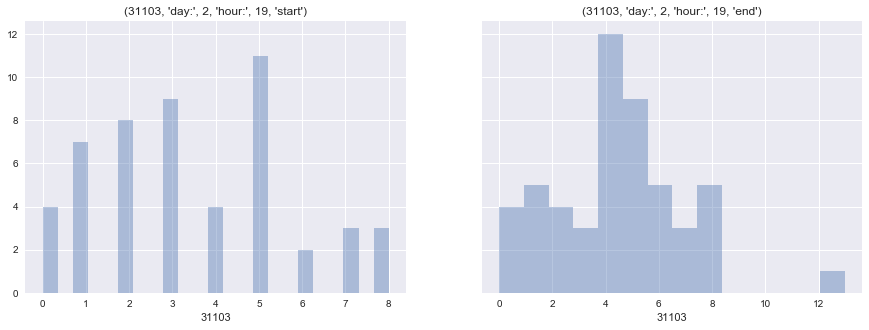

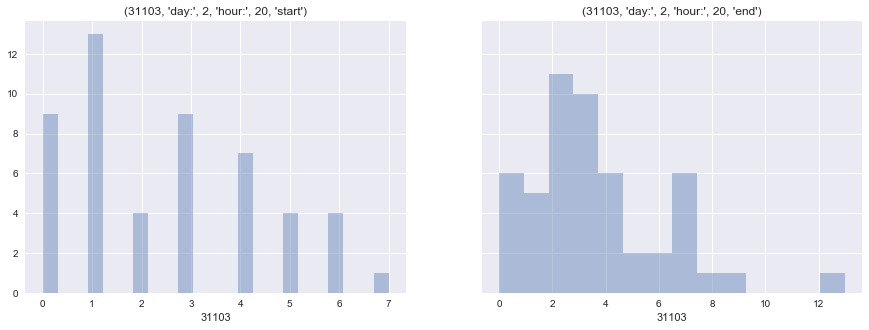

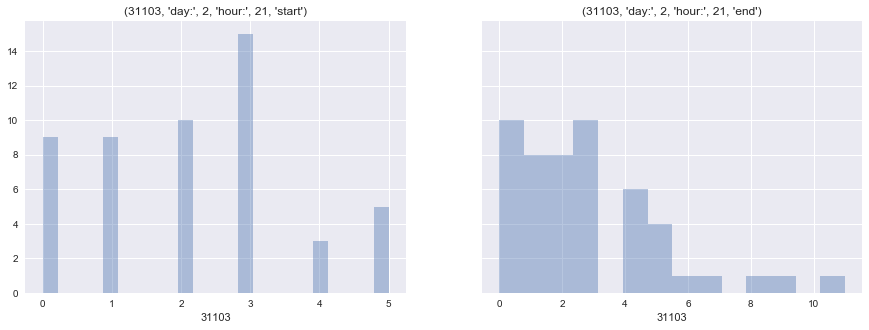

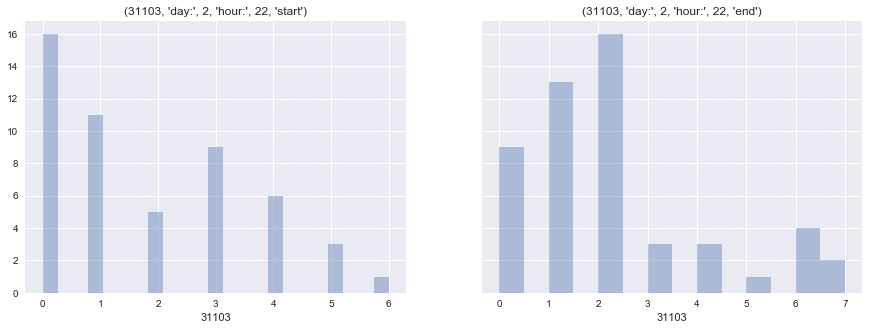

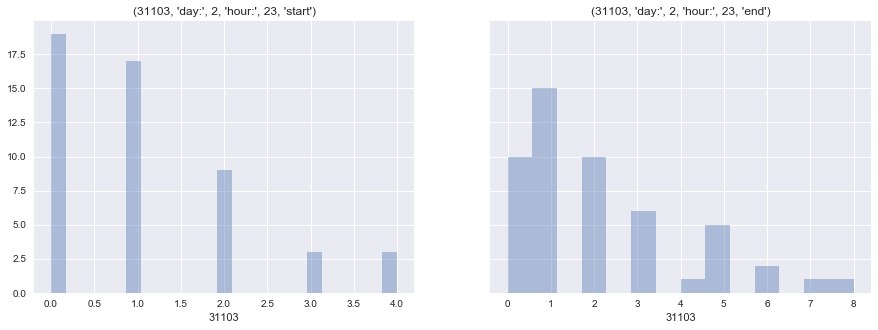

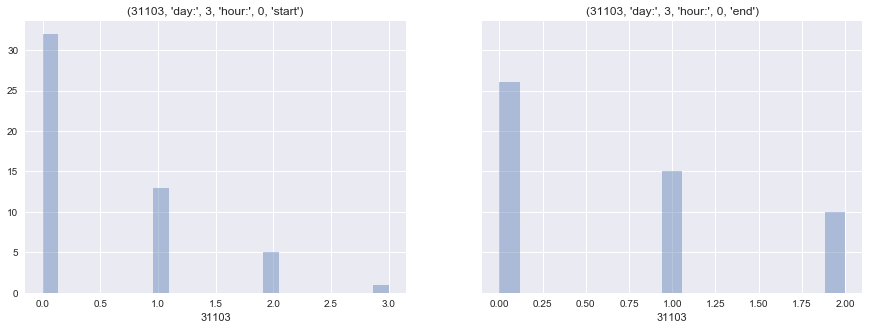

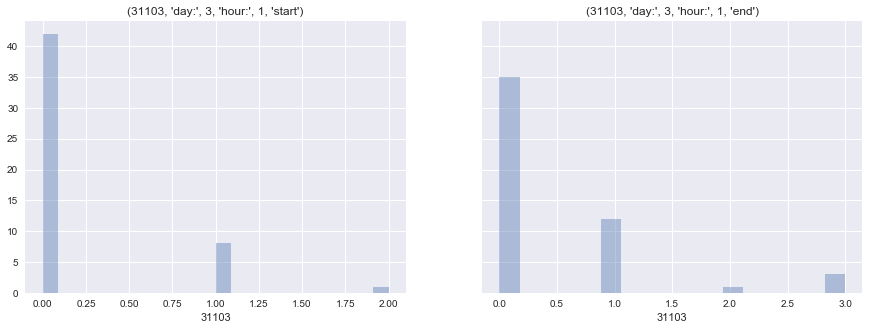

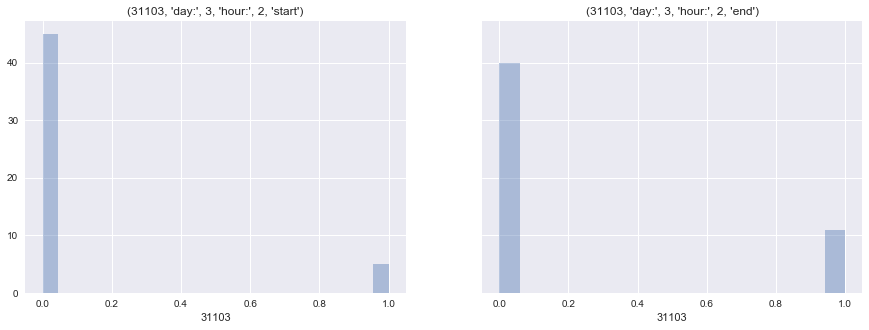

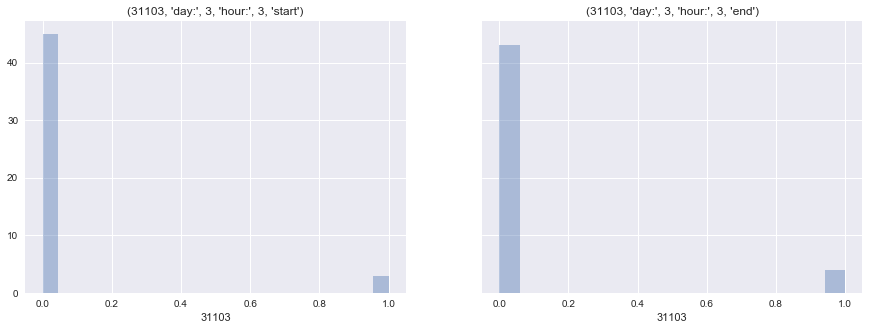

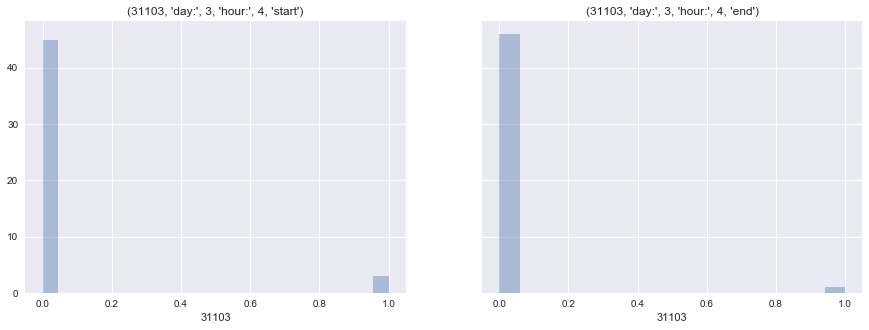

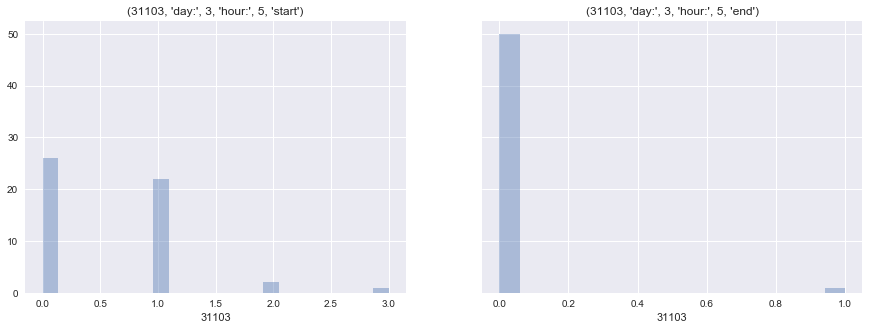

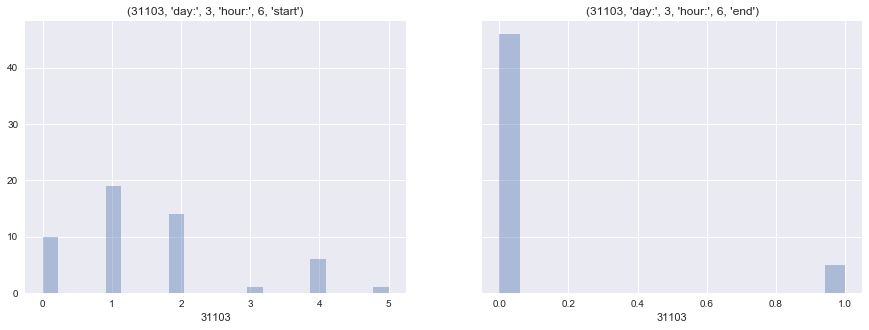

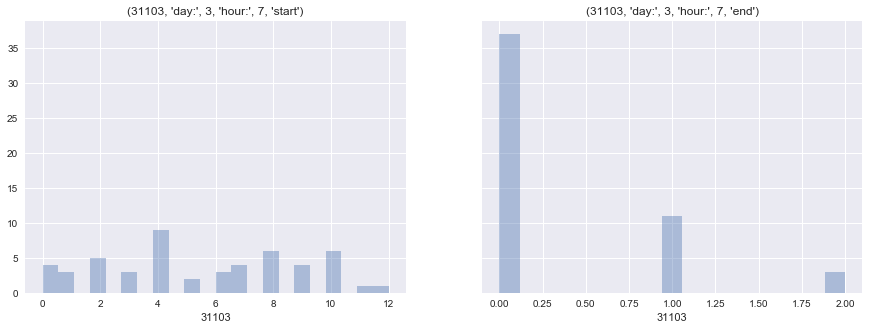

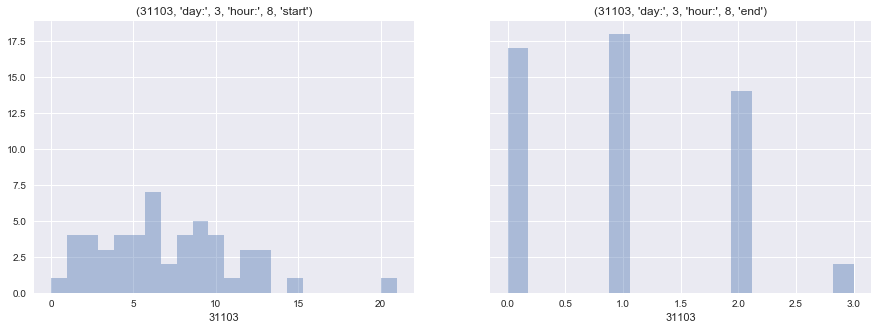

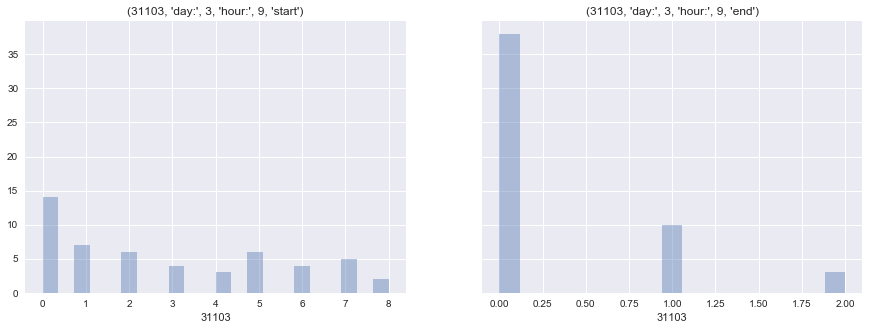

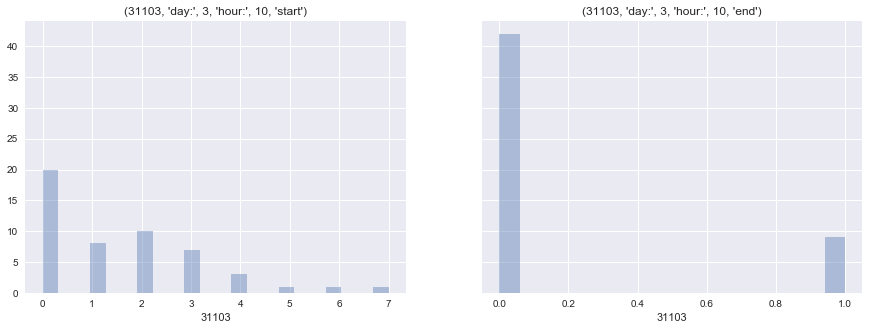

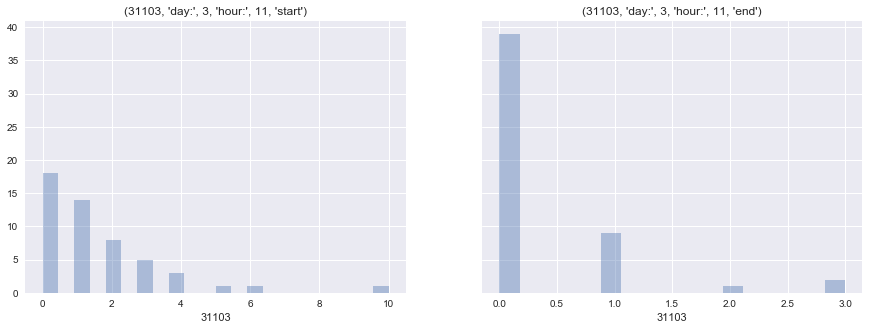

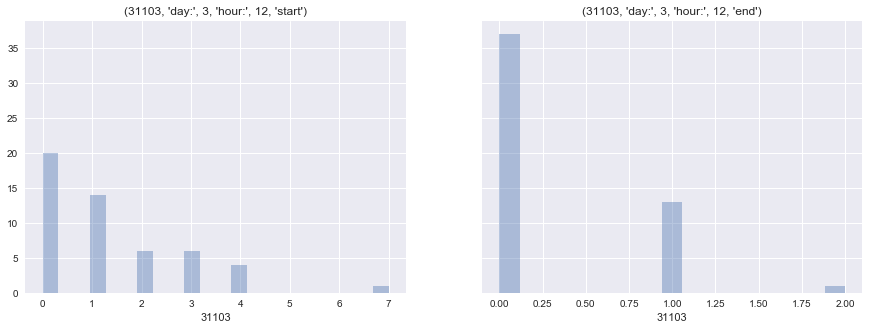

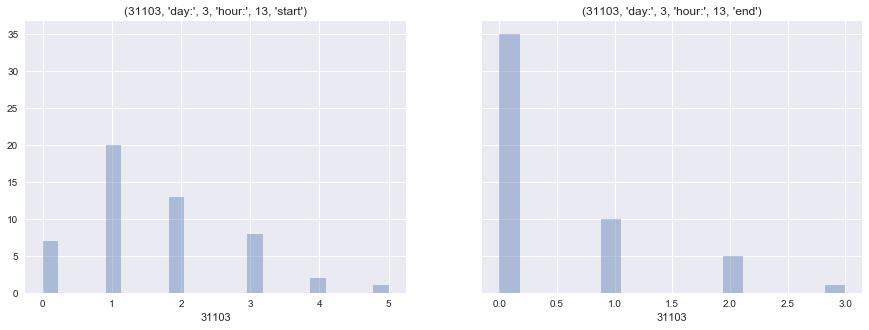

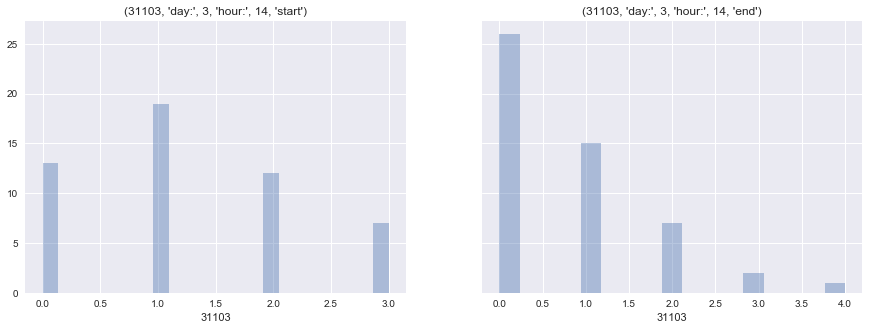

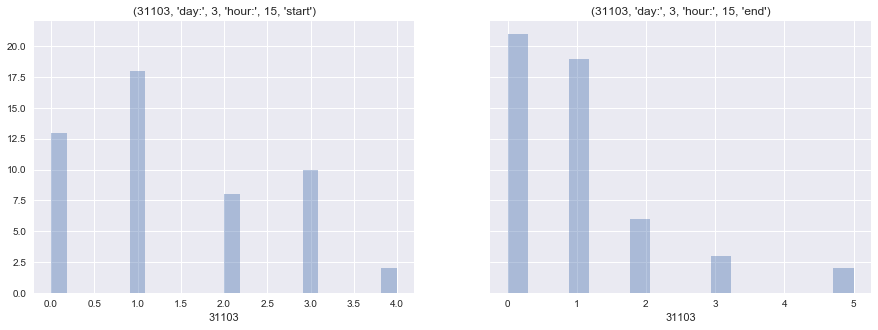

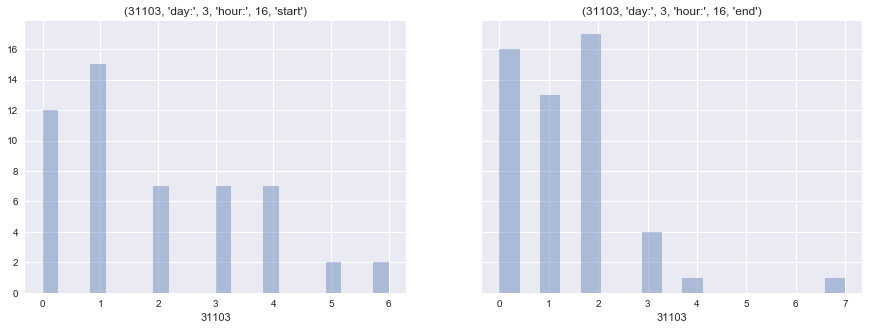

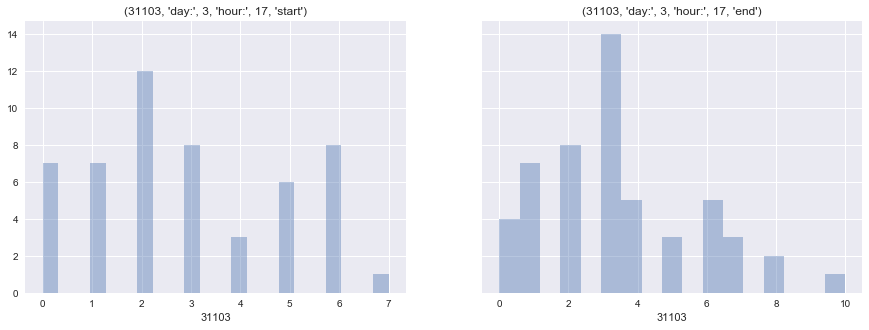

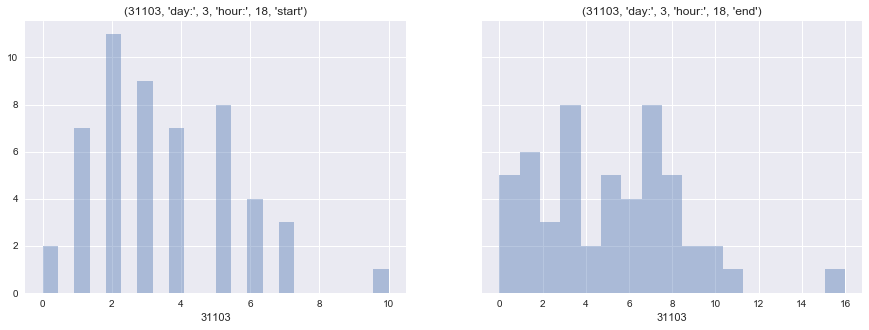

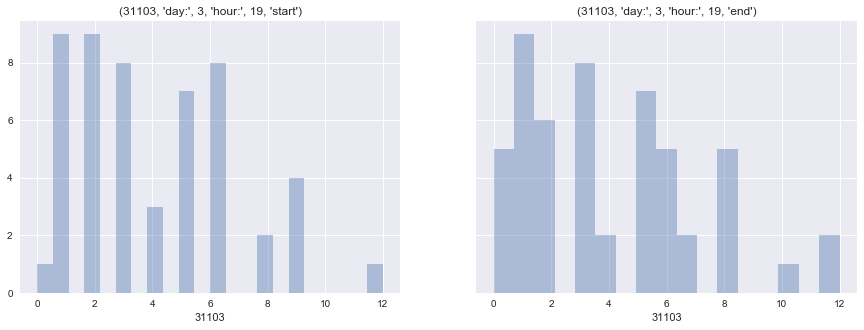

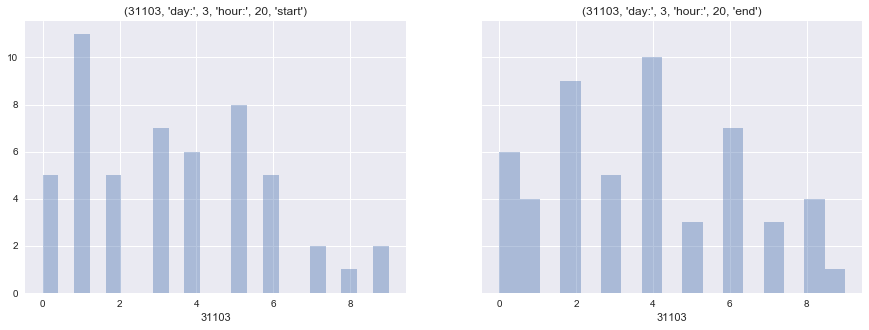

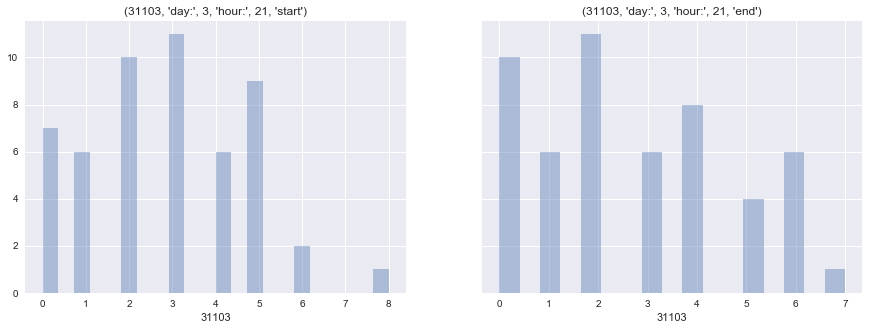

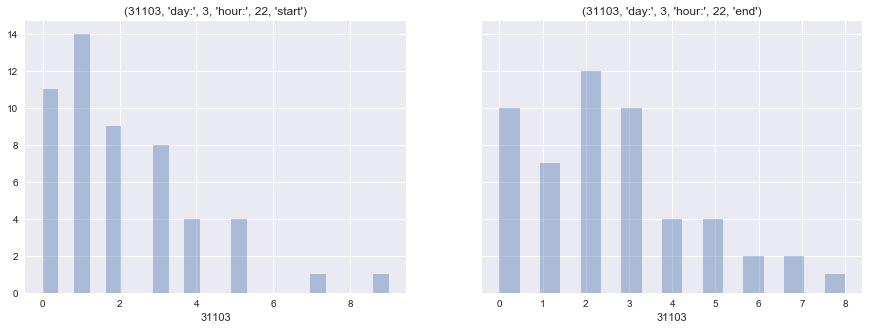

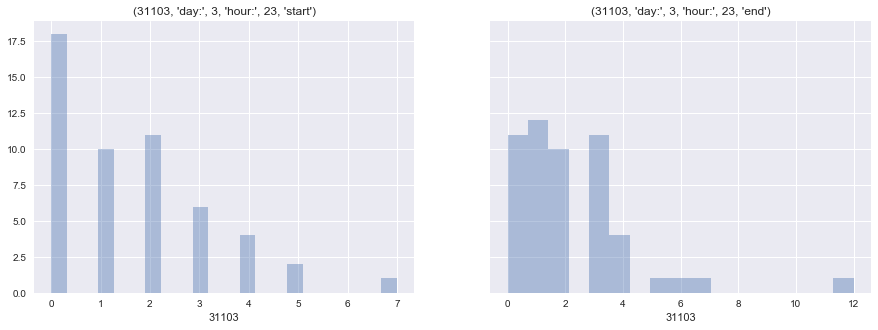

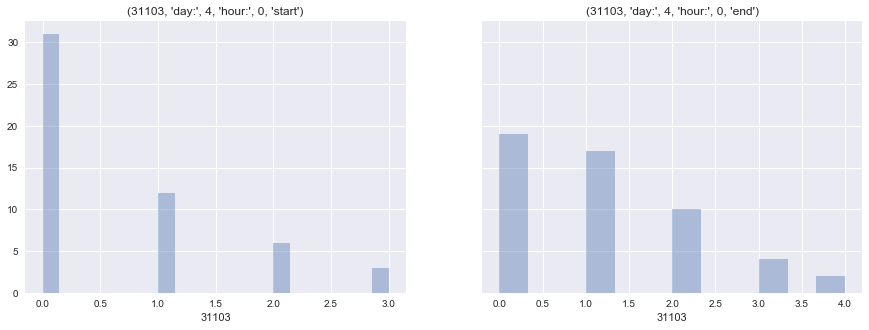

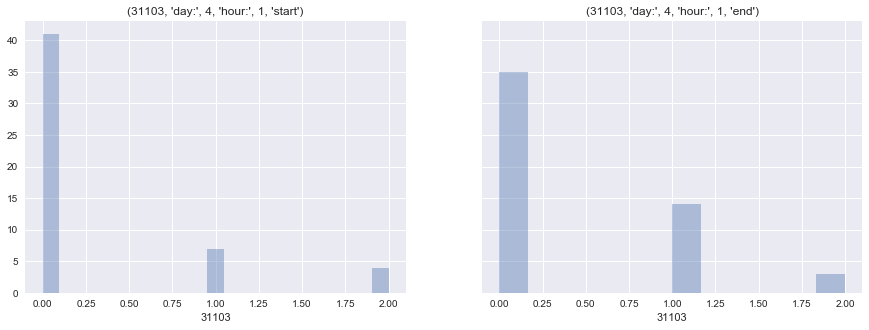

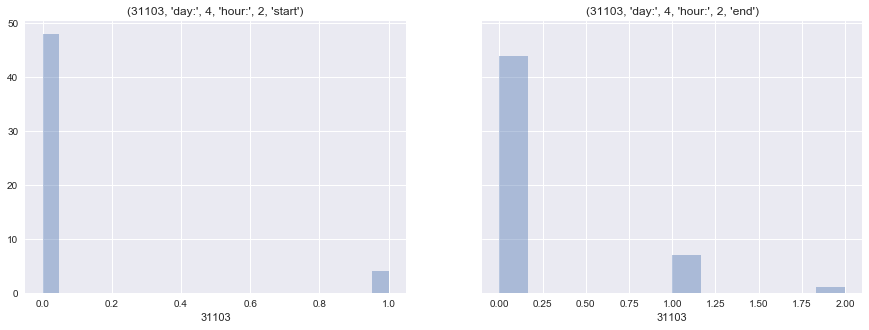

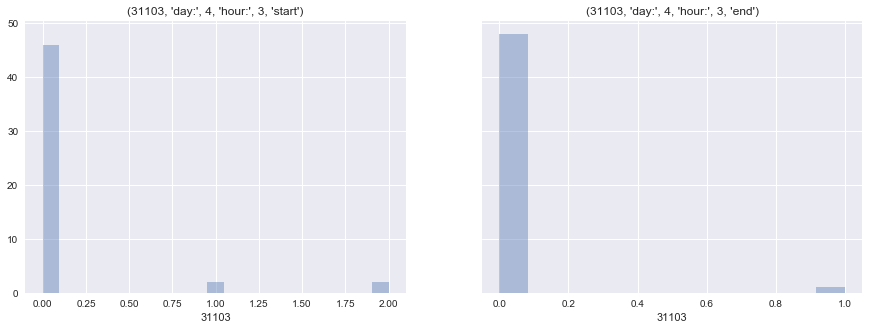

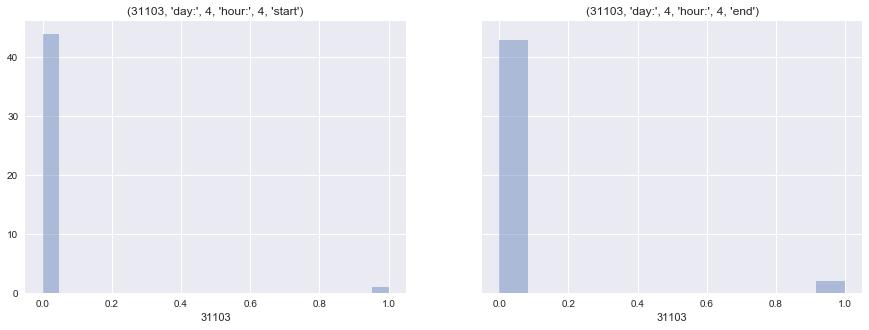

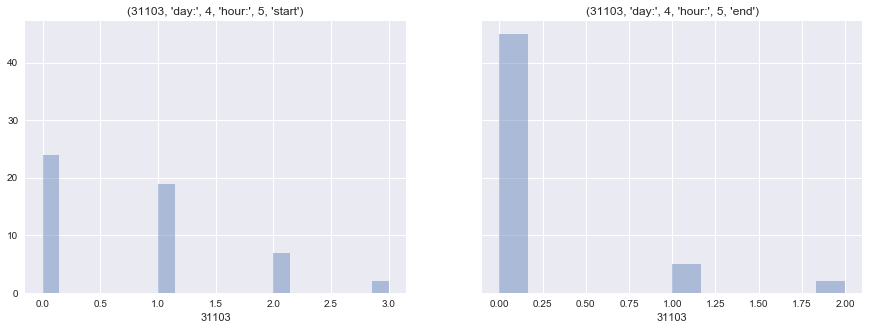

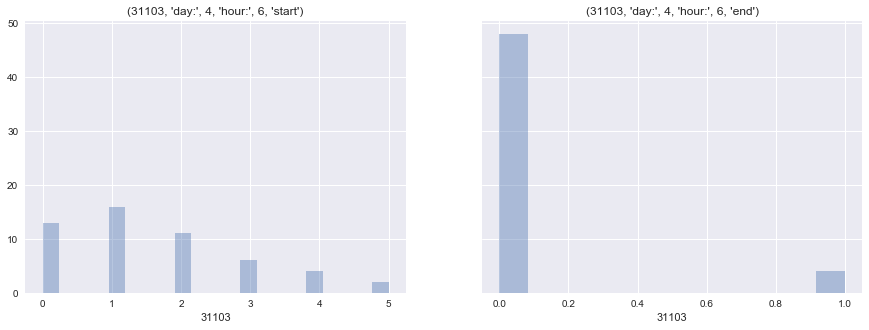

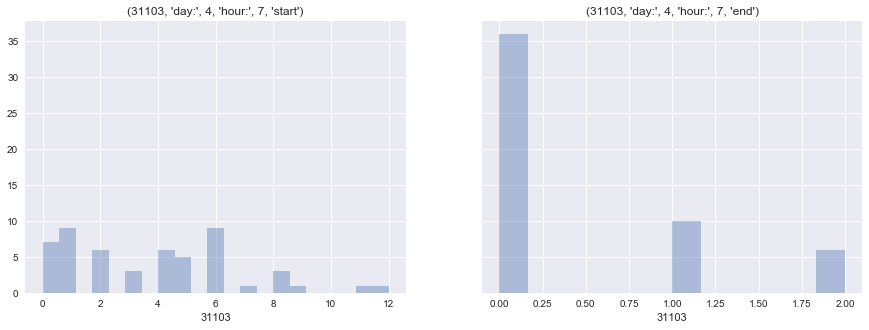

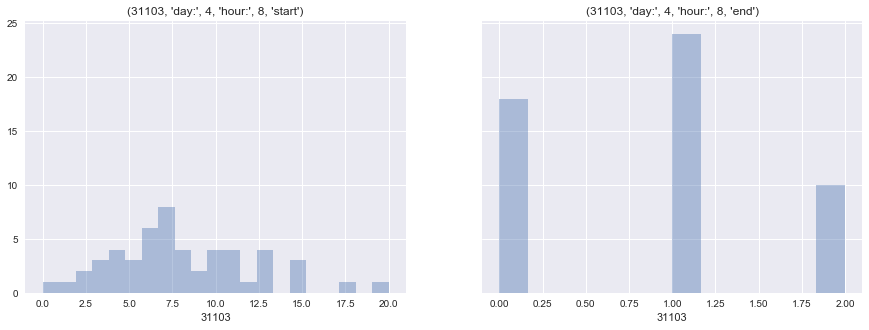

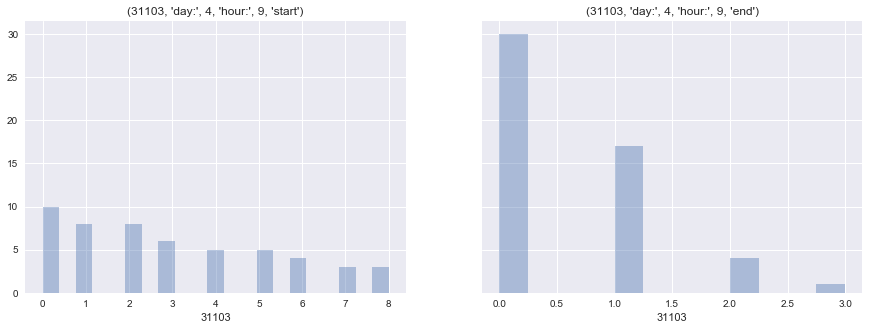

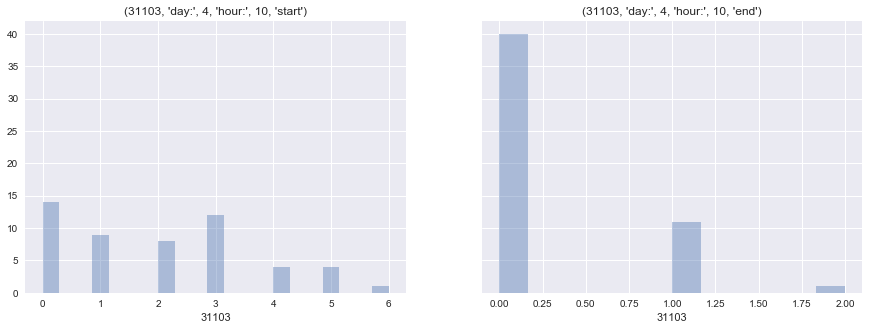

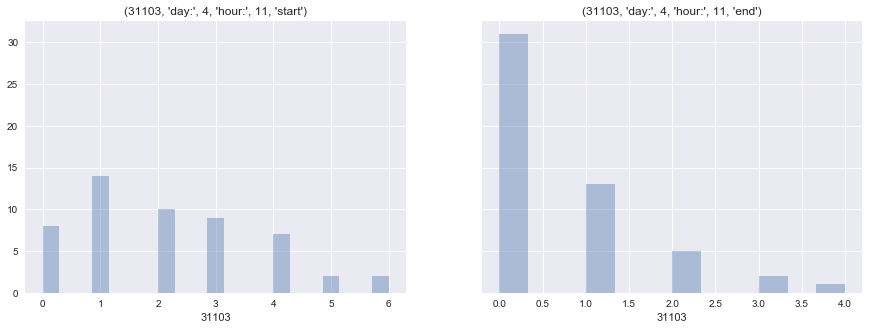

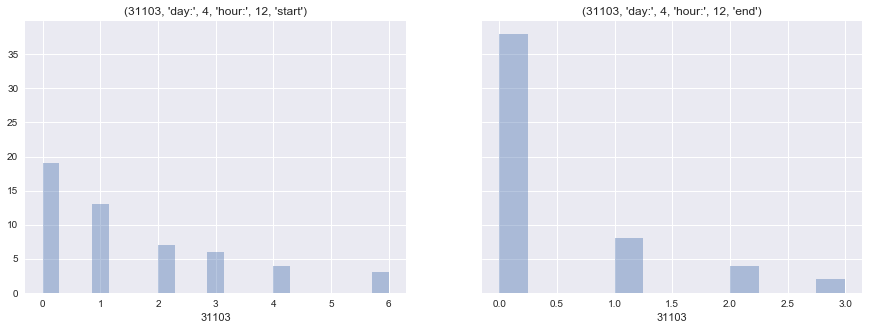

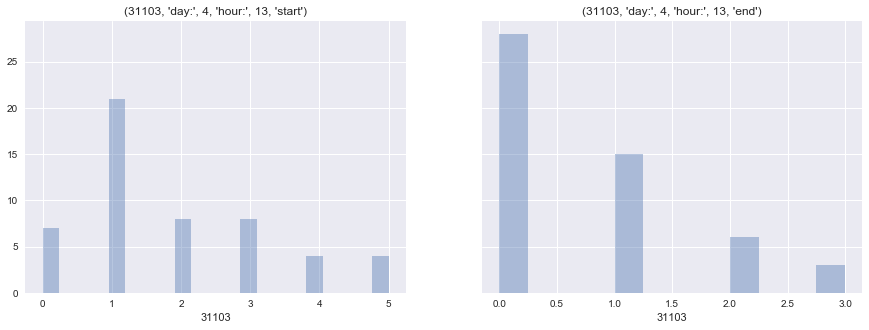

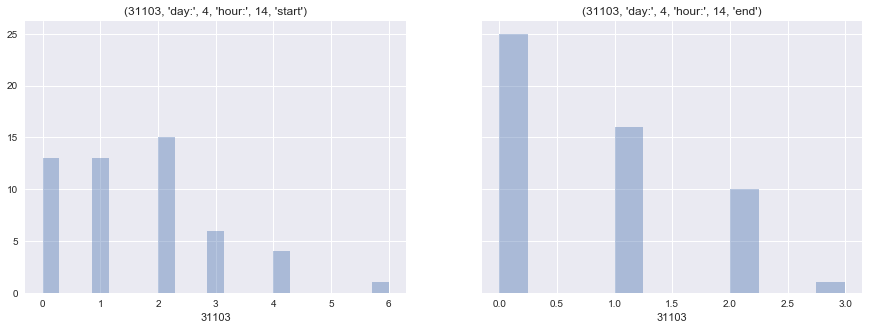

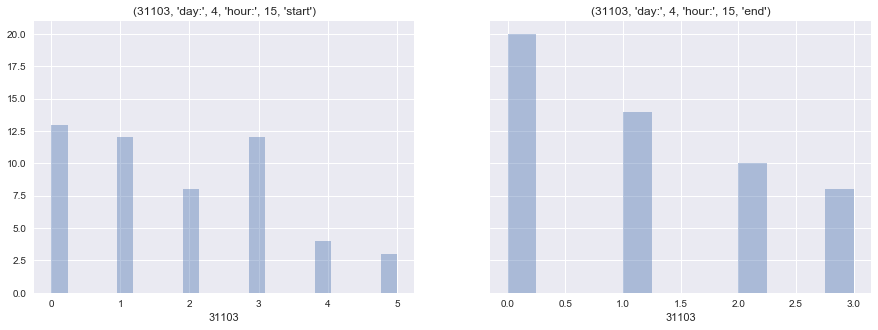

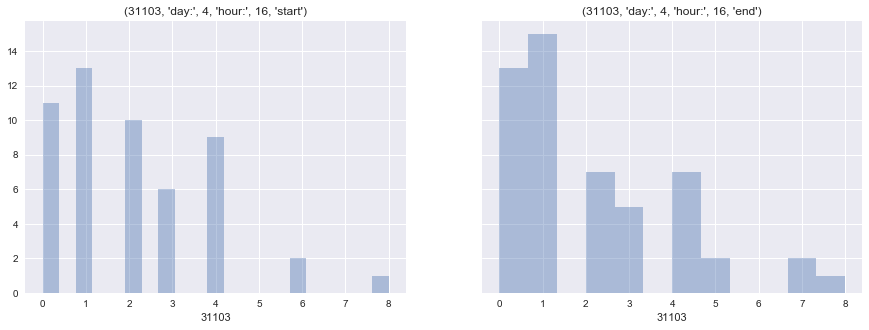

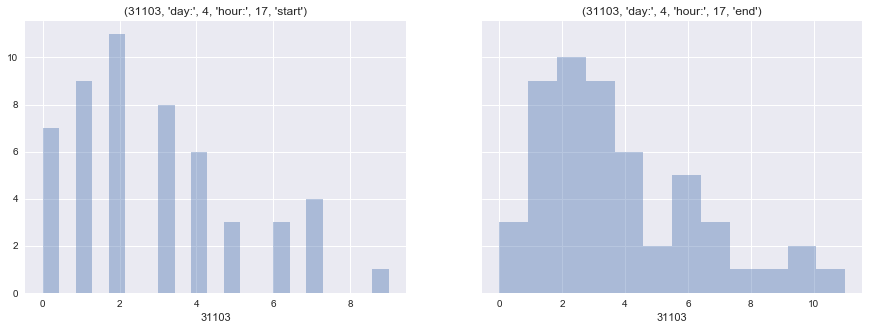

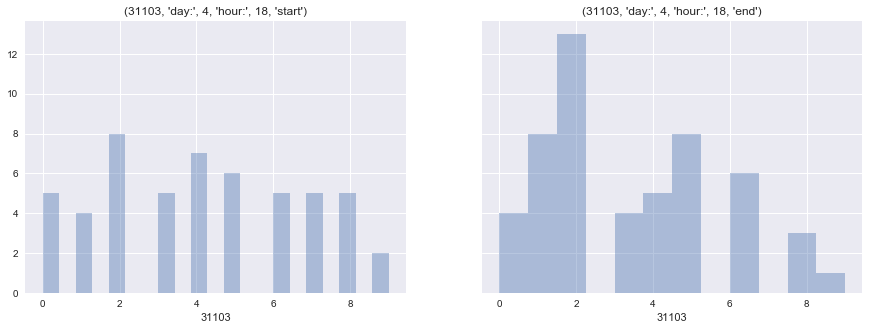

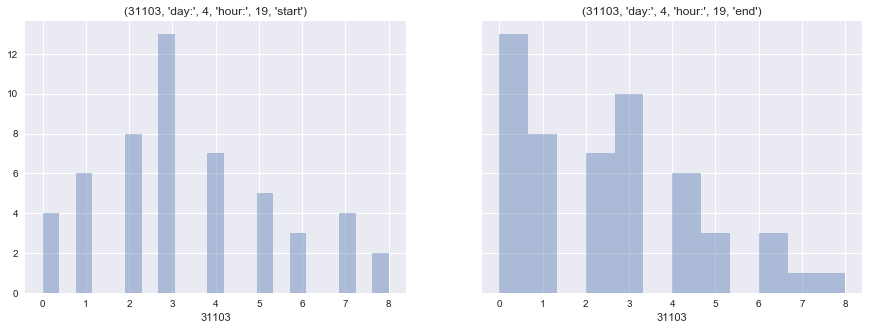

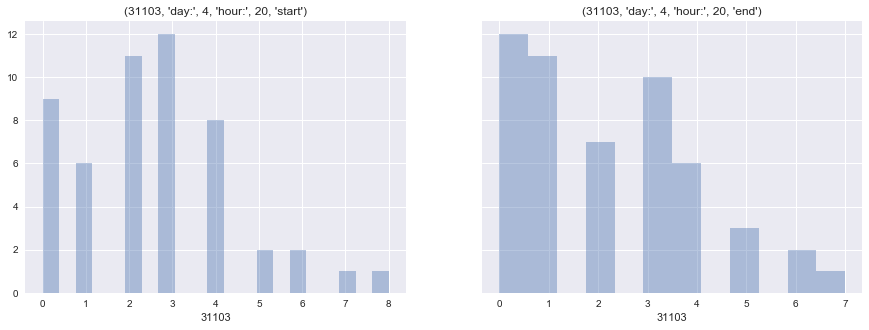

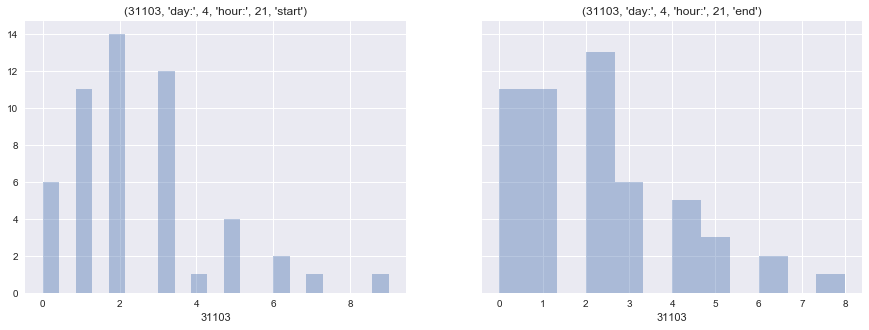

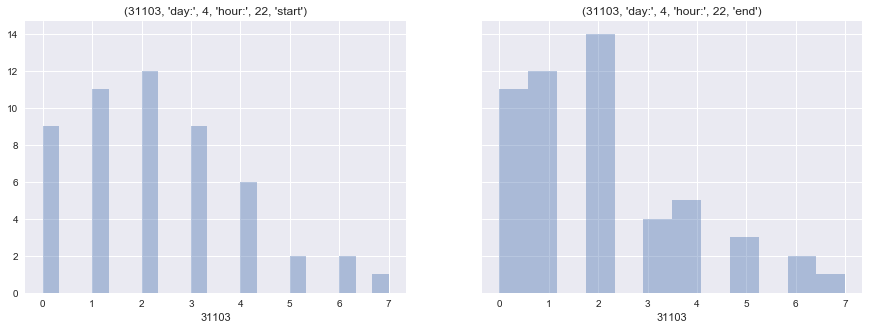

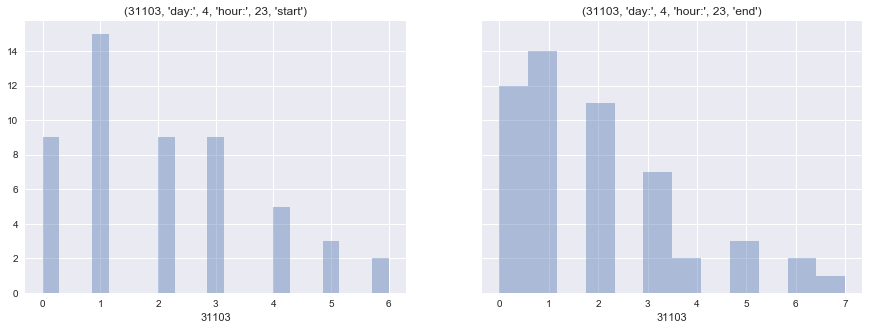

/Users/Derek/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/Derek/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


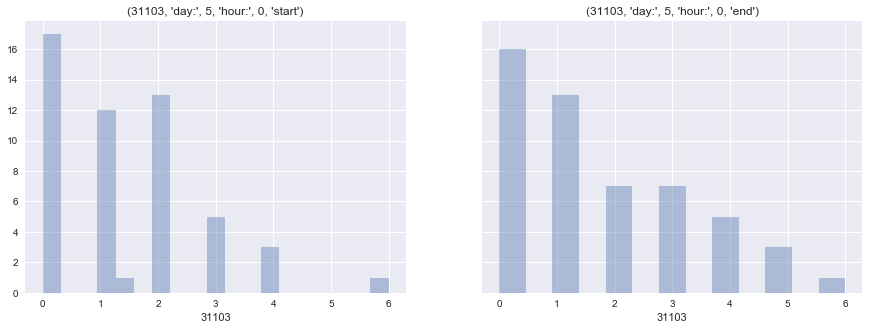

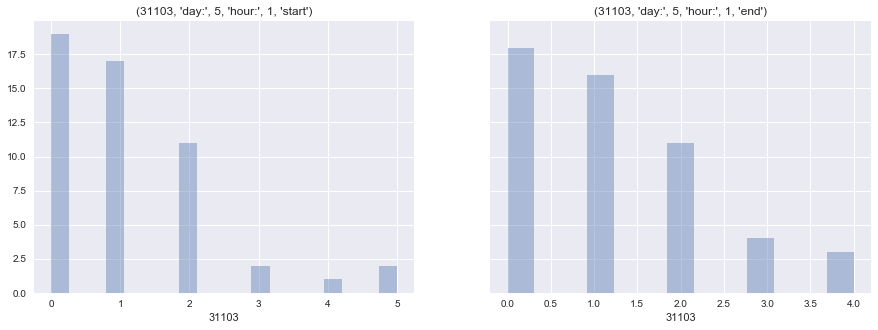

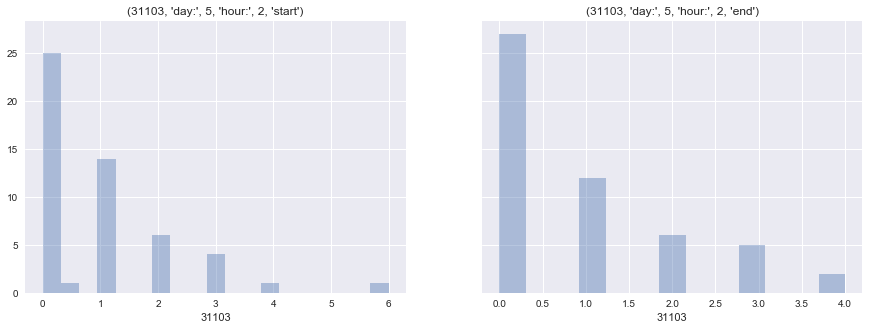

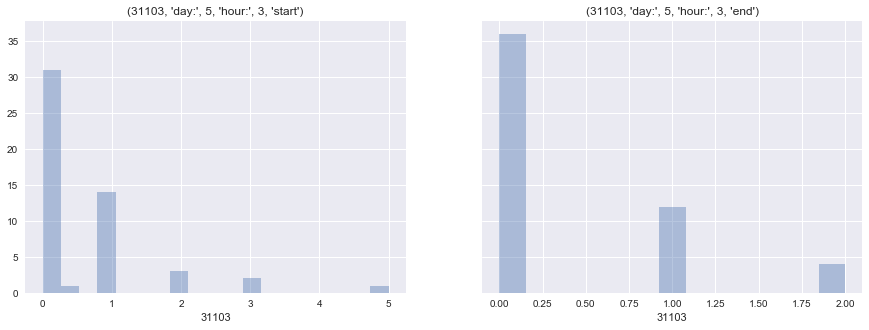

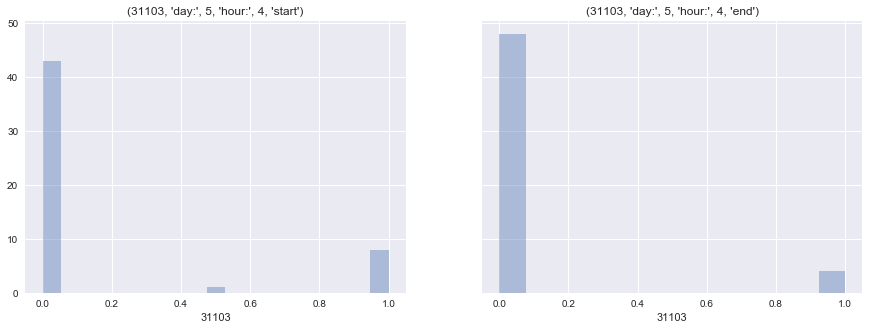

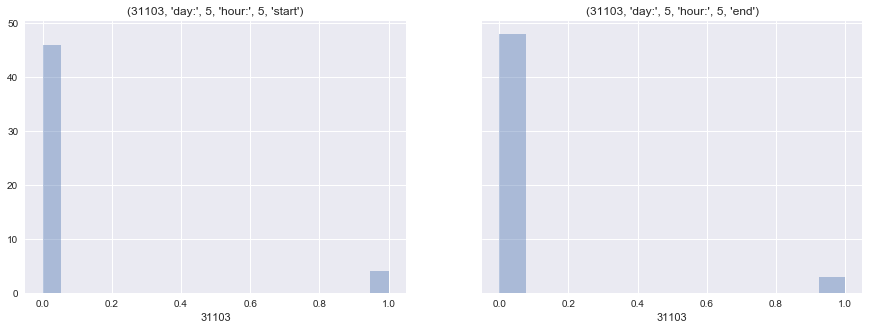

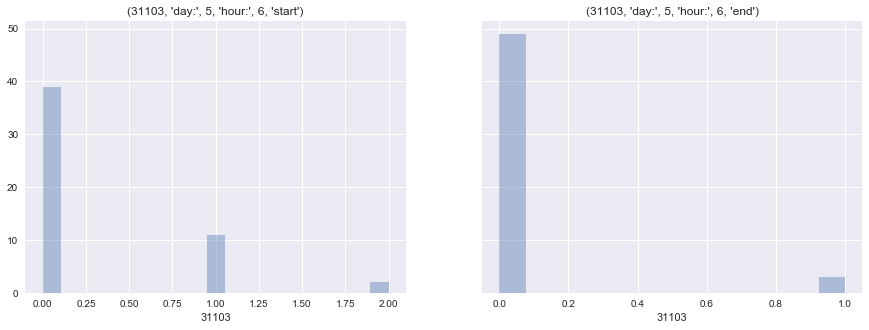

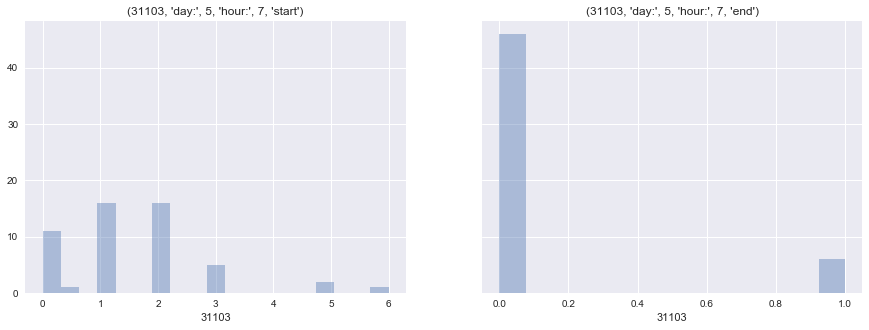

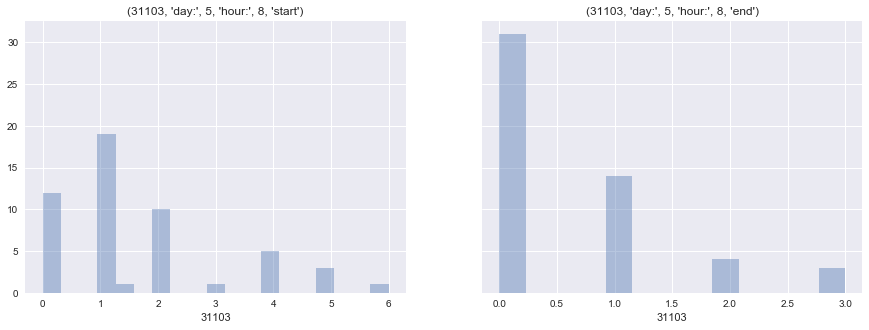

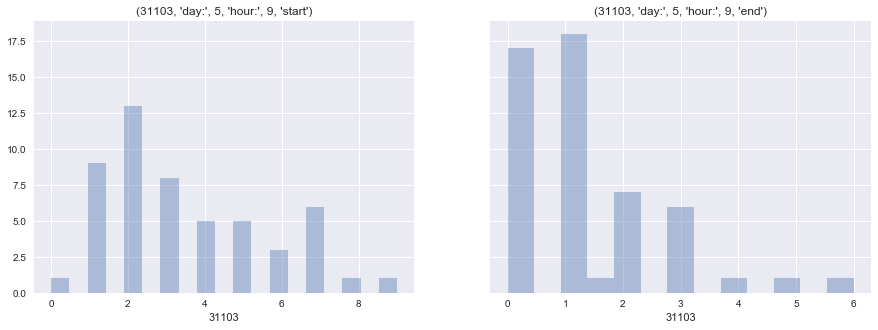

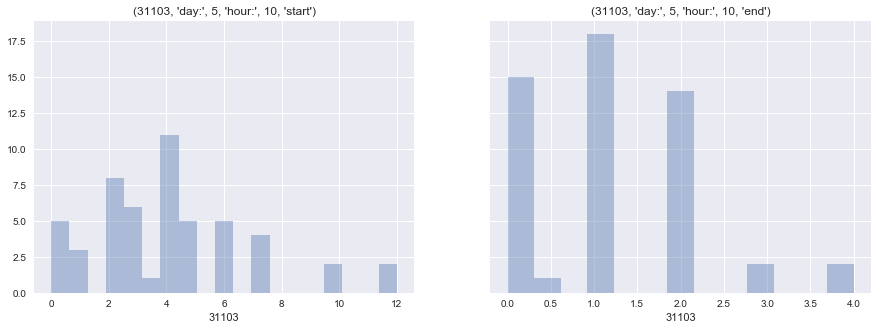

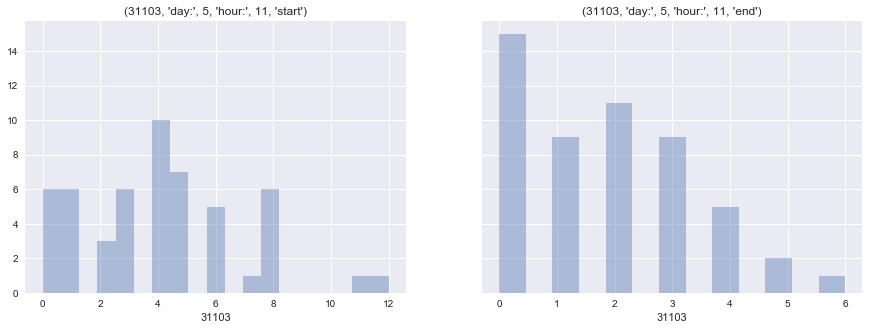

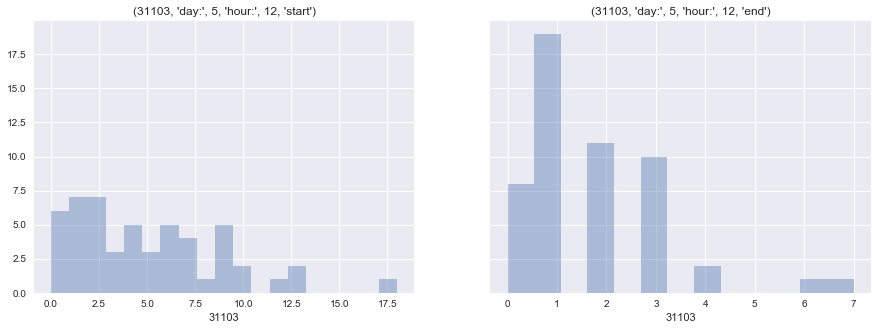

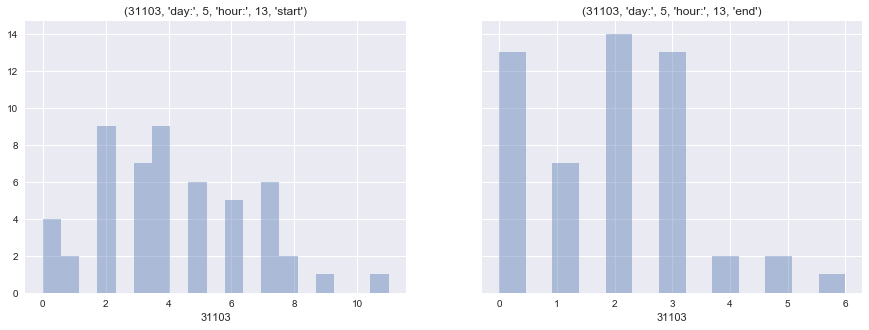

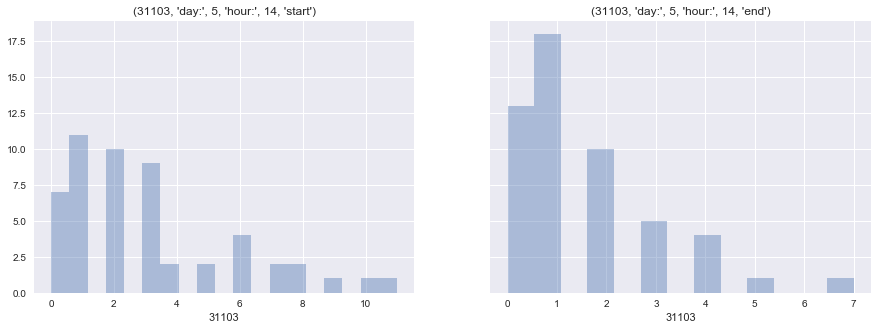

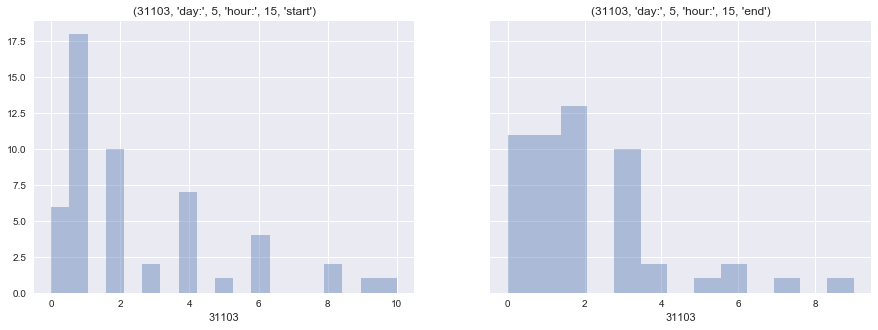

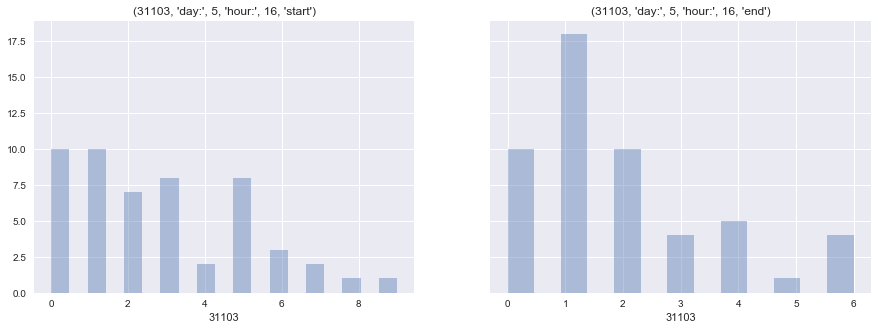

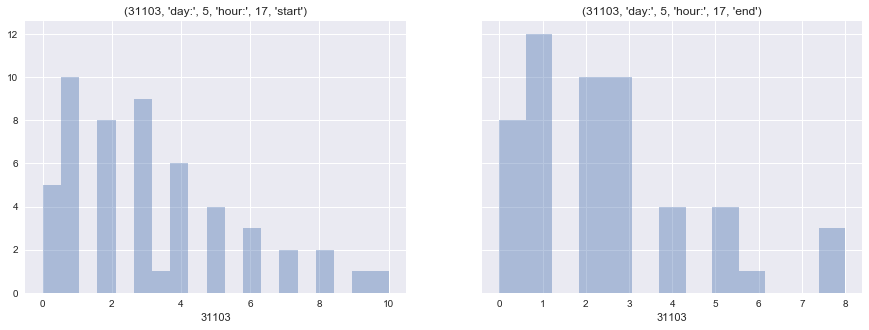

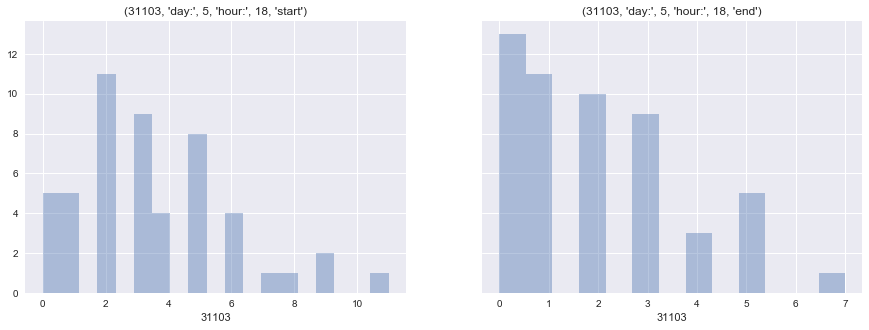

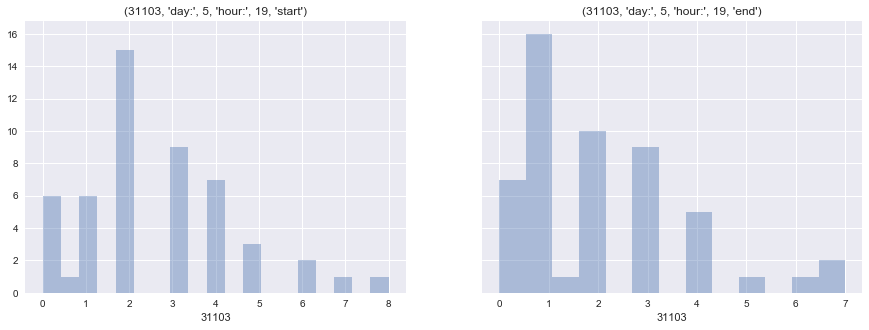

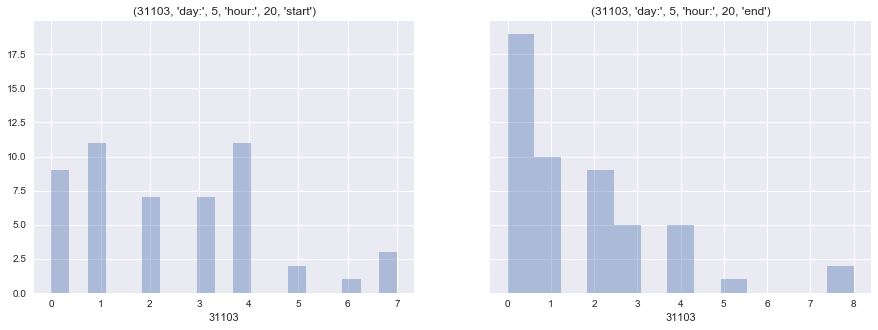

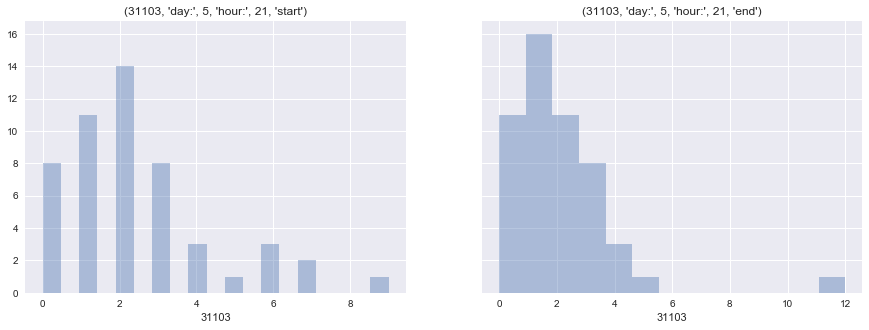

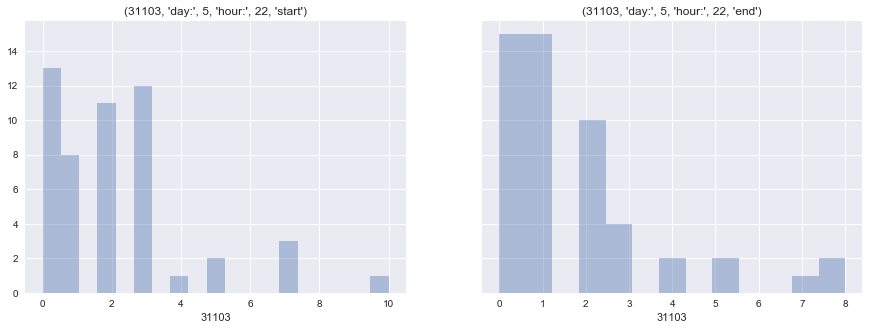

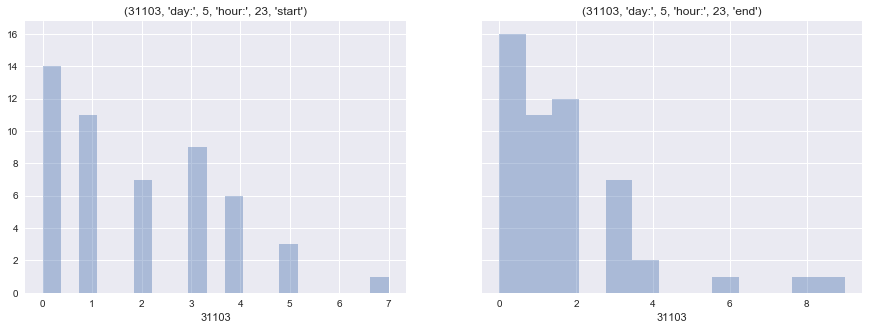

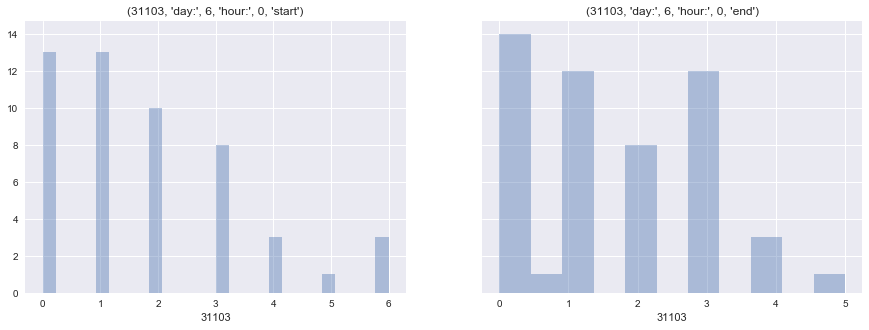

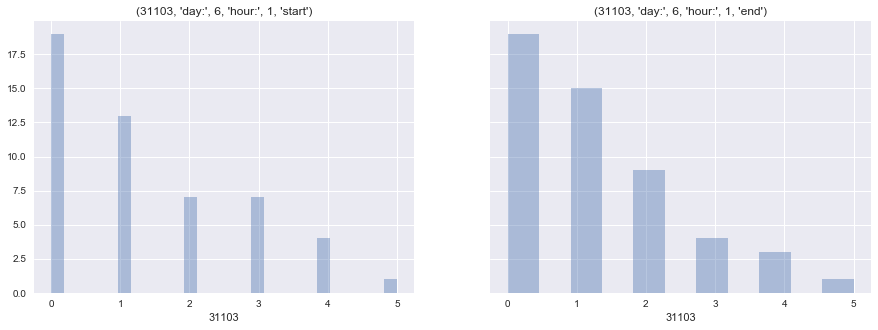

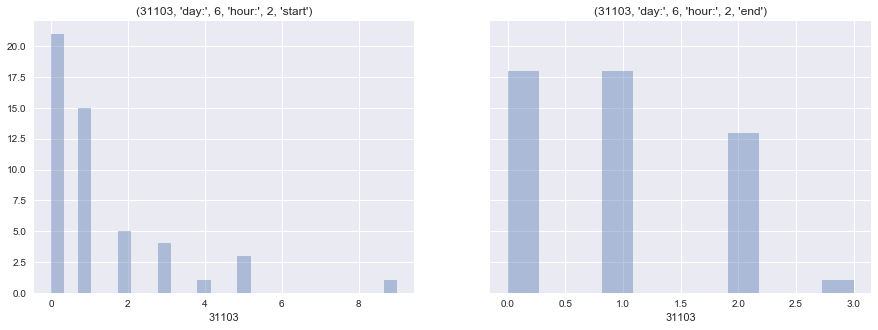

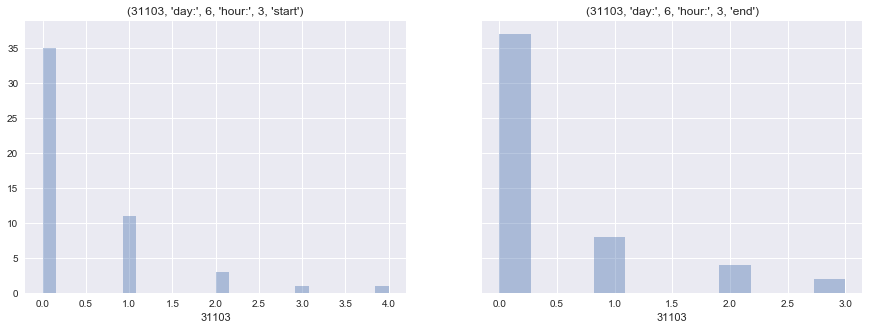

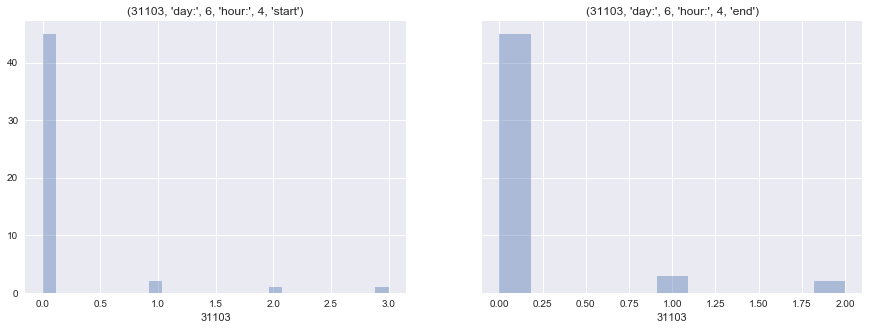

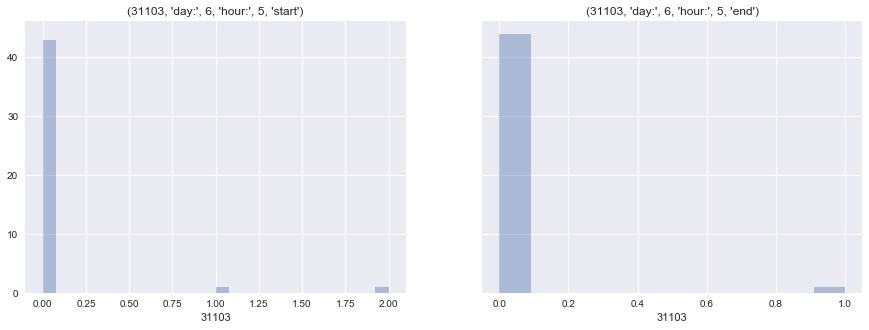

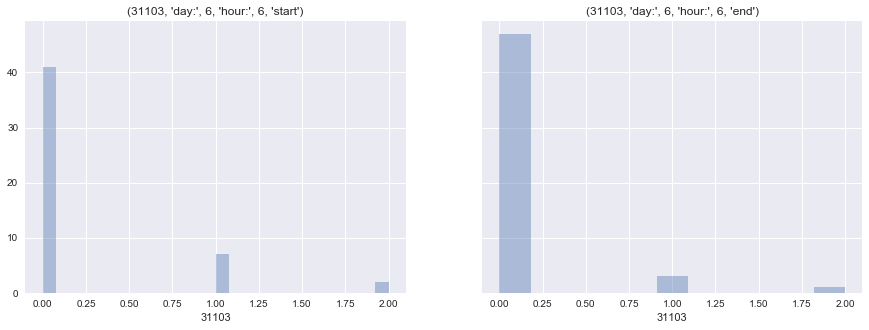

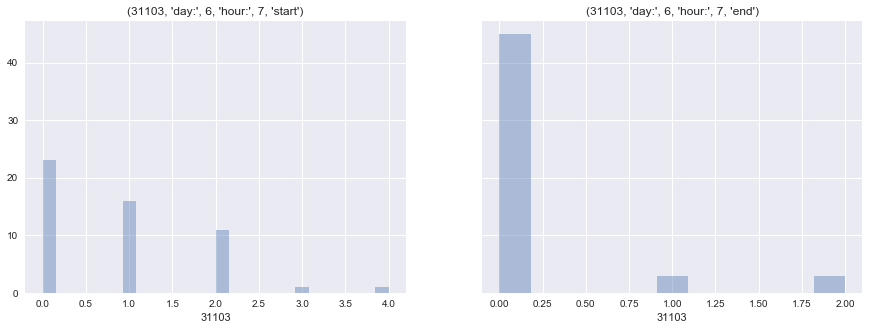

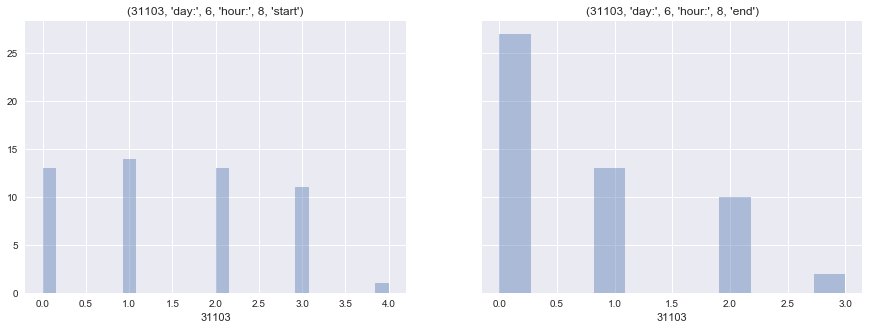

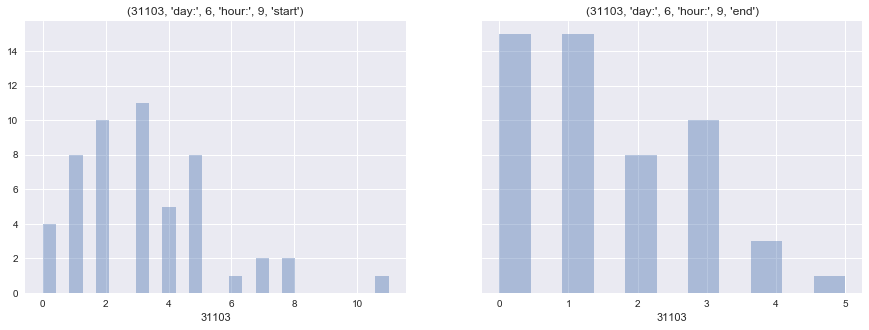

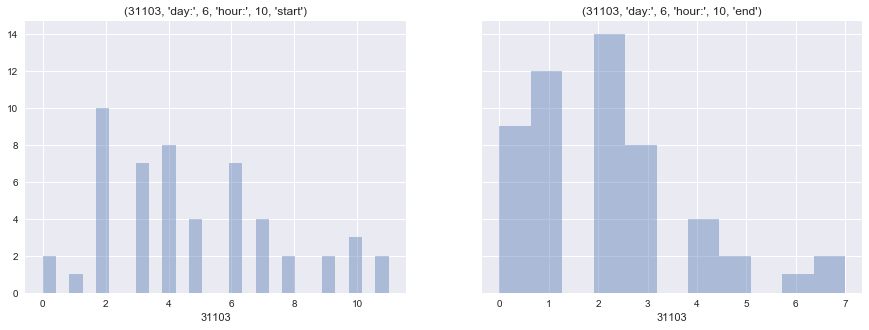

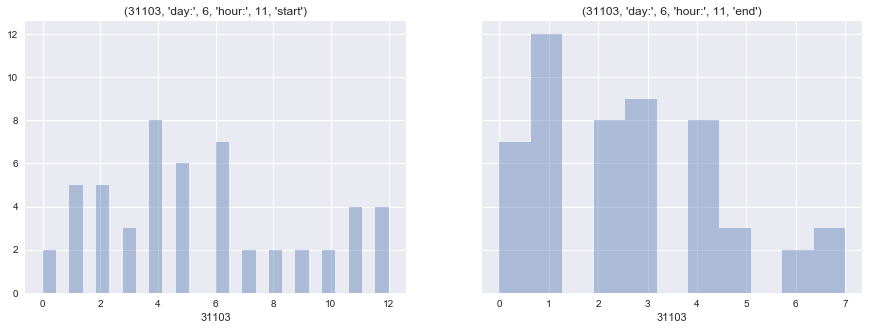

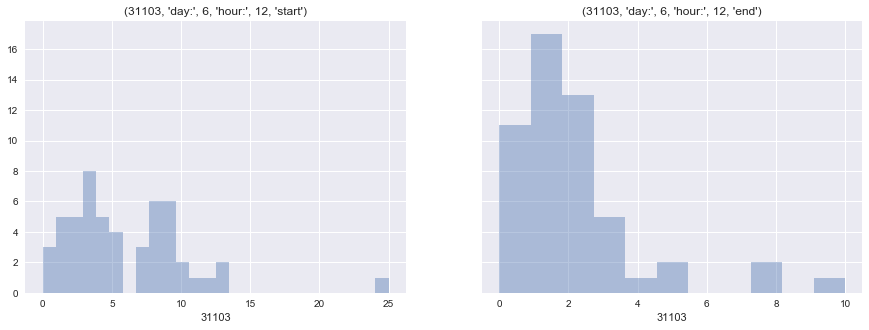

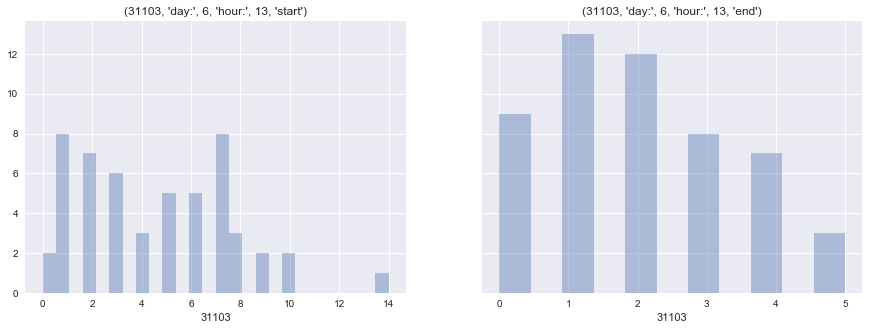

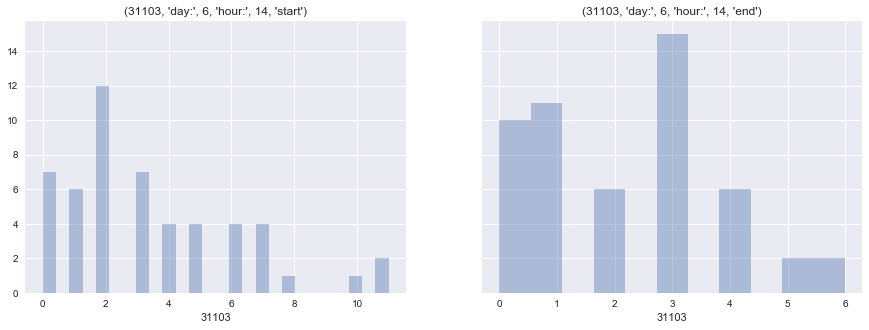

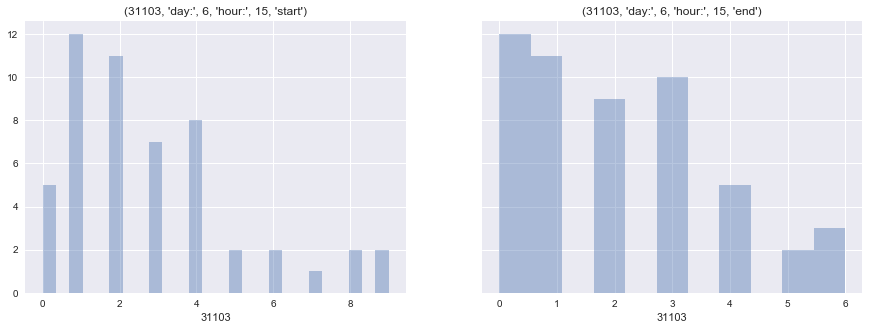

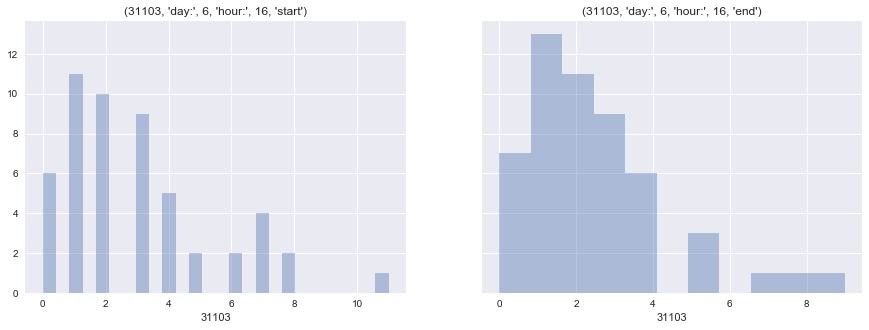

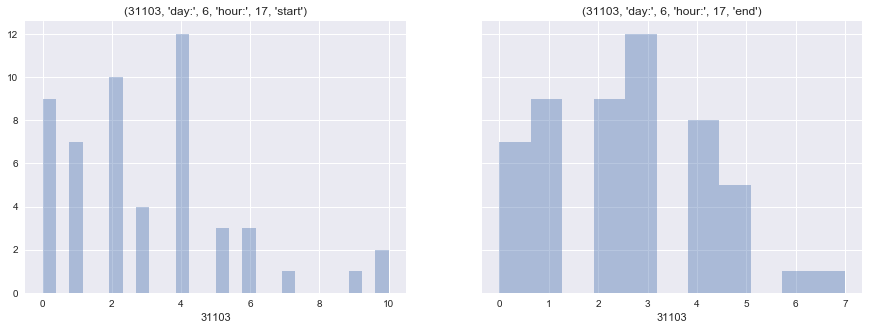

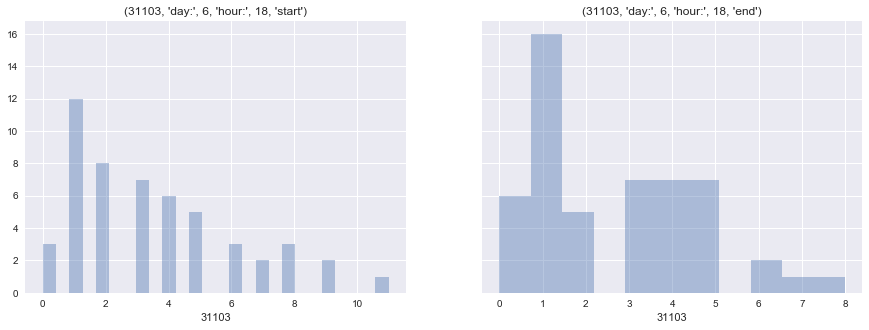

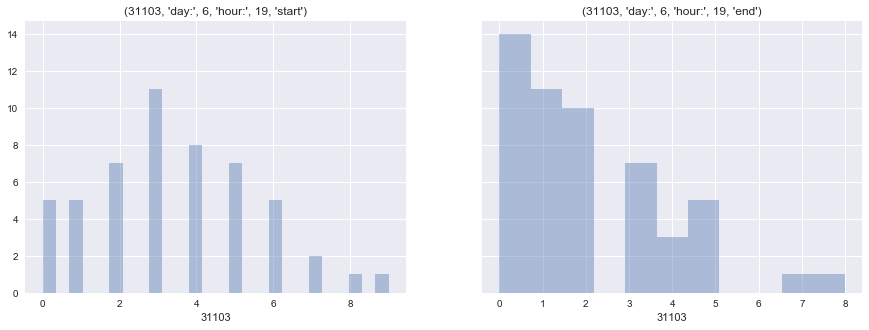

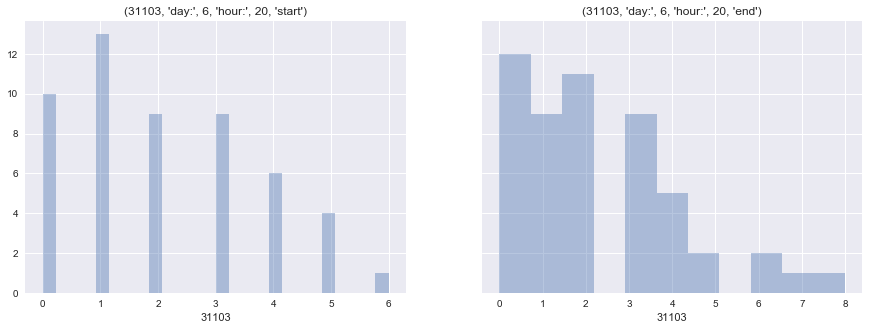

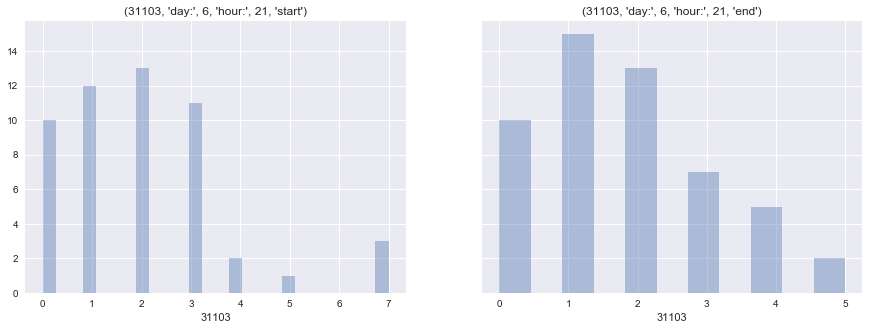

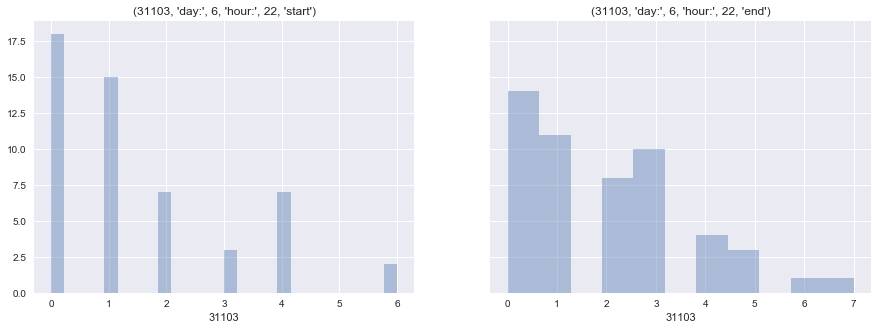

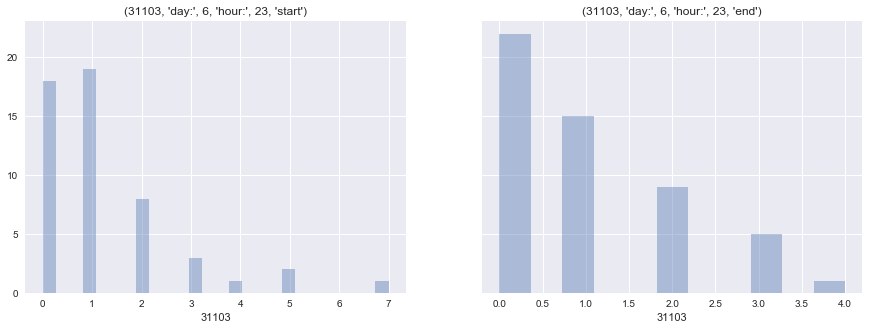

31200


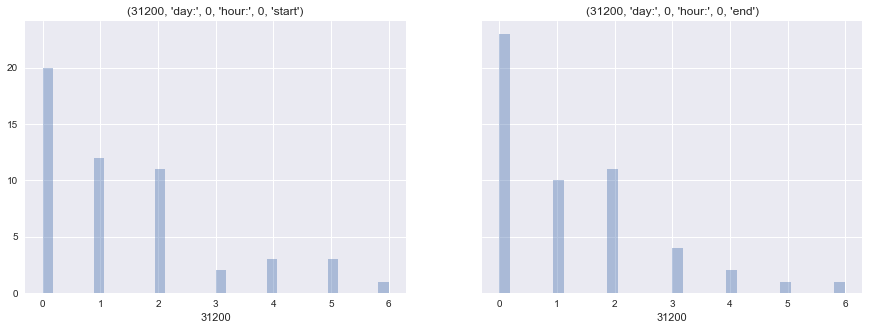

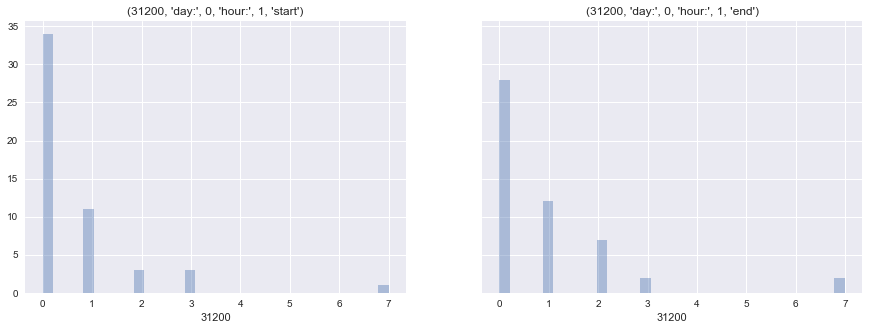

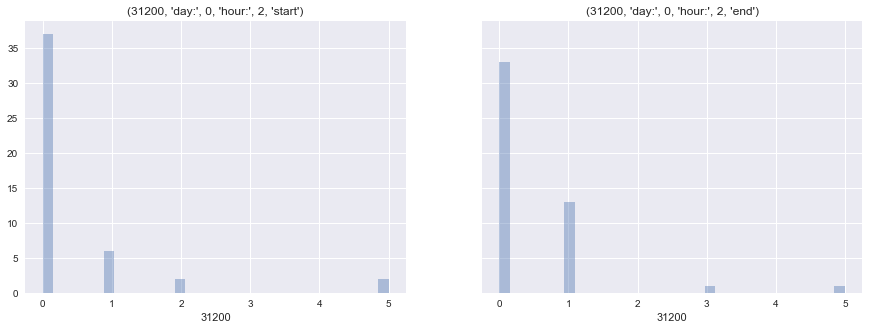

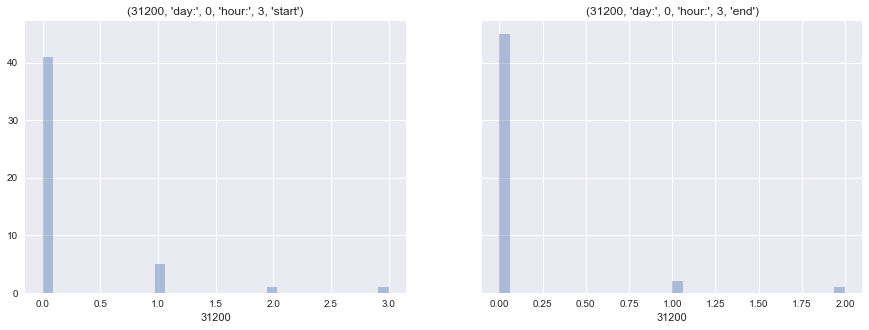

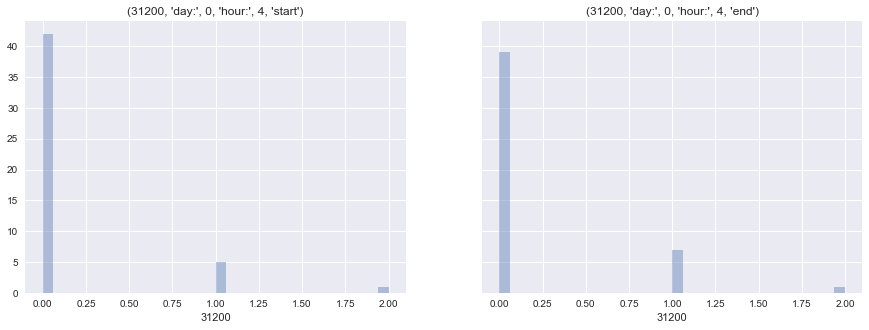

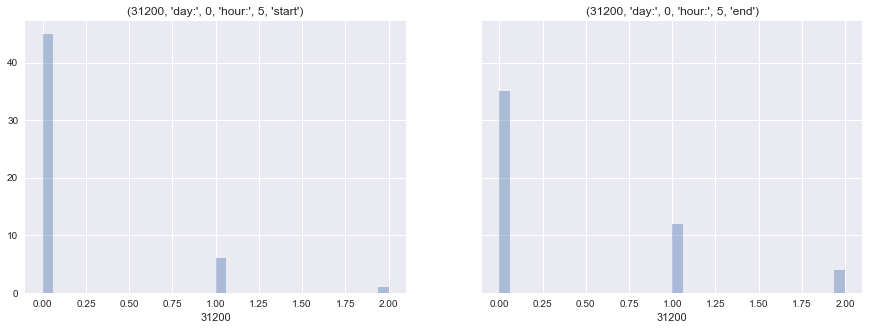

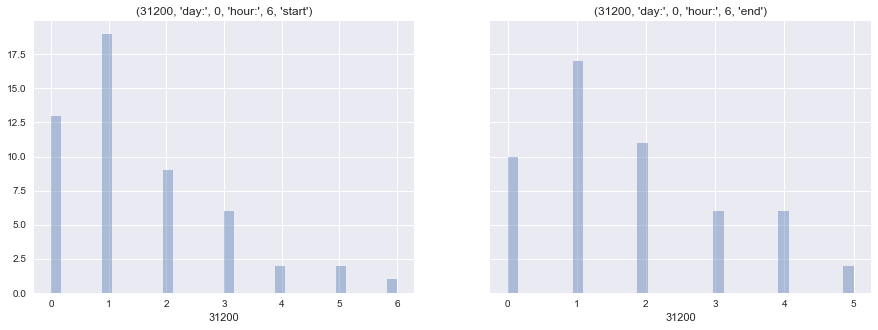

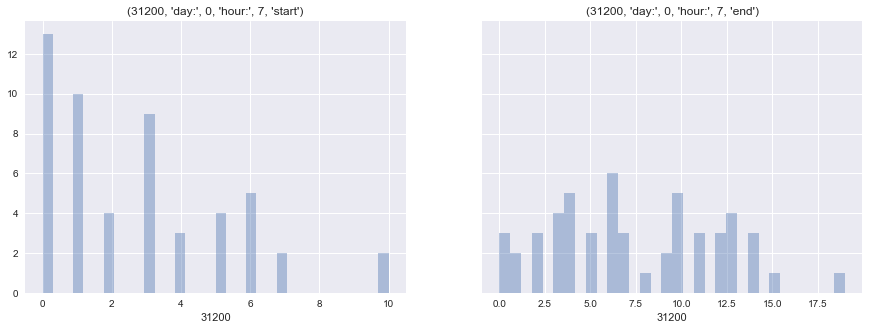

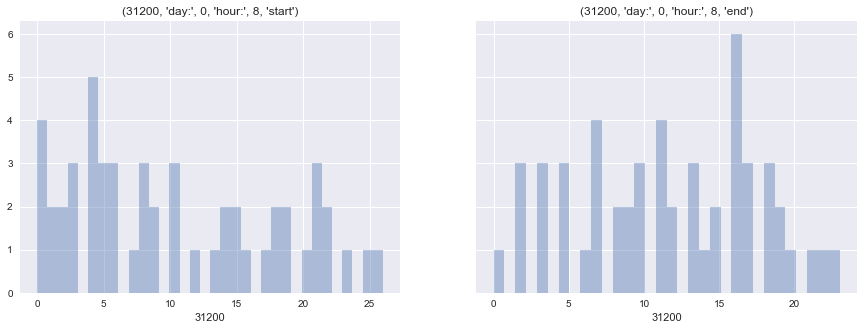

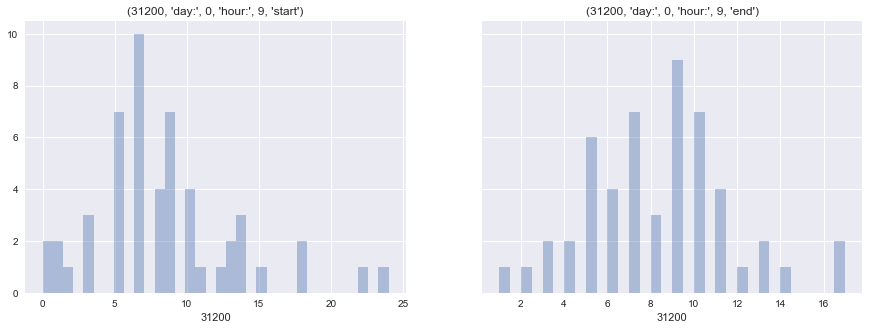

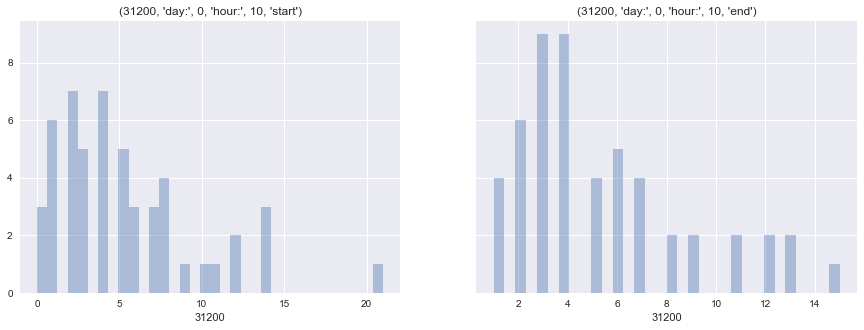

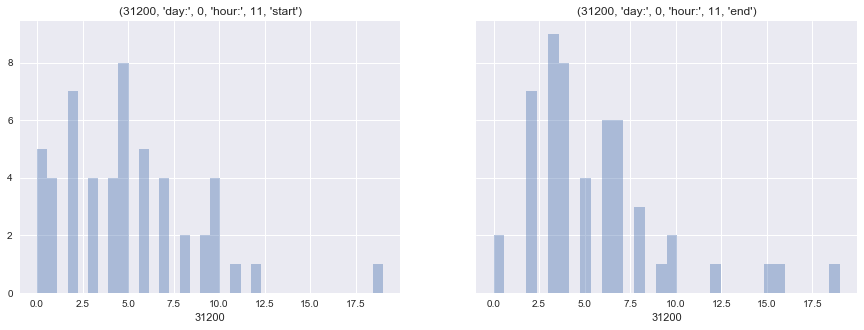

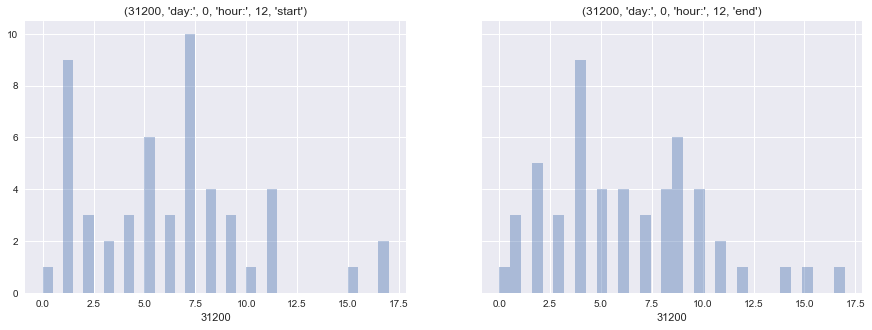

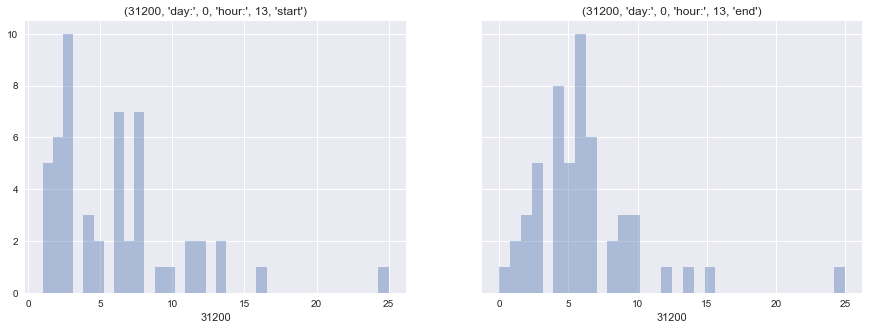

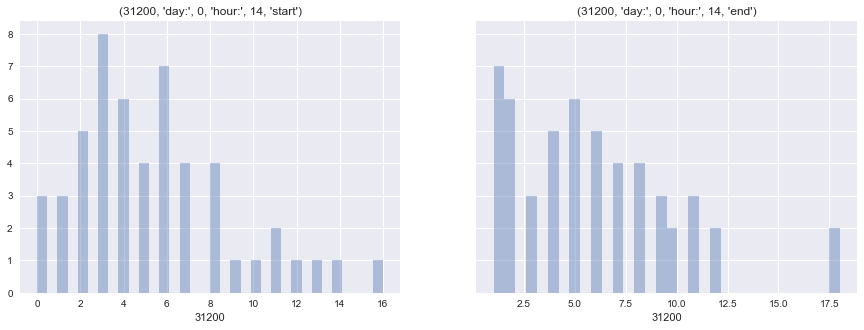

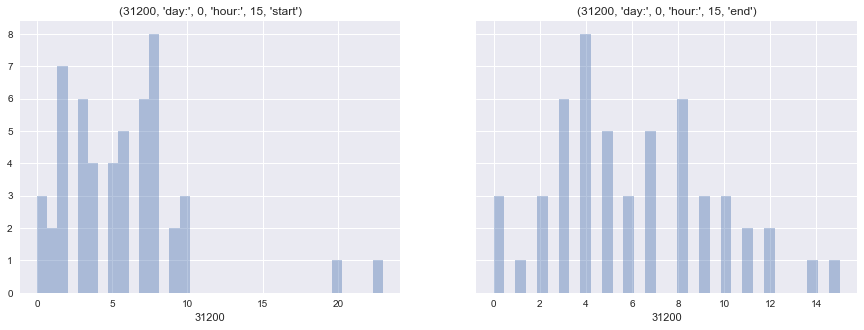

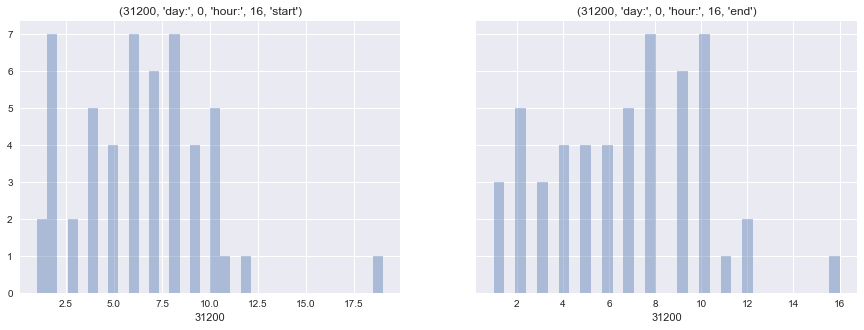

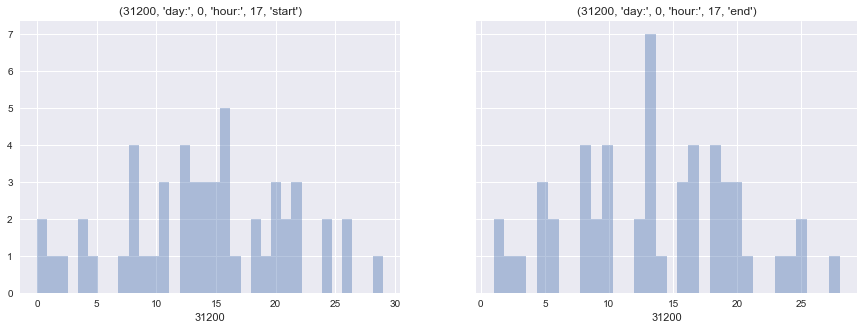

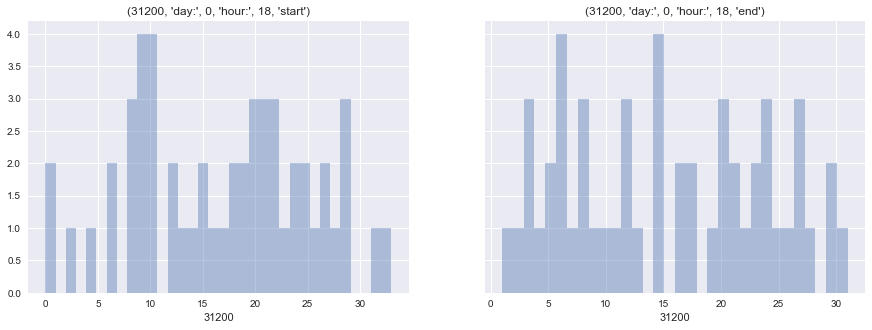

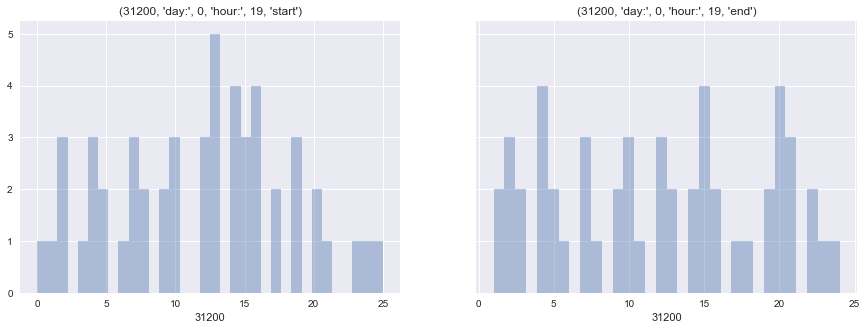

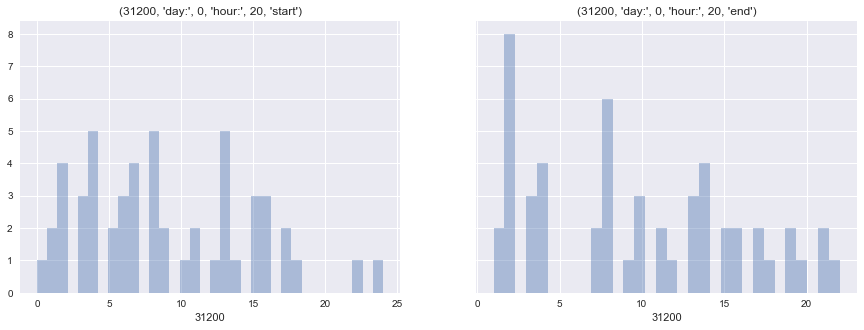

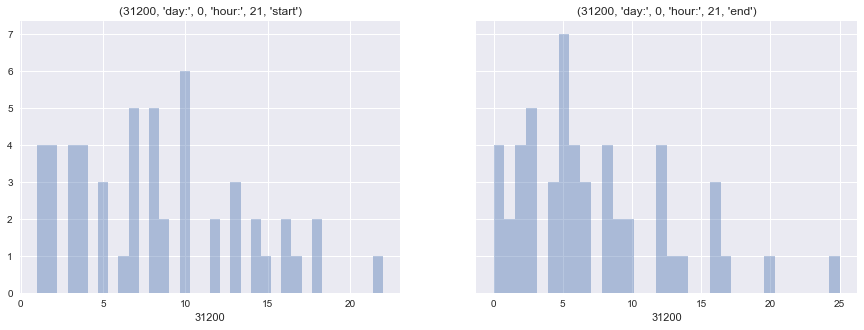

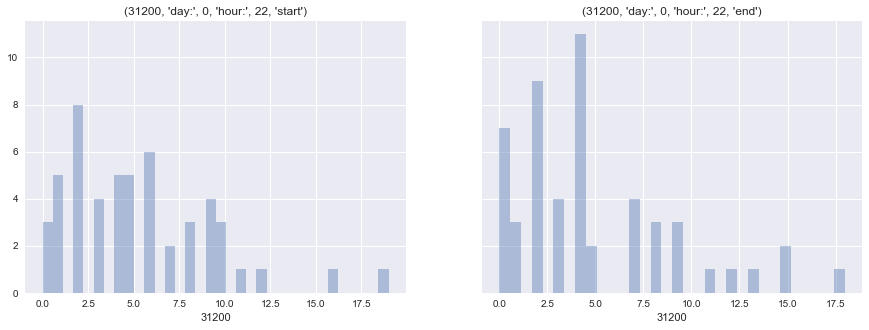

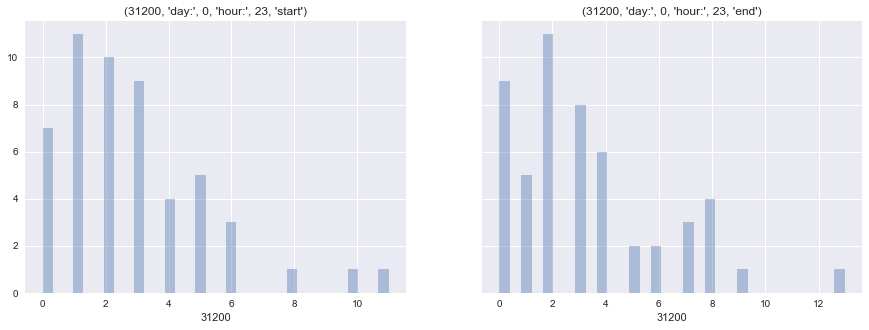

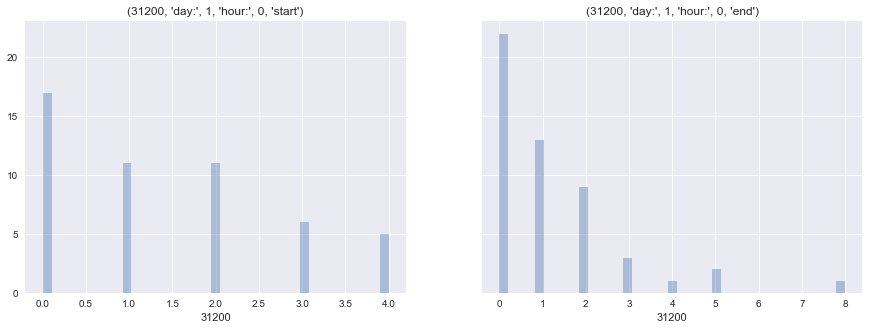

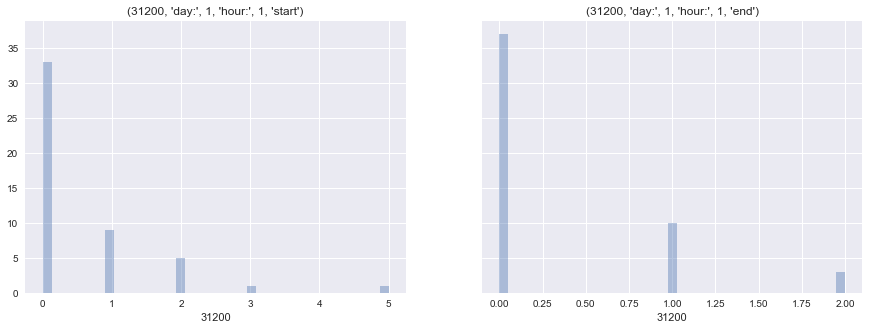

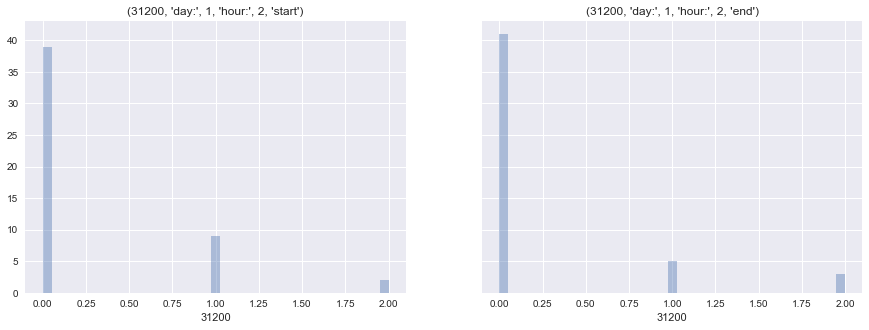

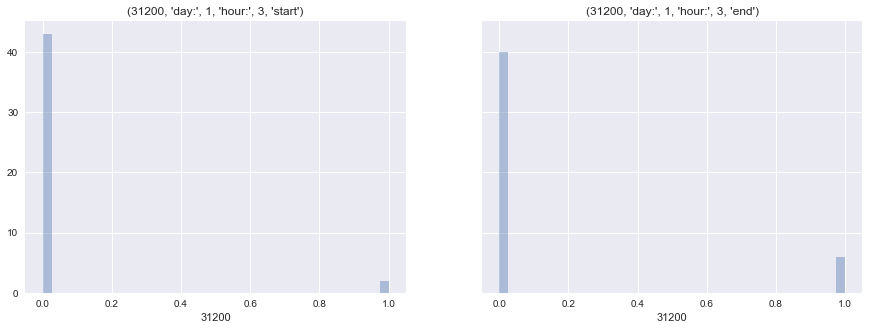

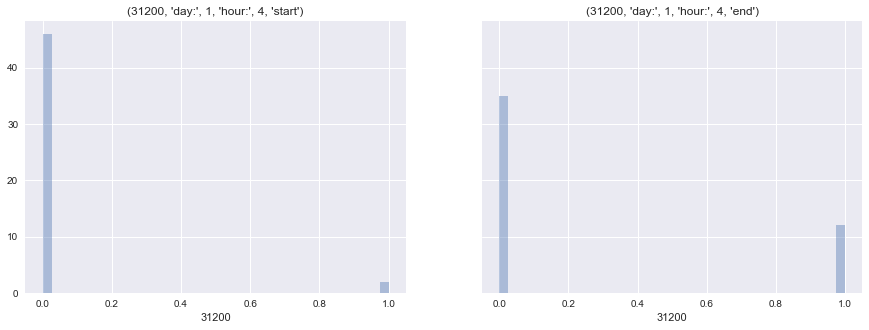

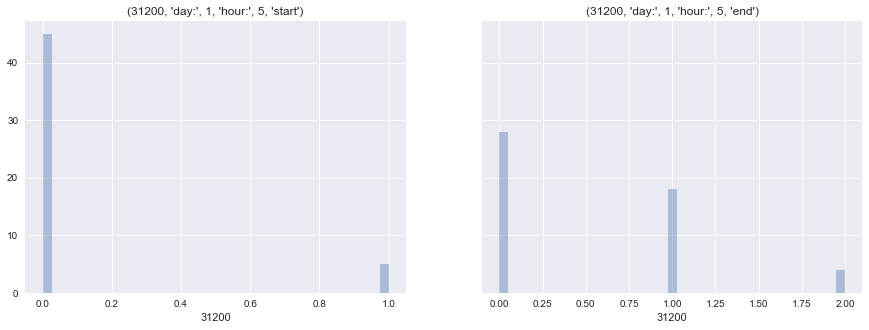

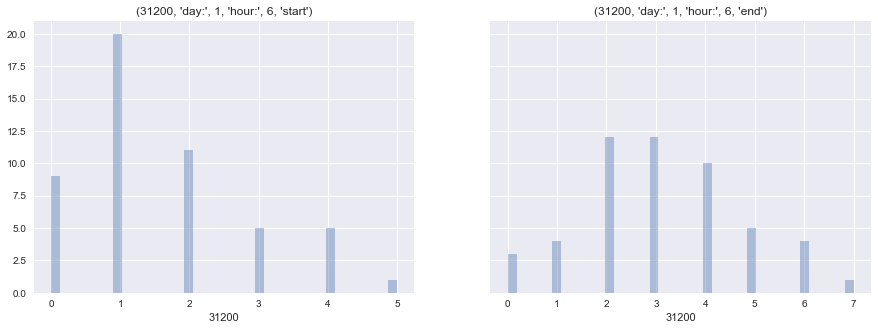

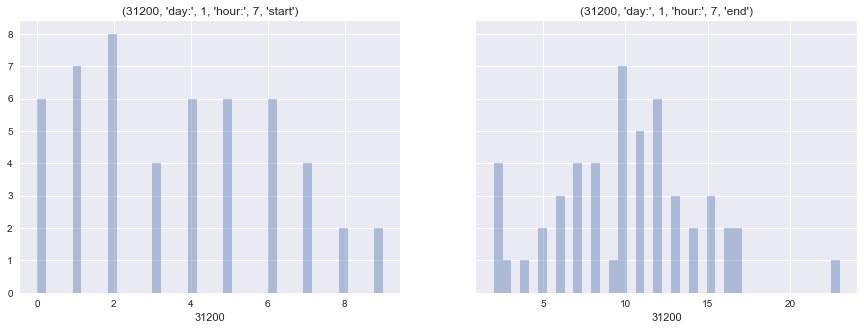

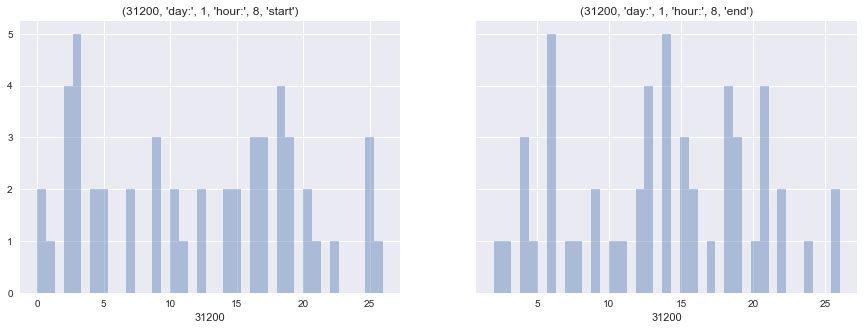

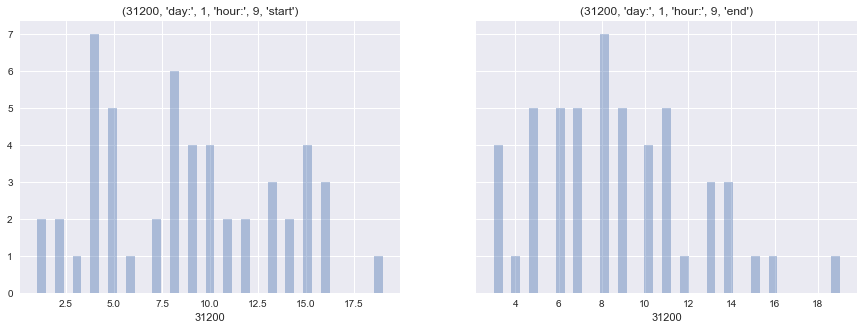

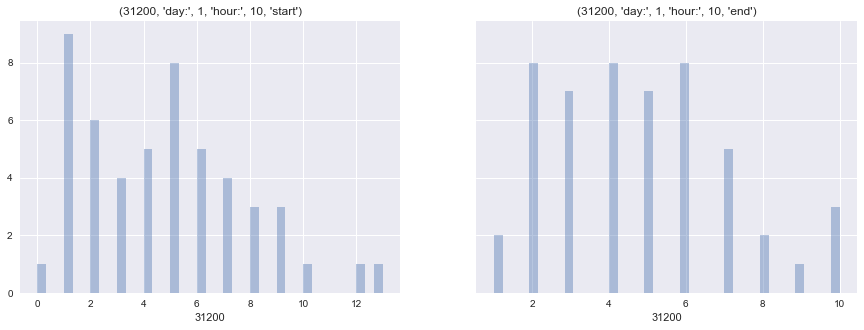

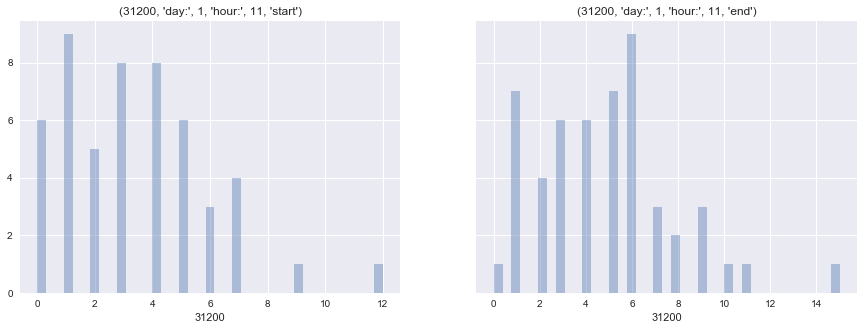

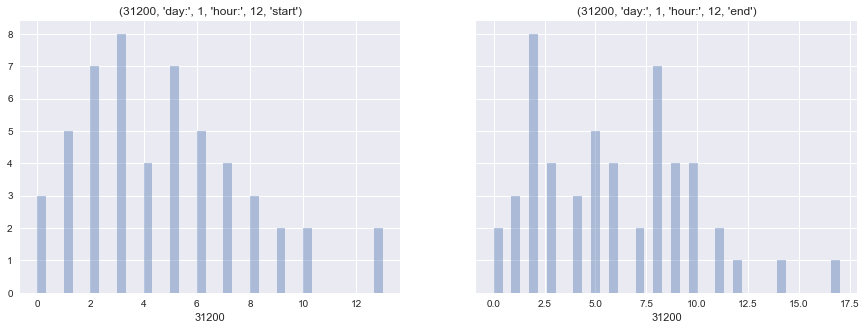

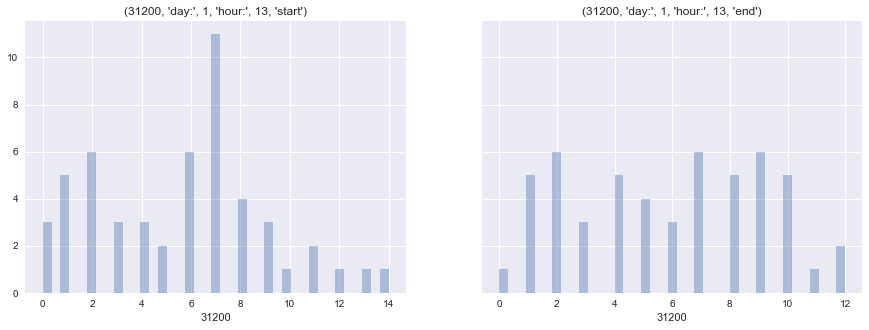

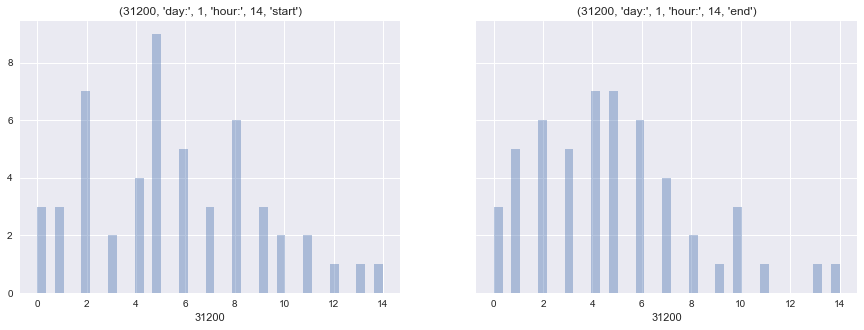

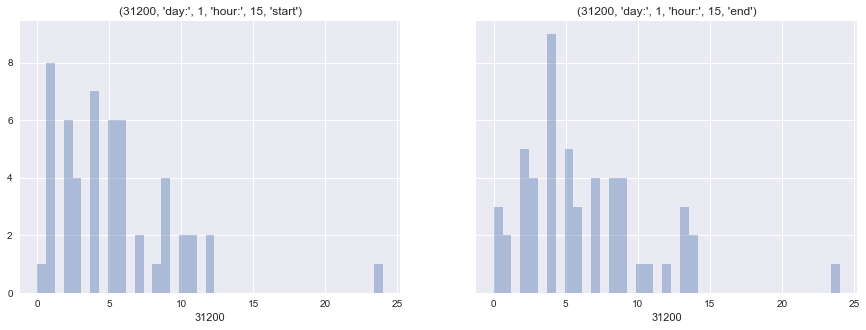

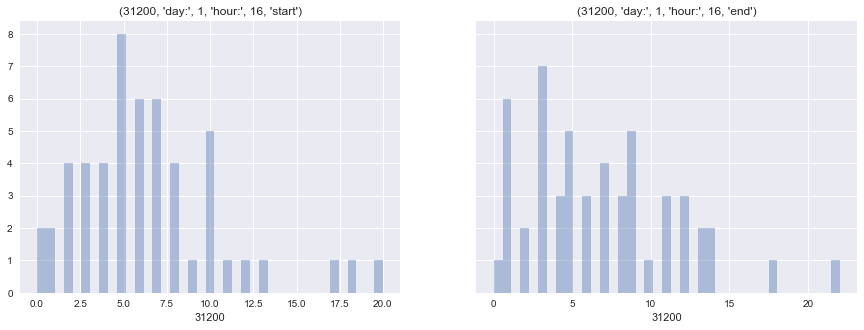

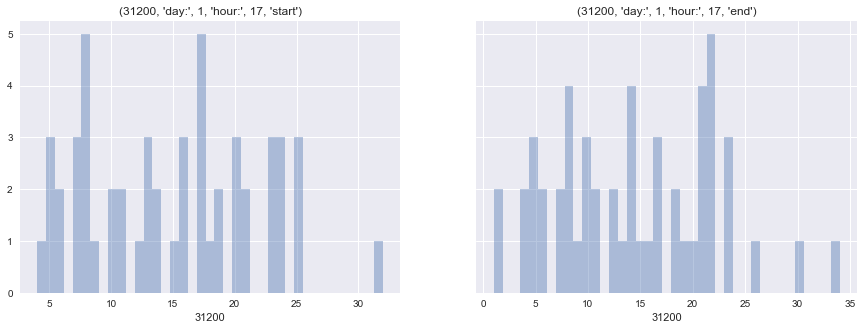

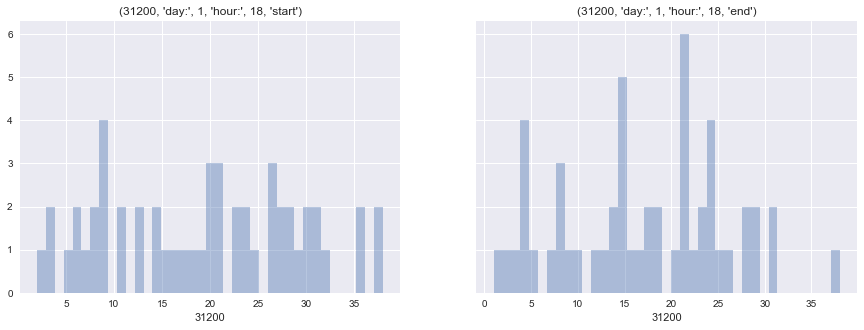

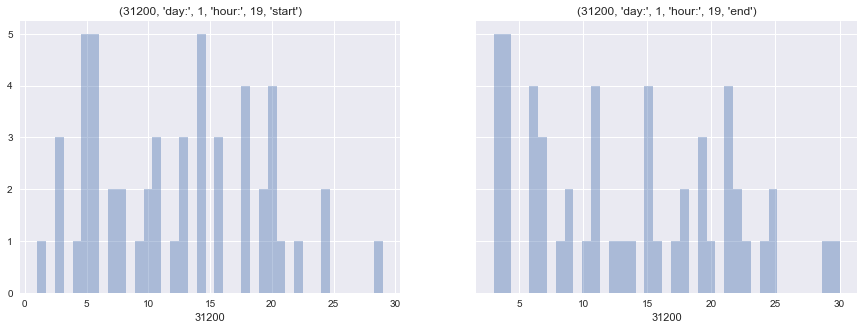

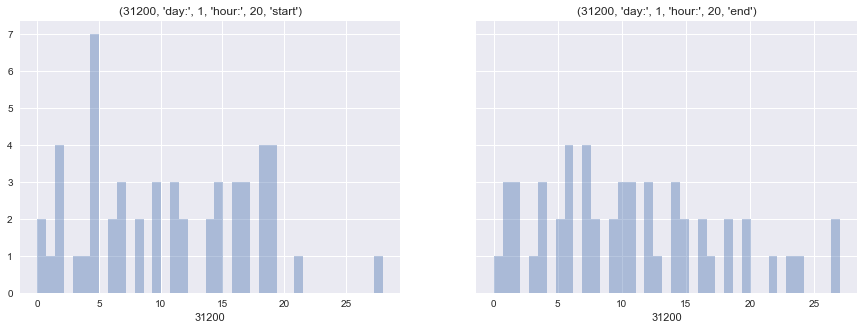

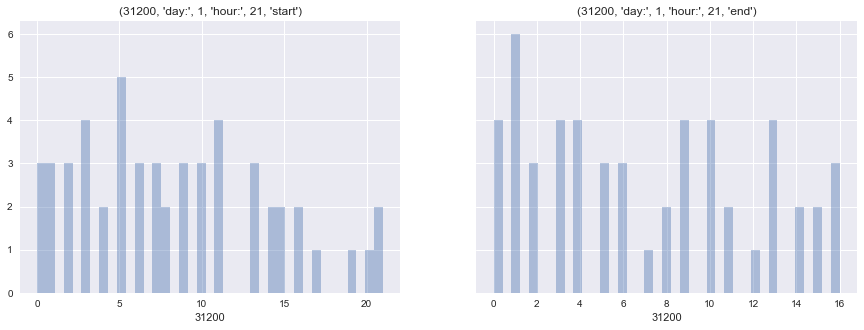

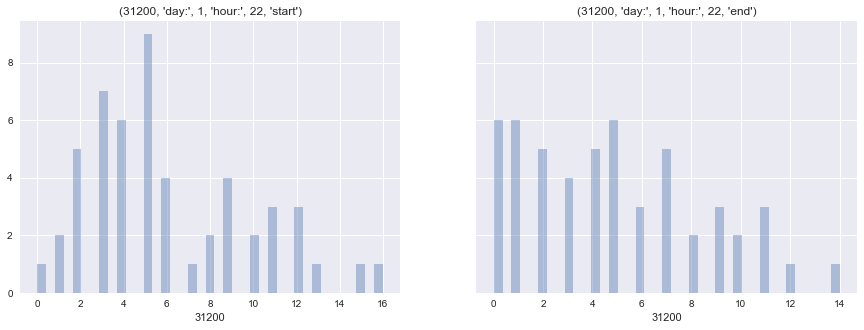

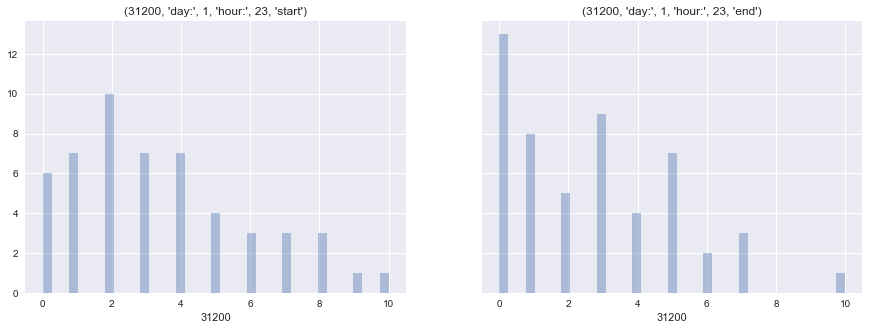

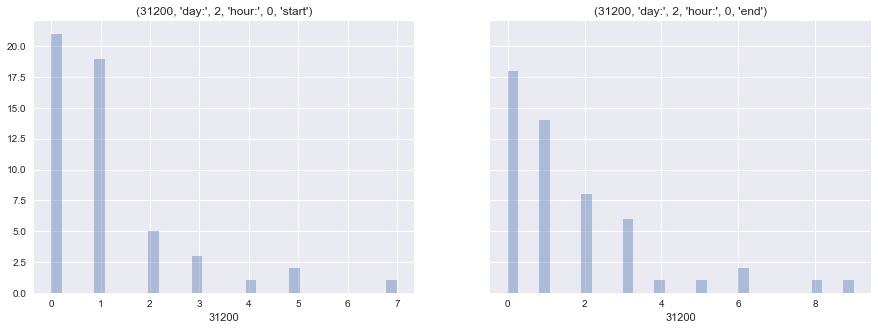

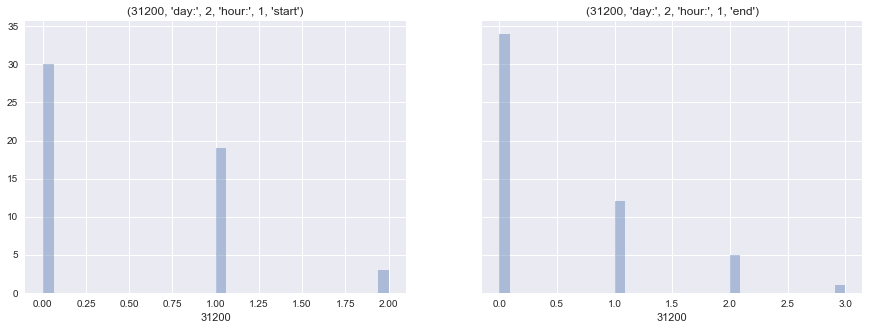

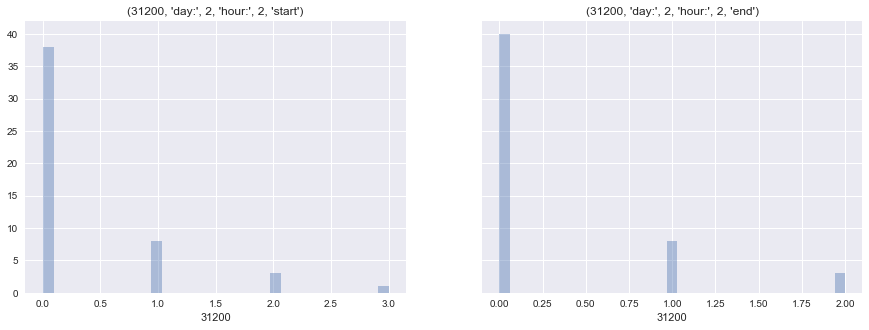

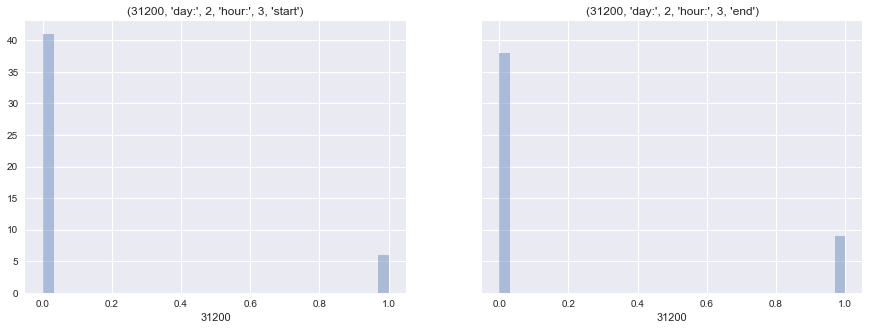

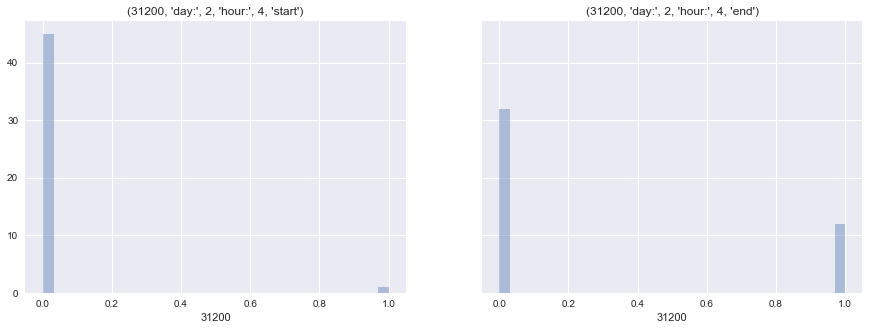

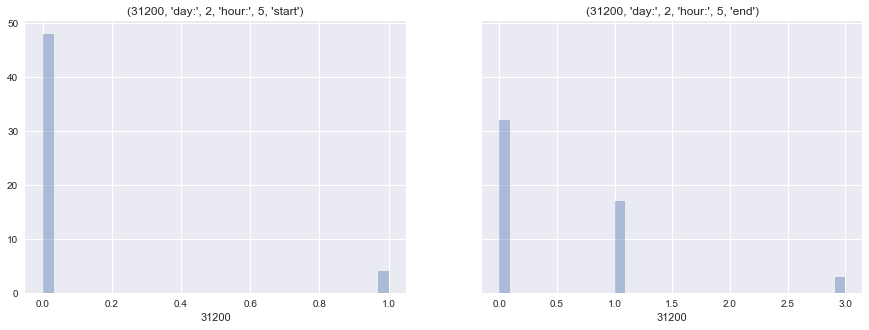

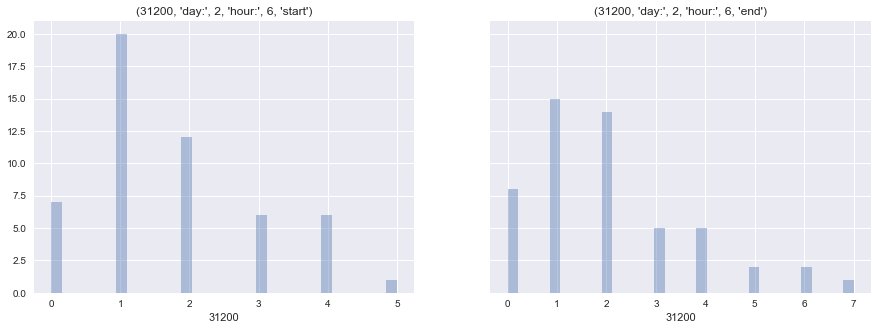

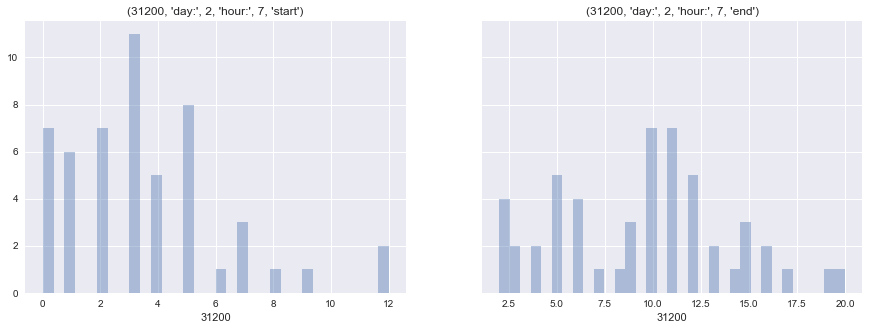

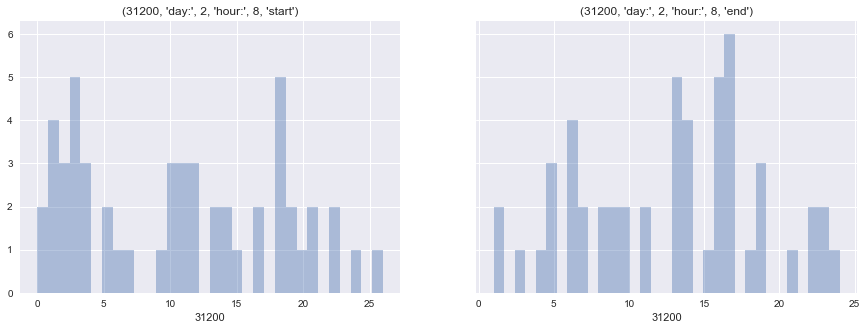

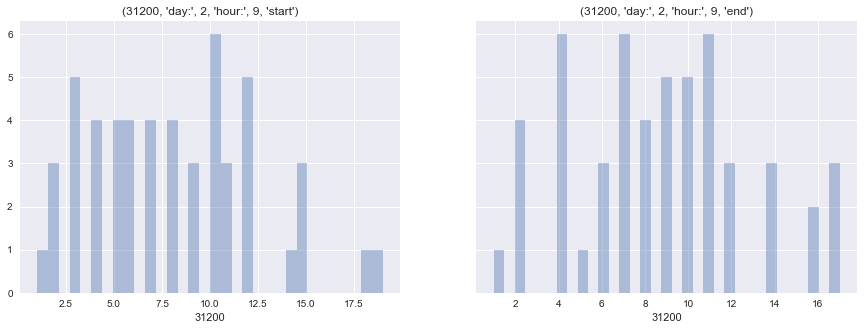

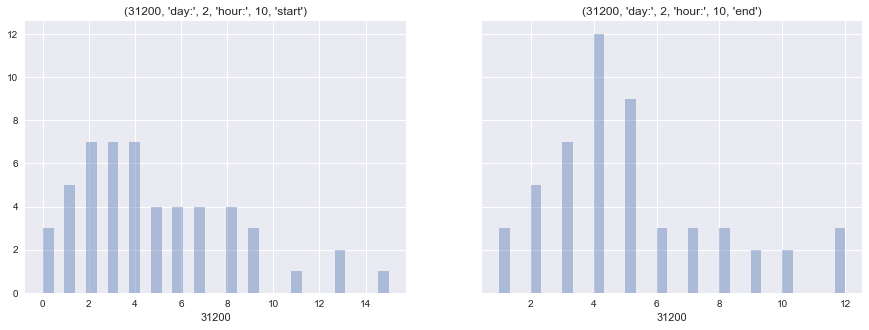

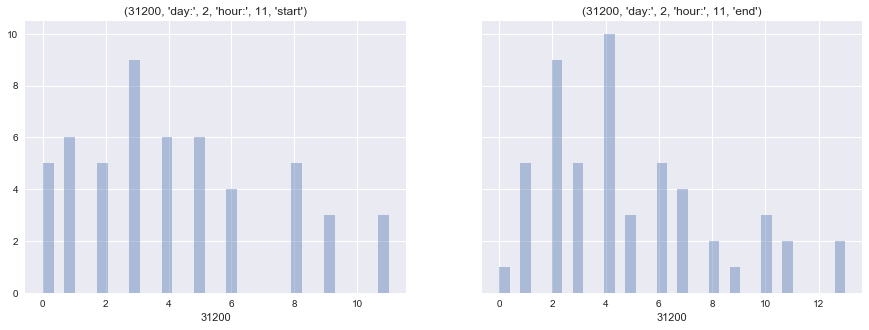

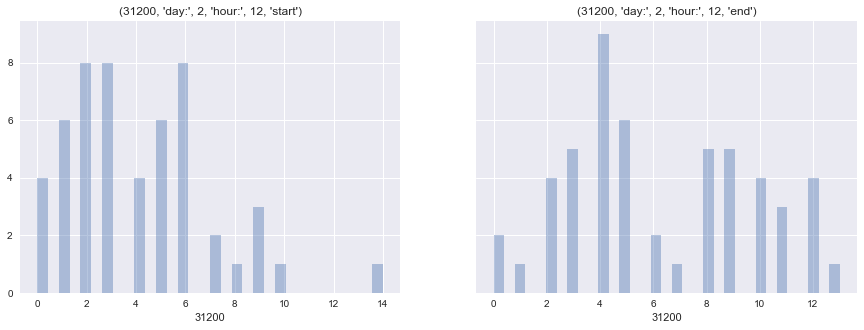

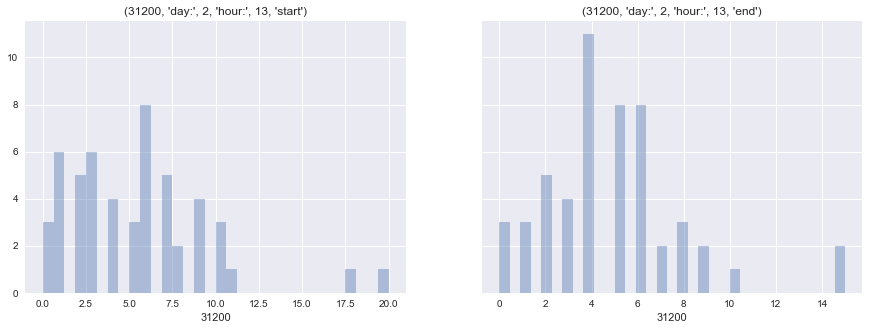

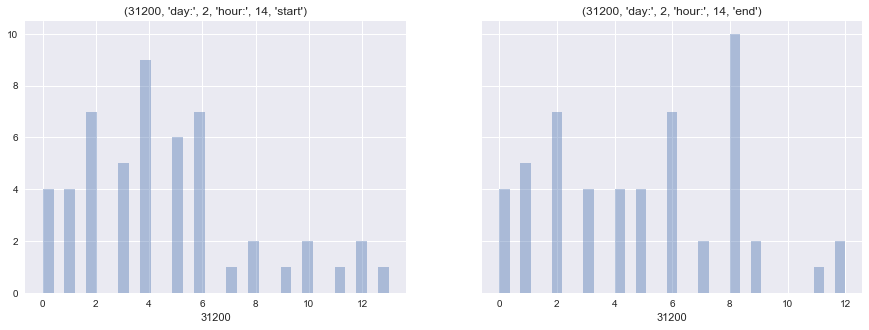

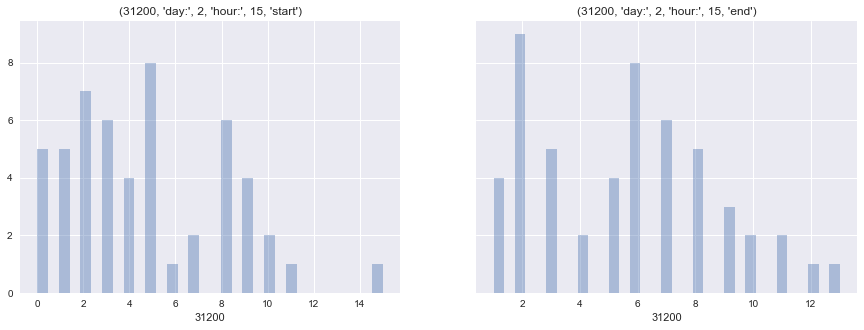

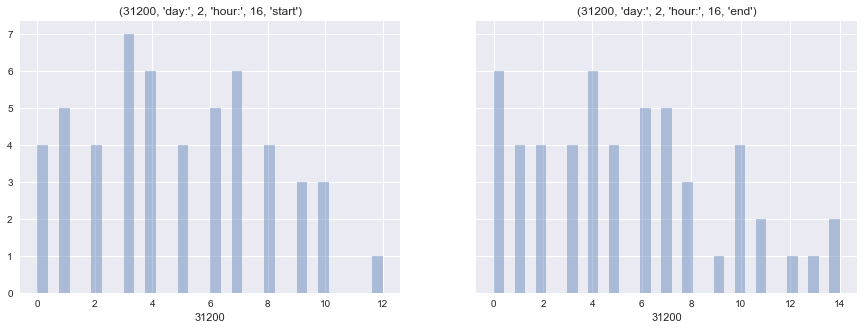

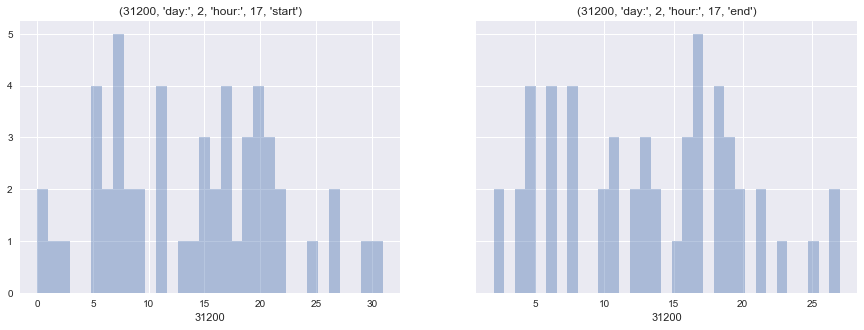

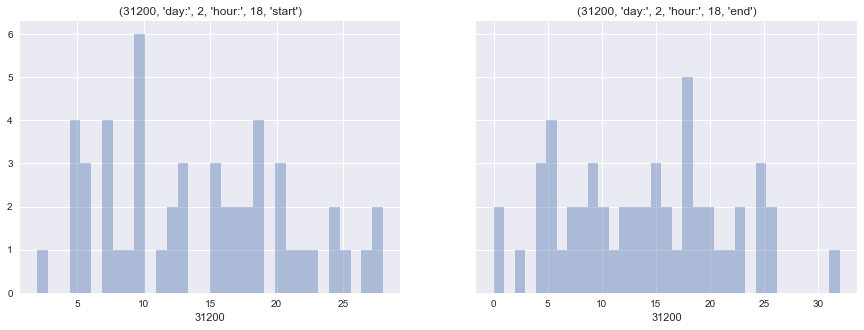

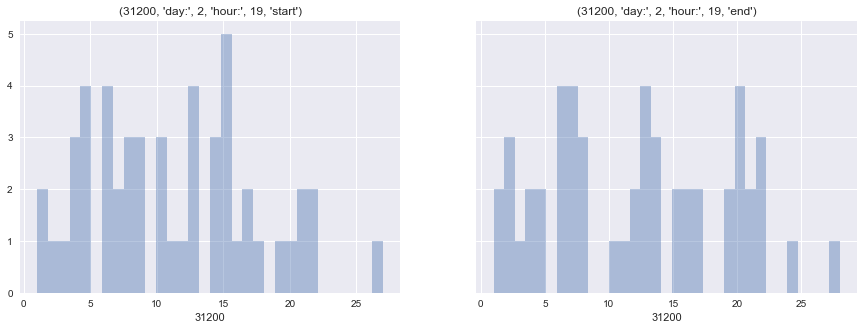

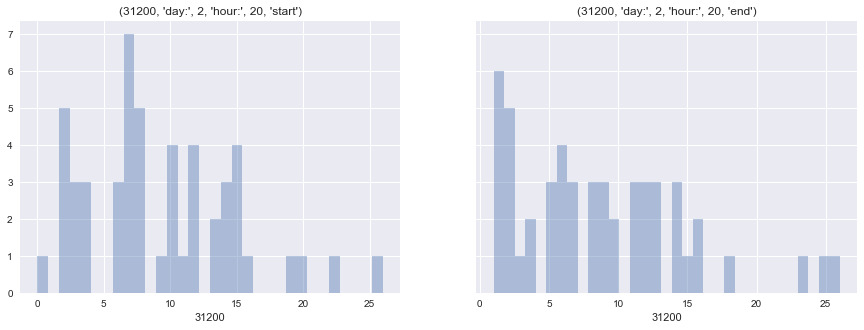

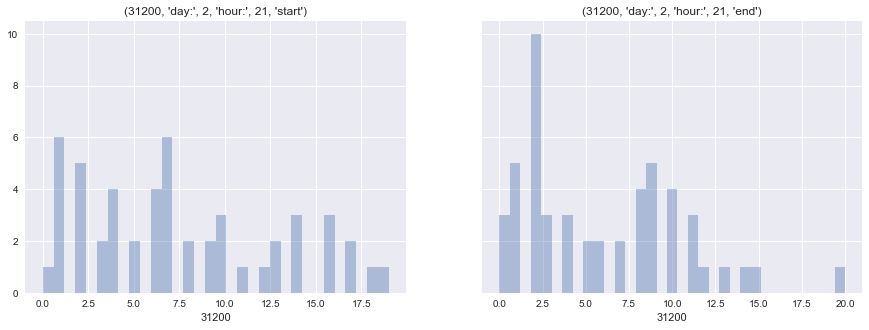

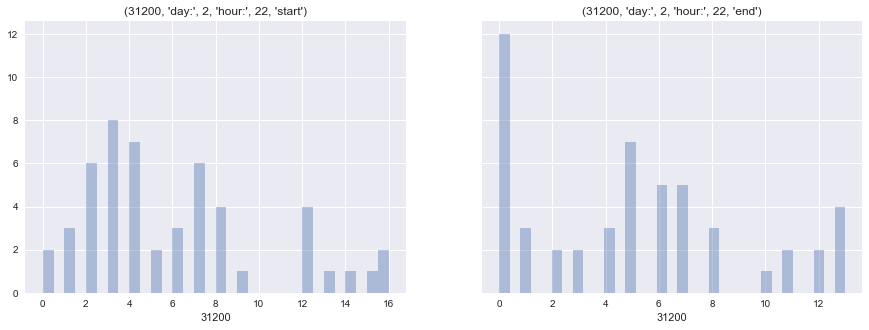

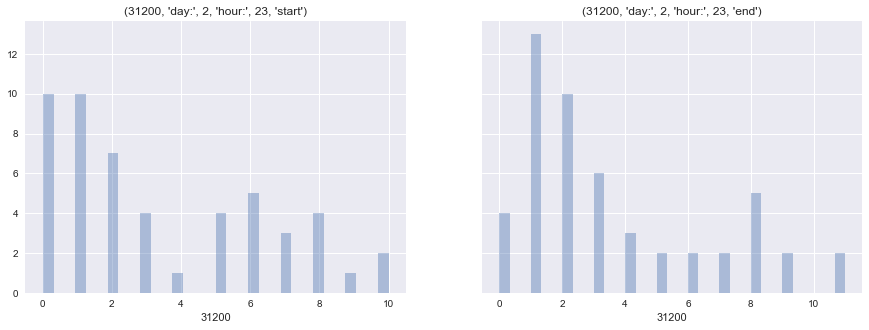

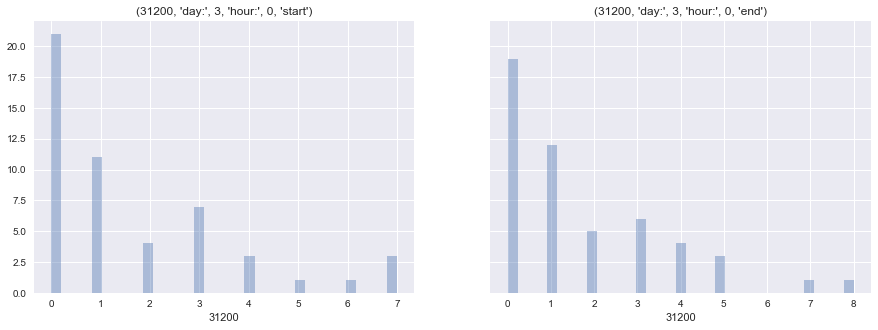

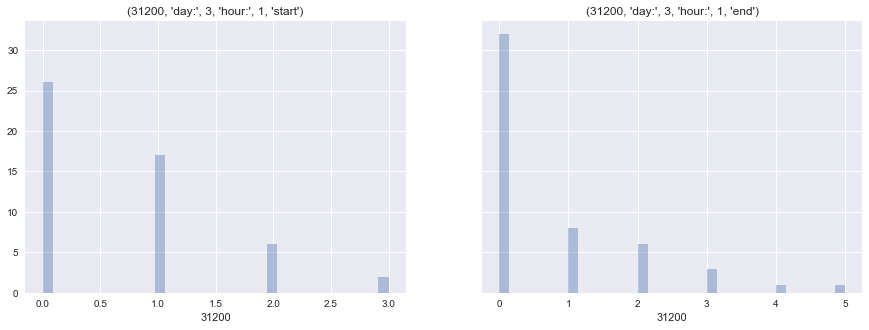

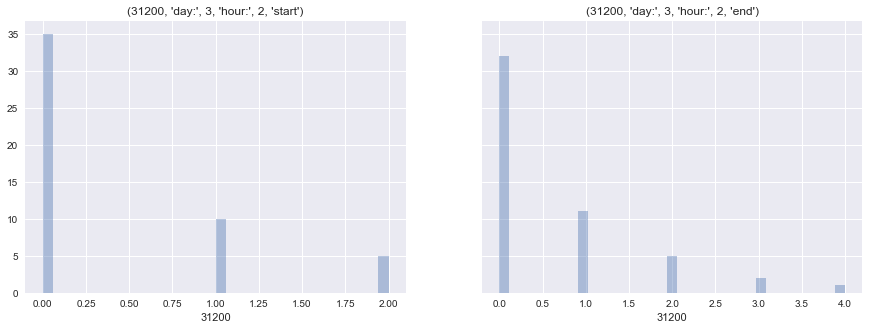

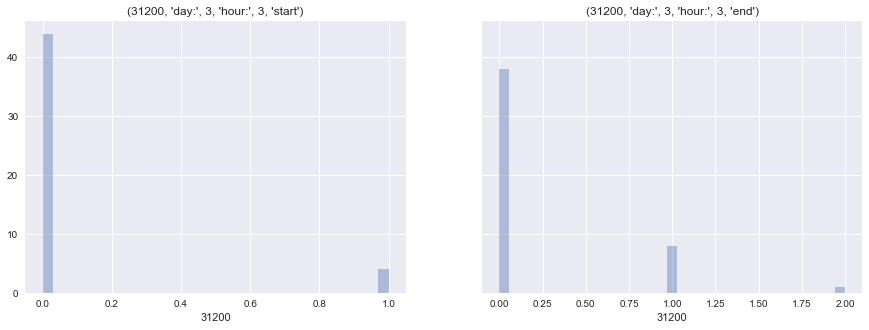

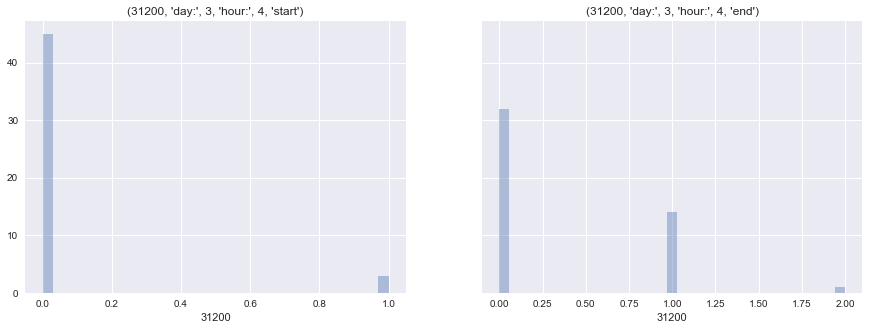

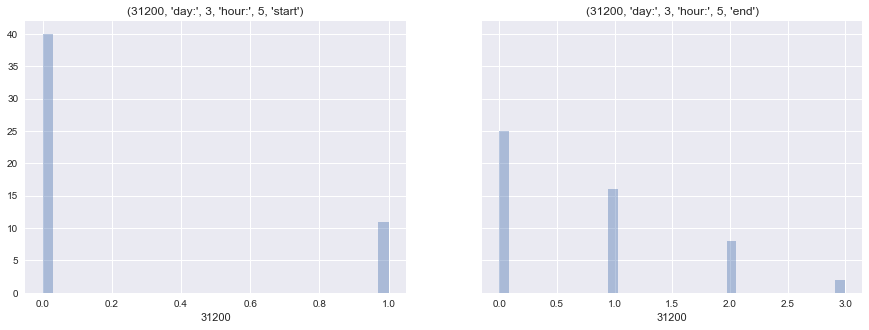

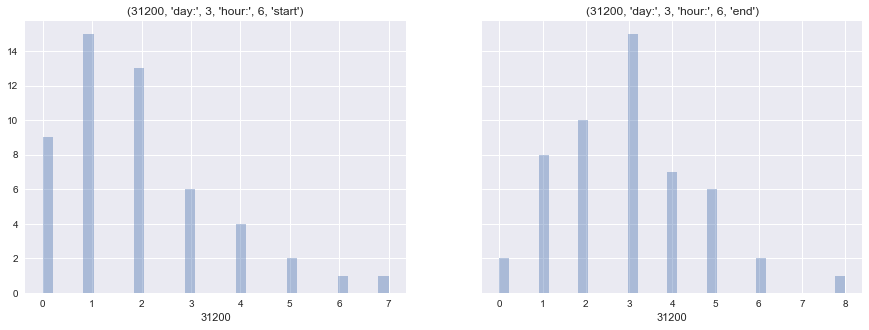

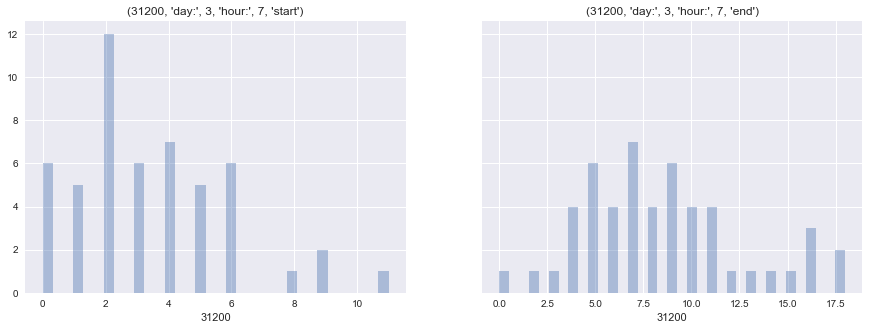

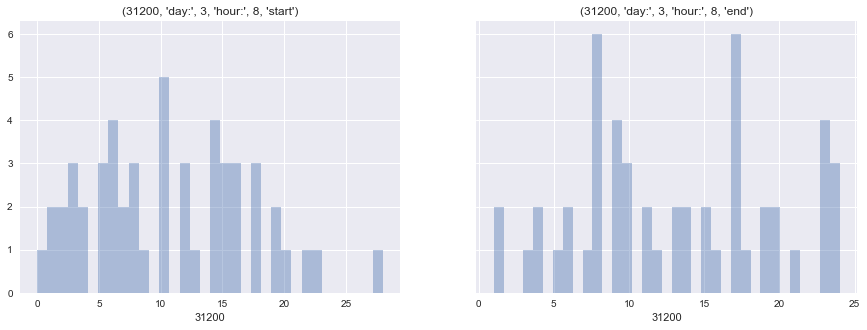

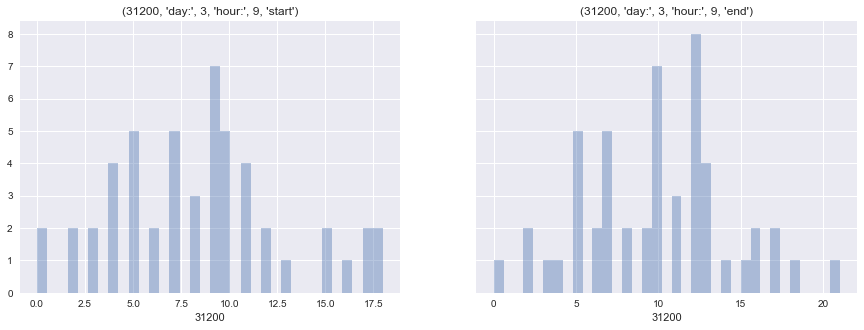

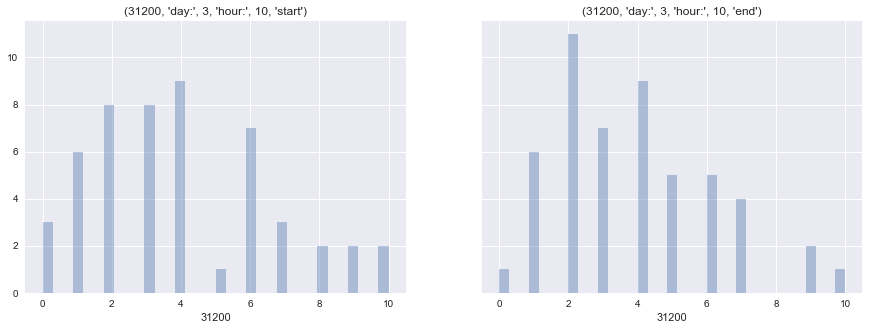

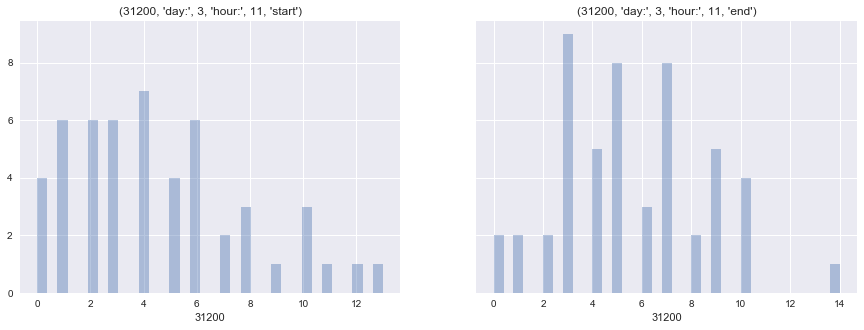

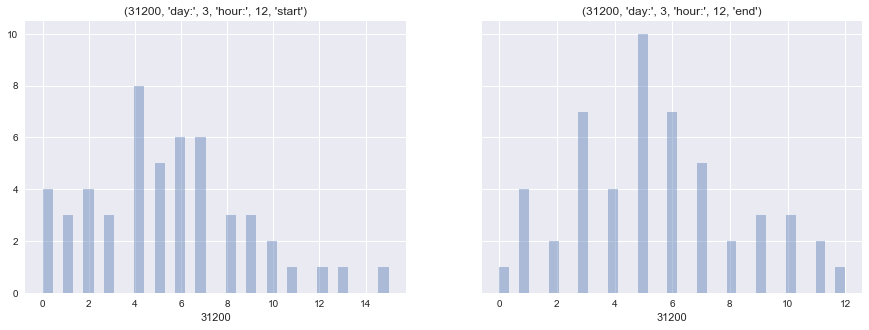

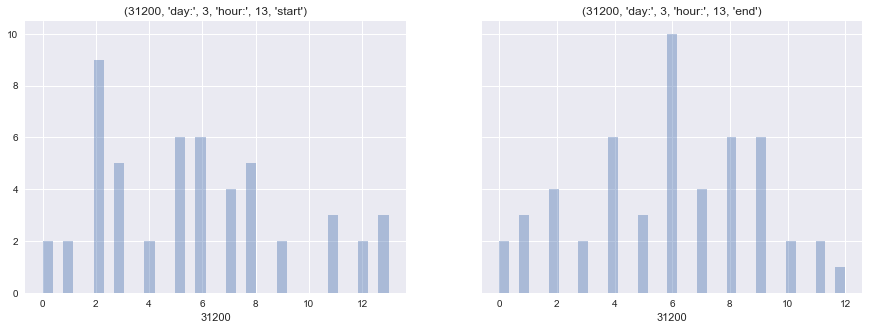

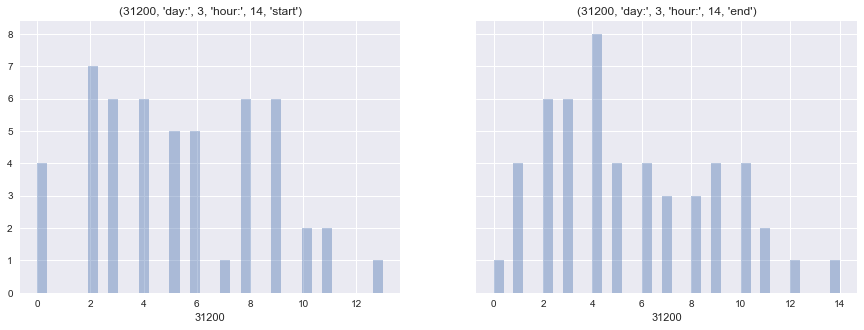

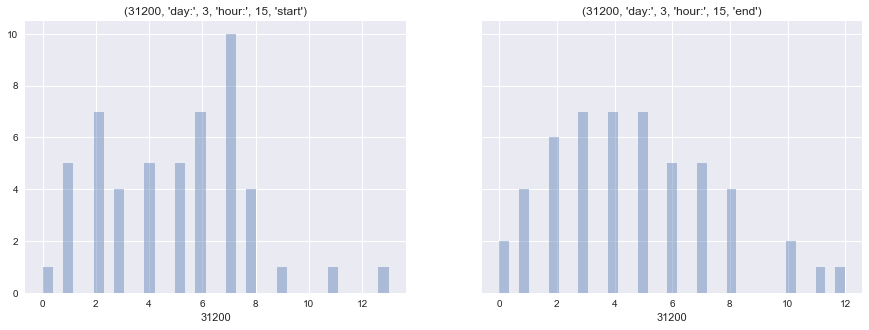

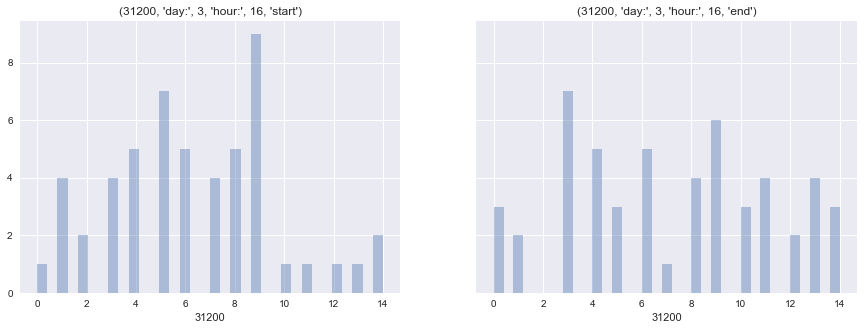

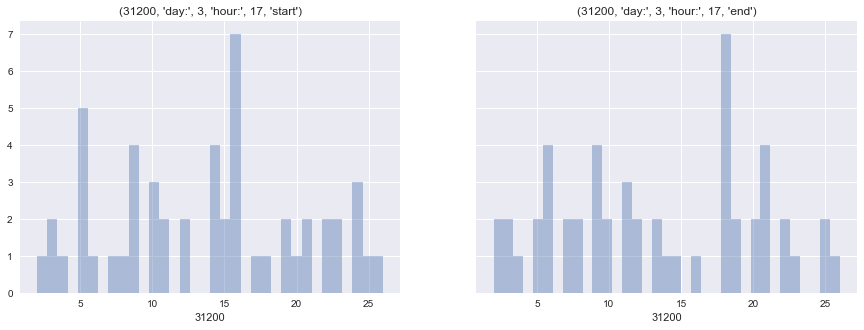

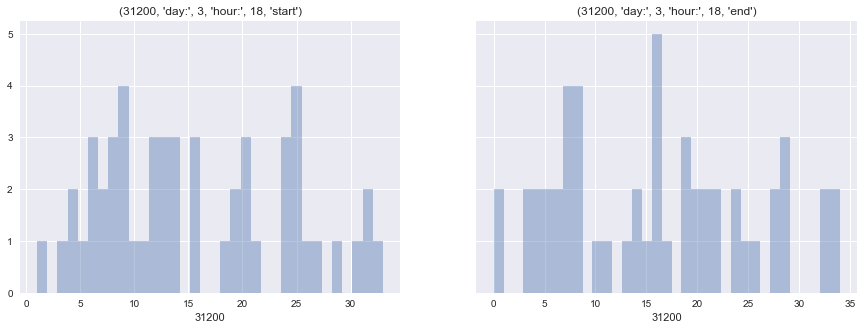

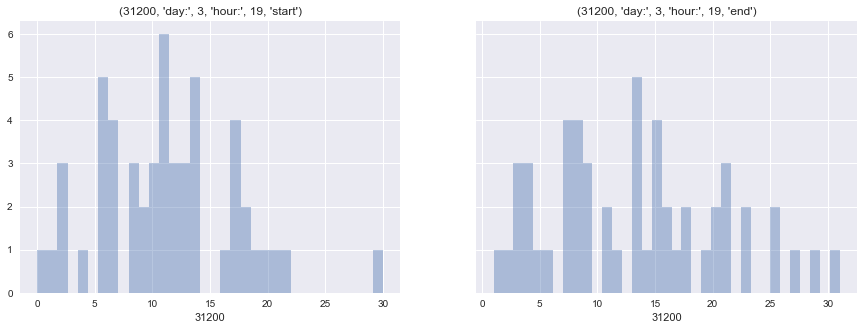

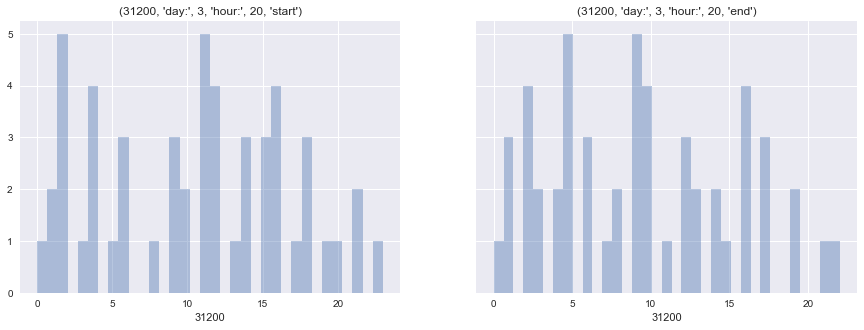

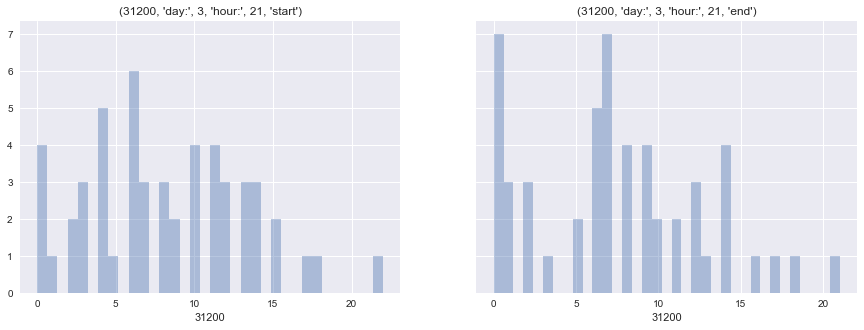

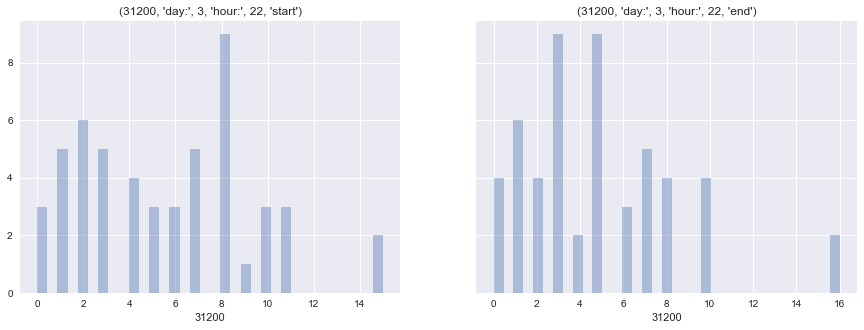

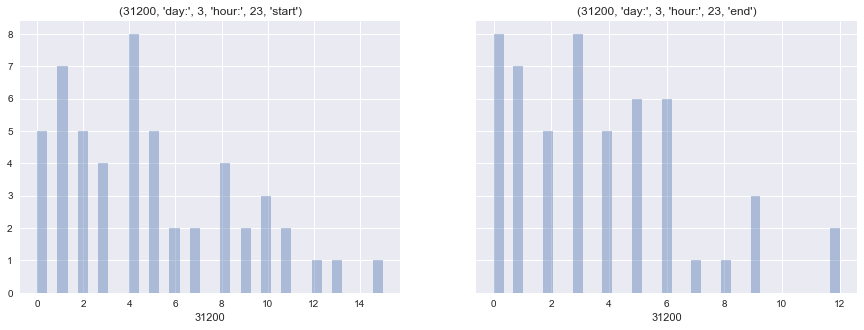

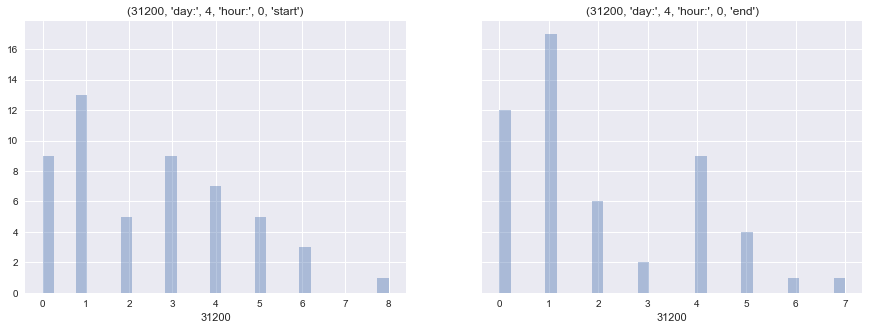

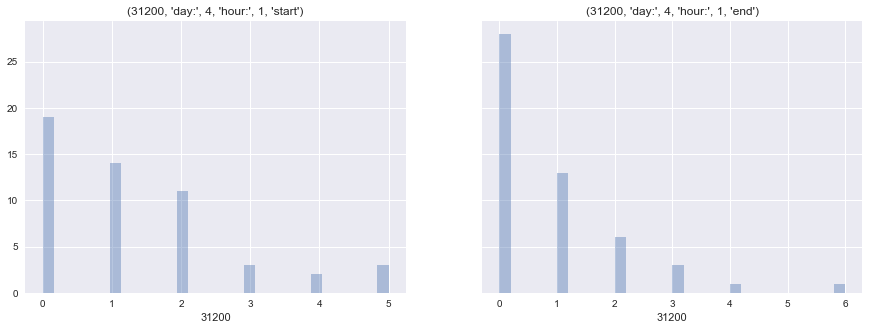

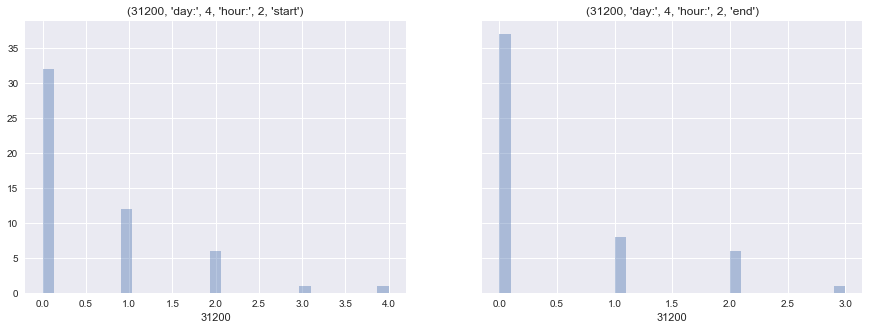

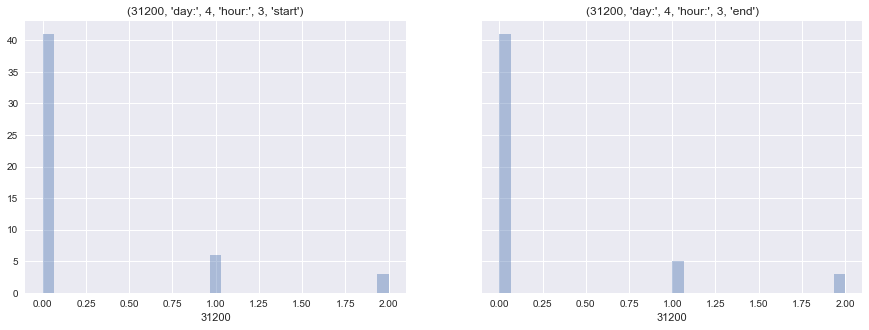

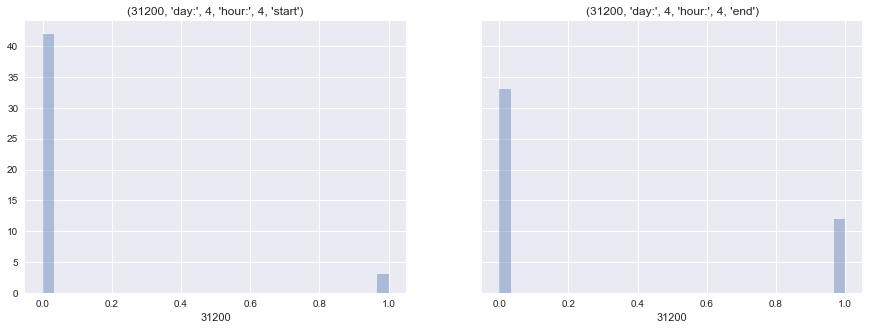

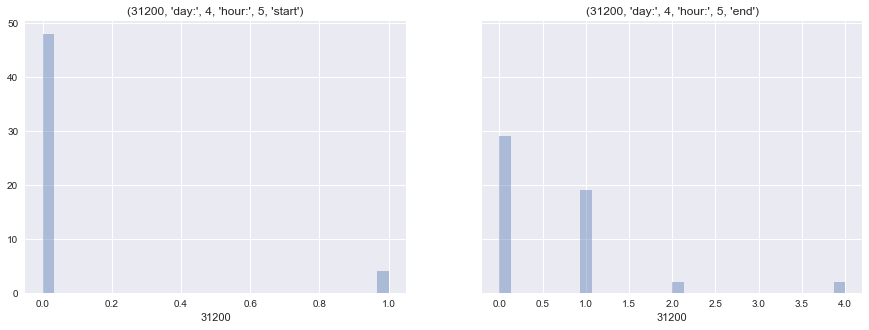

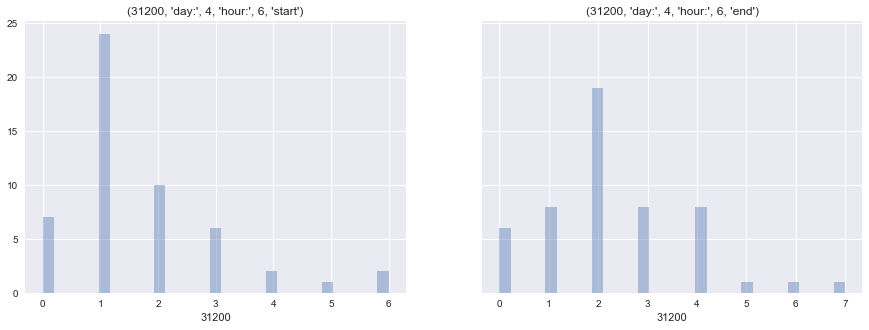

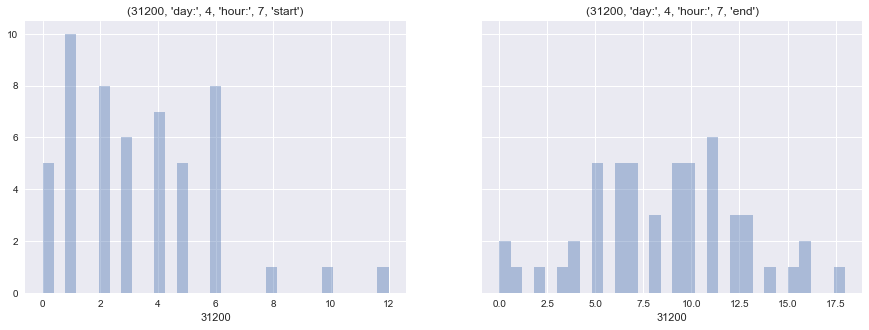

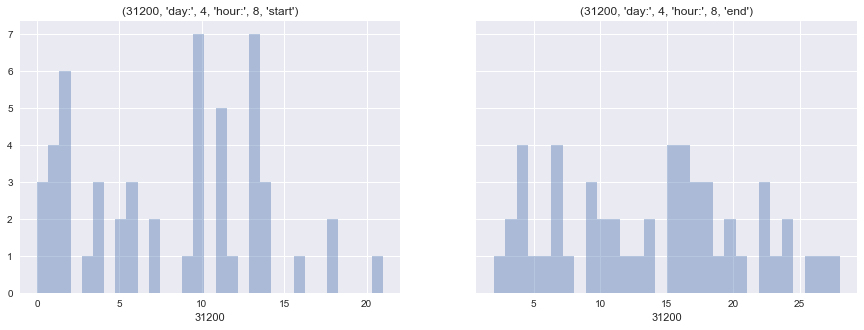

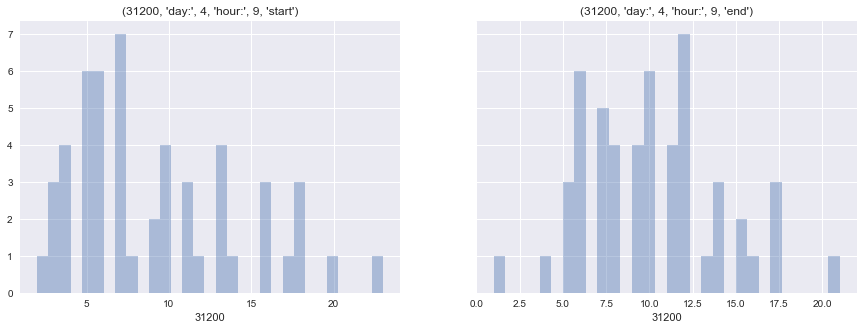

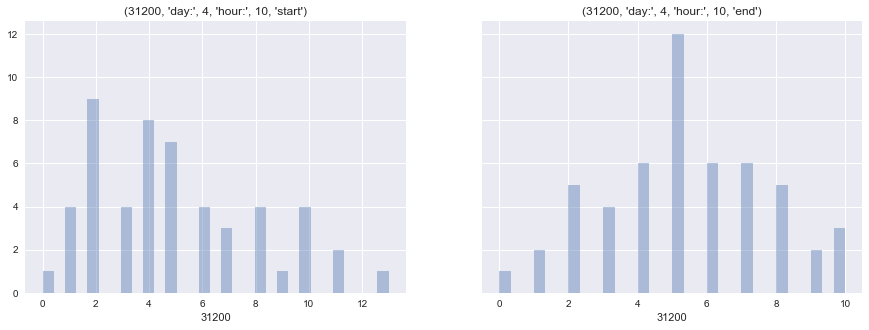

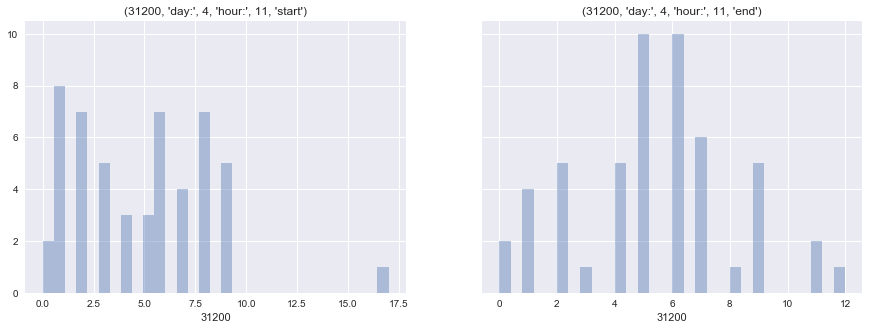

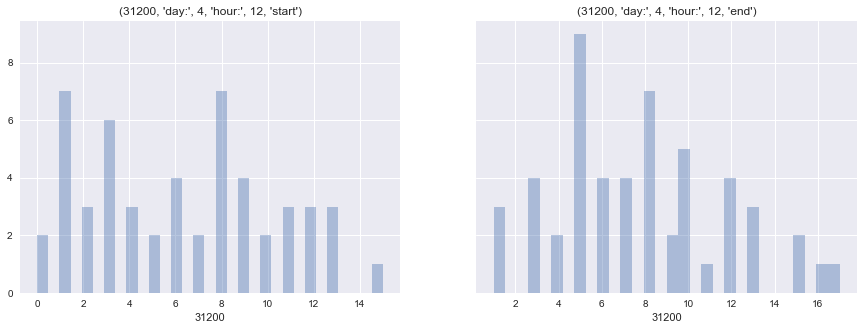

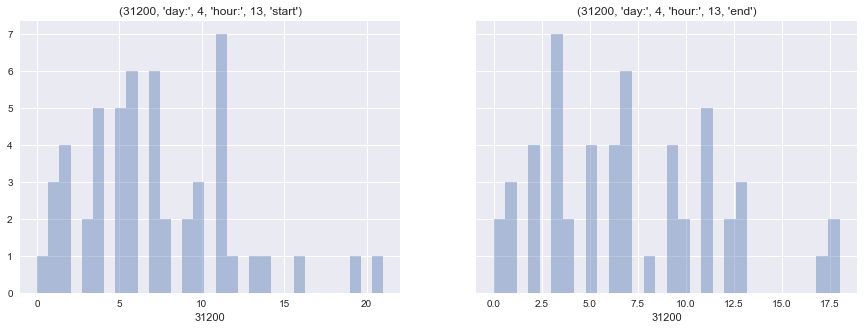

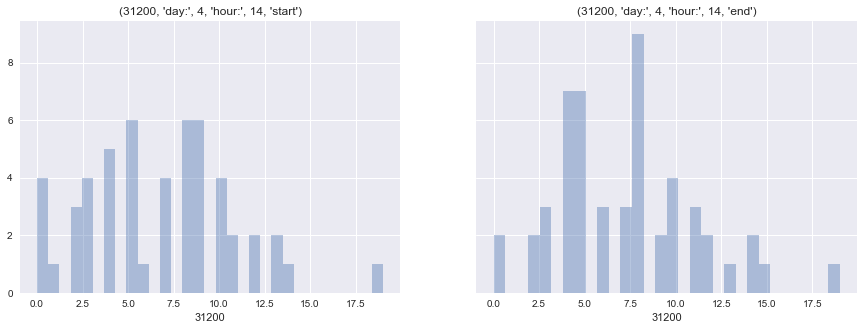

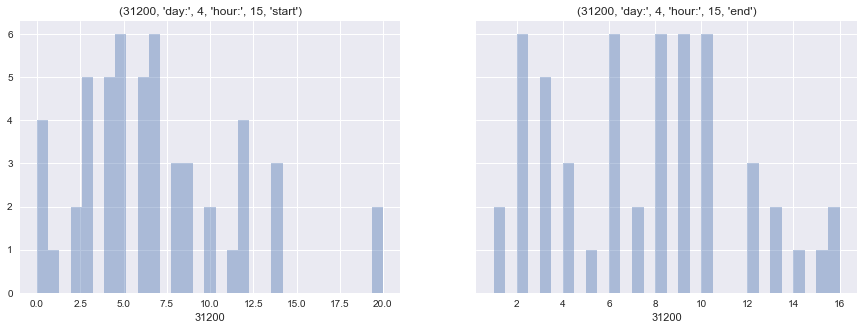

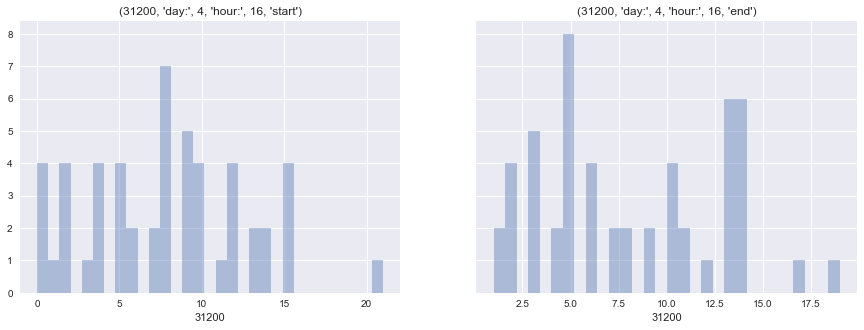

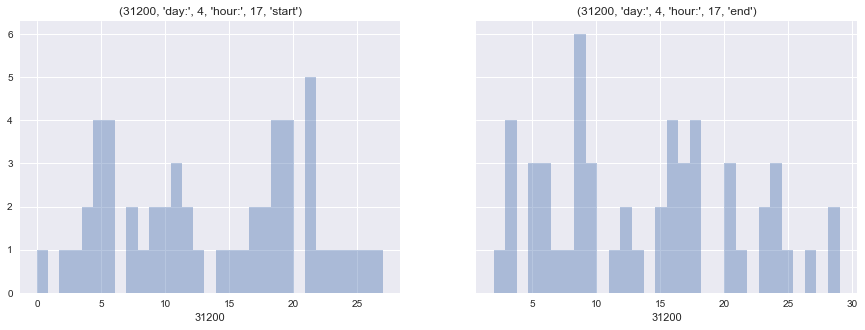

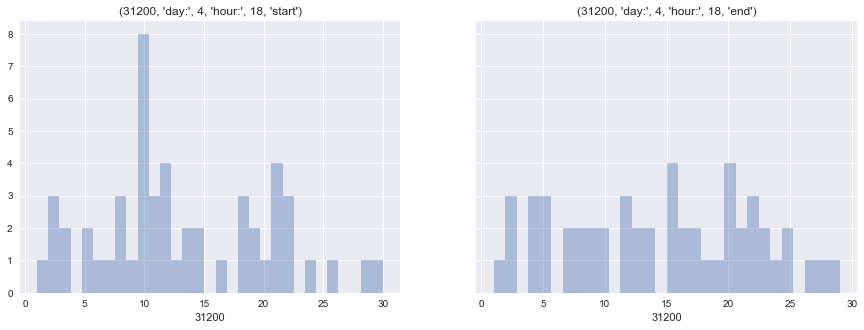

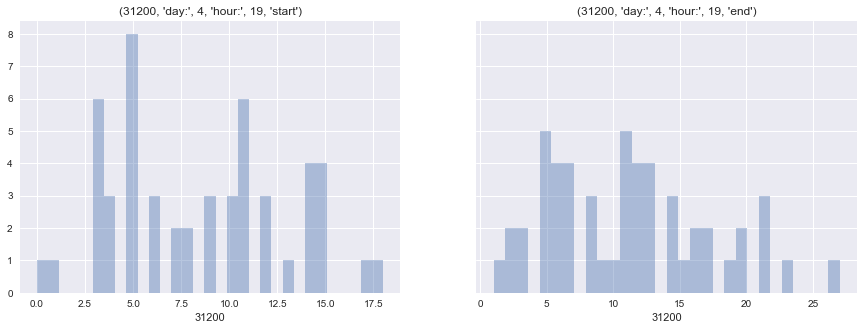

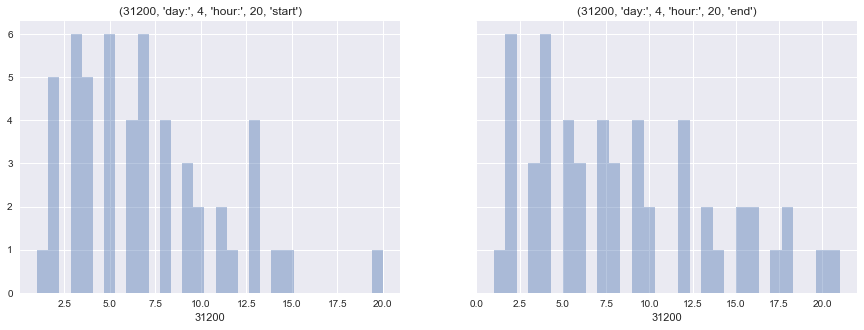

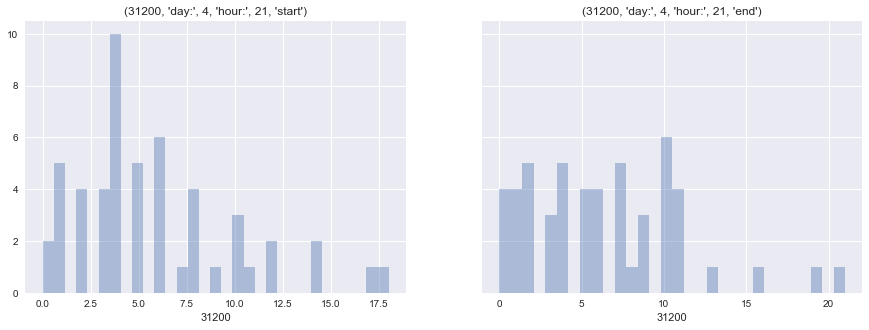

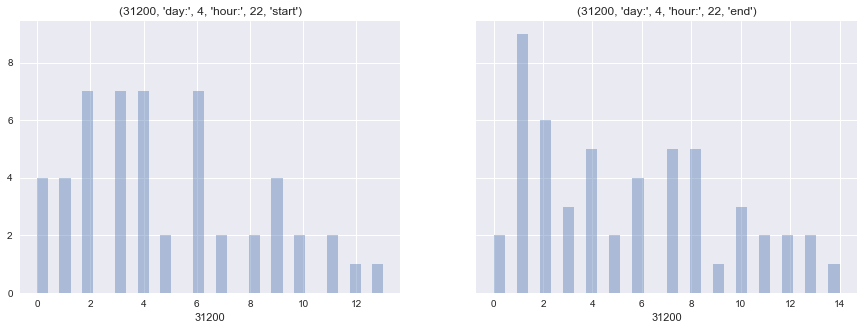

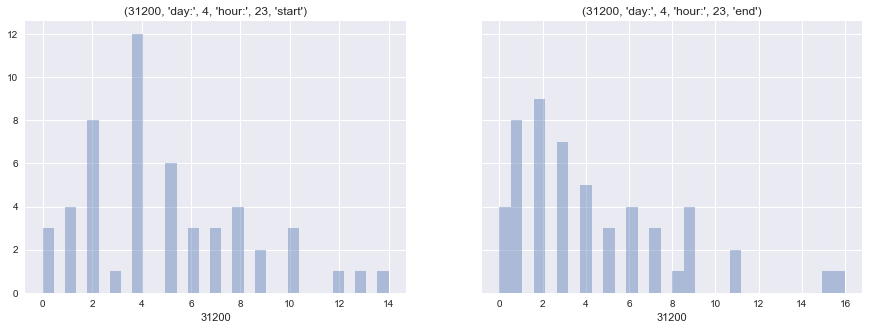

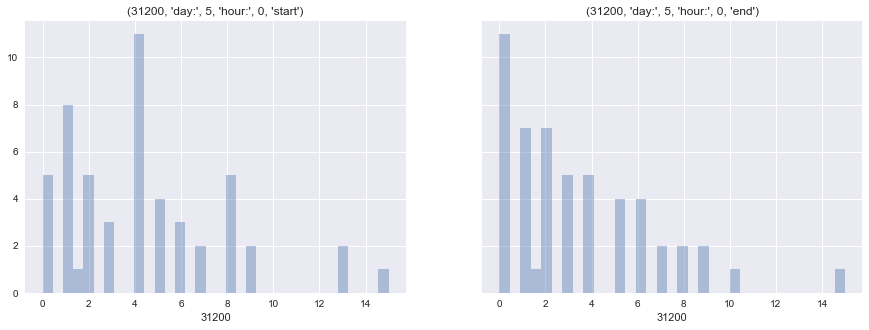

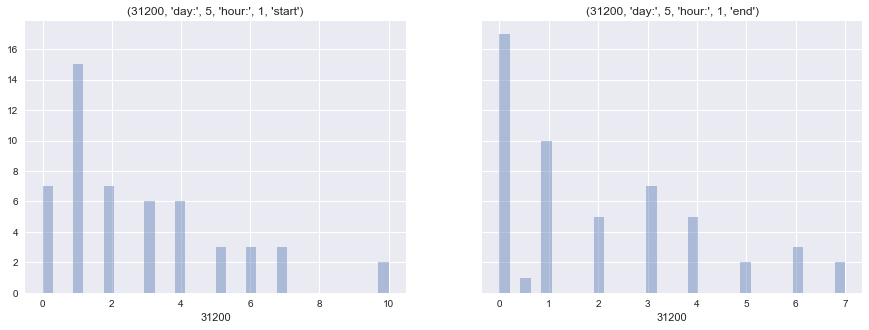

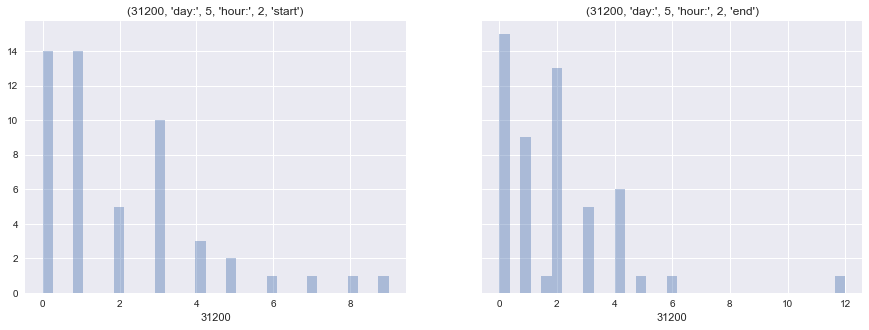

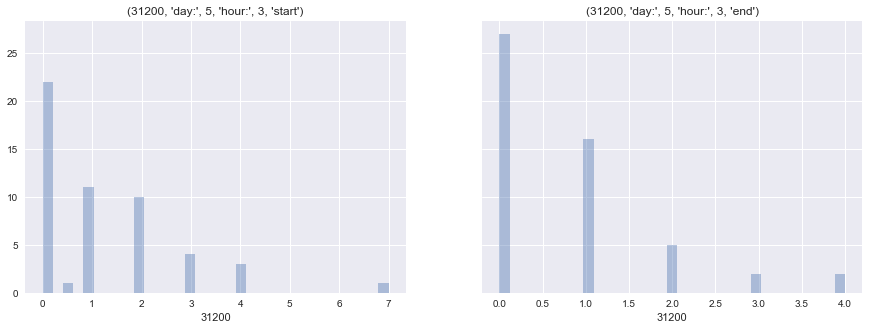

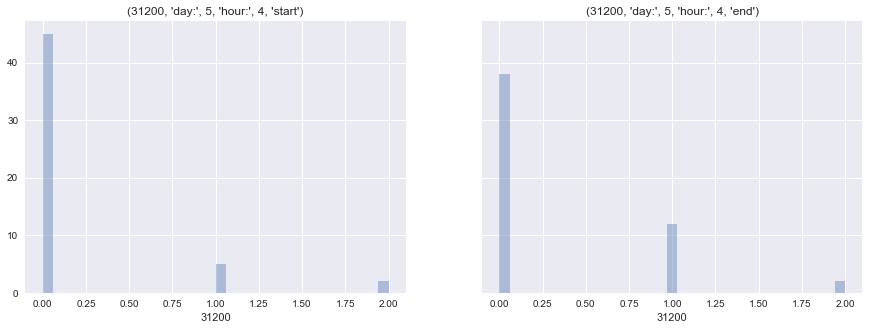

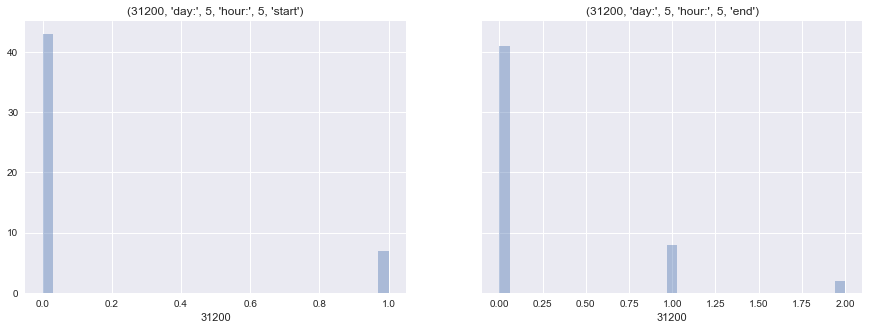

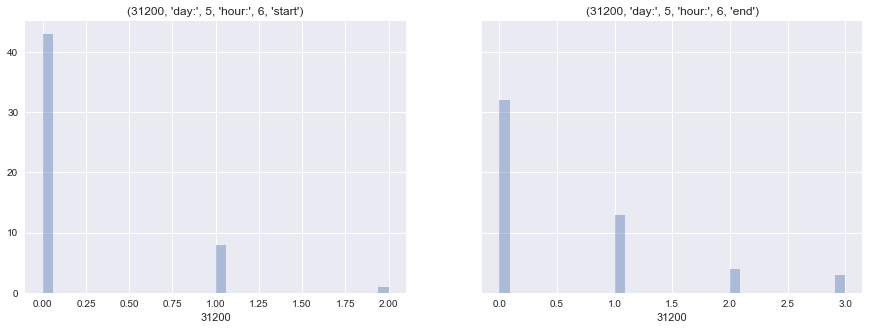

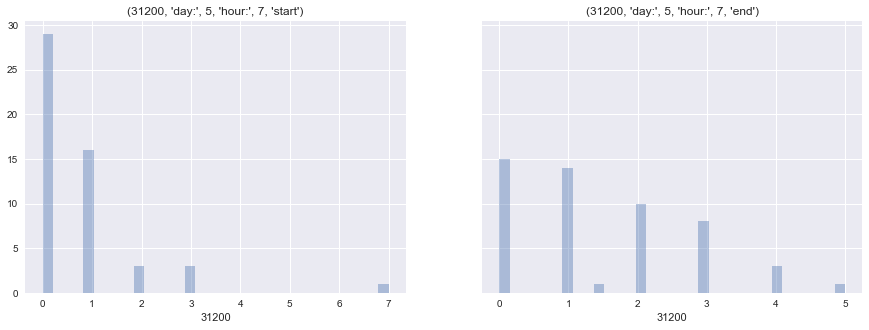

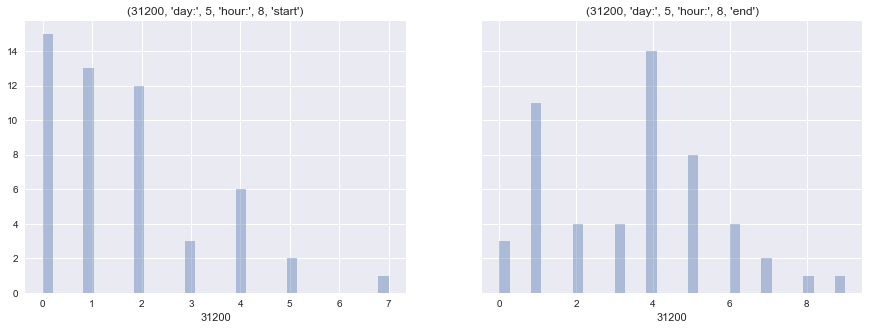

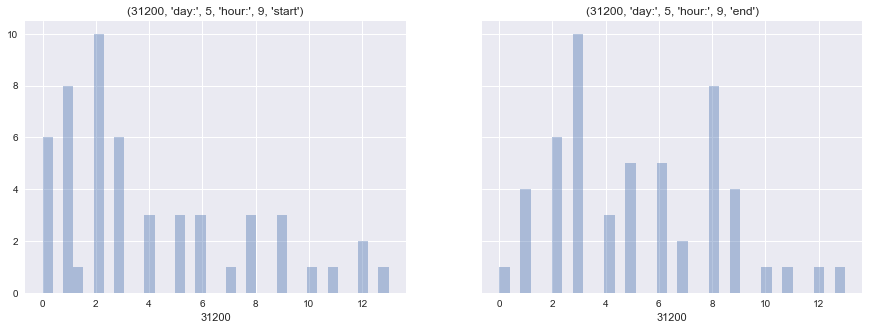

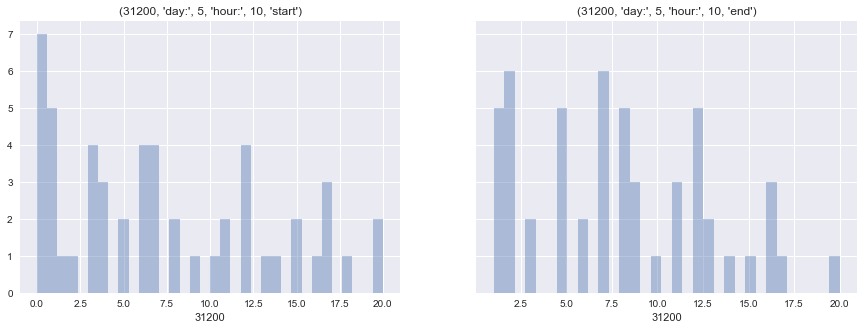

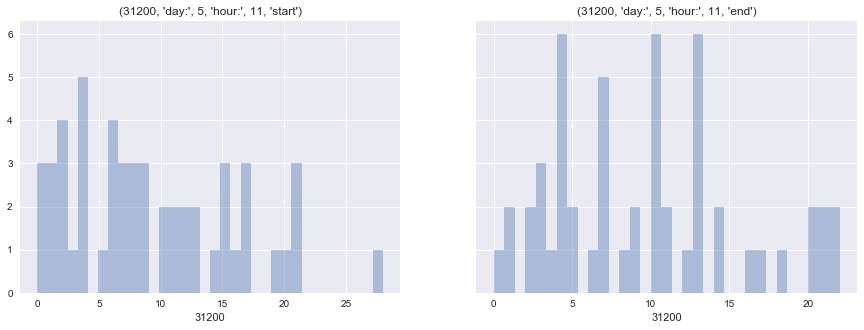

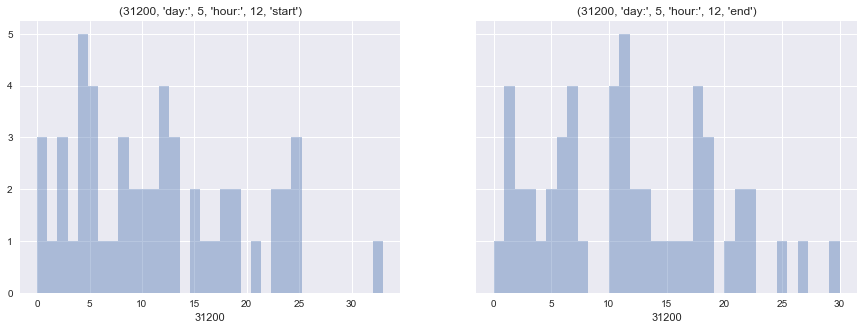

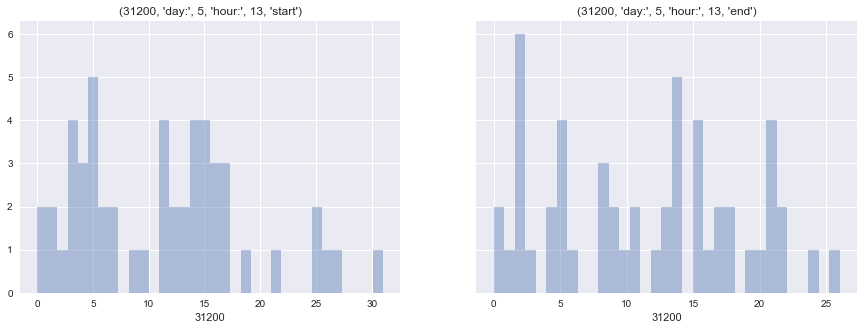

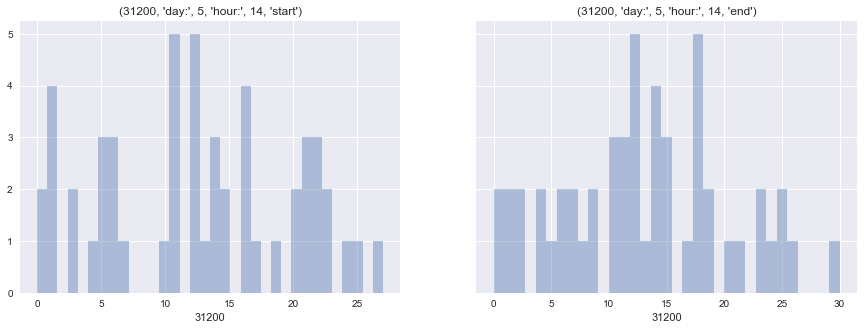

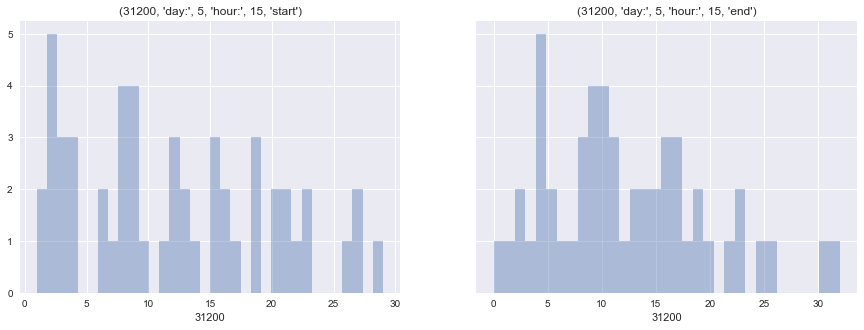

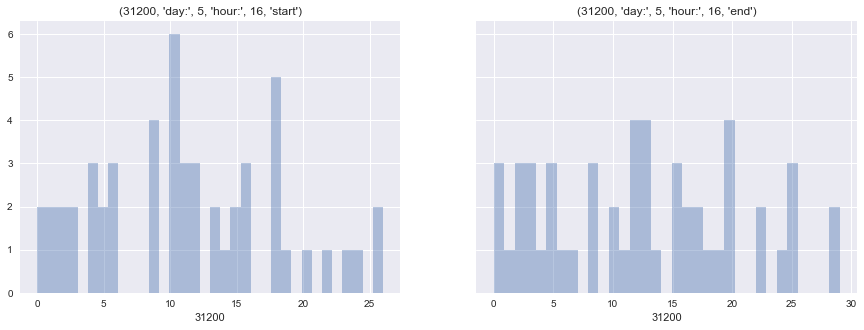

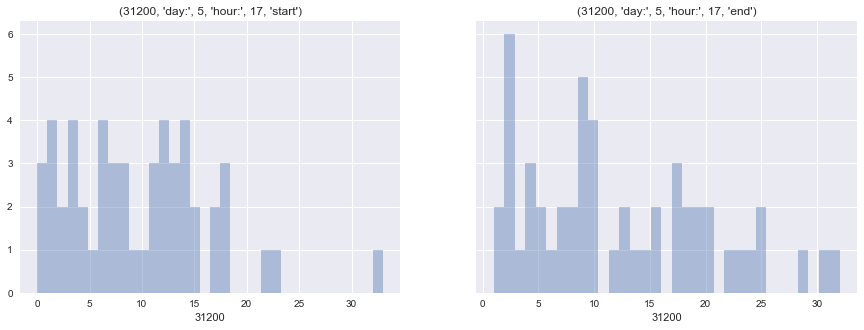

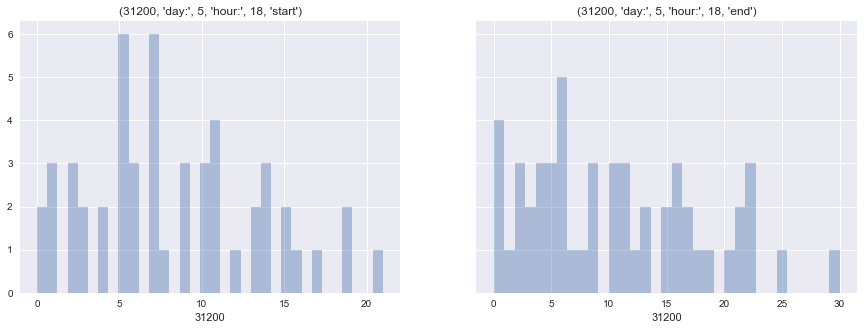

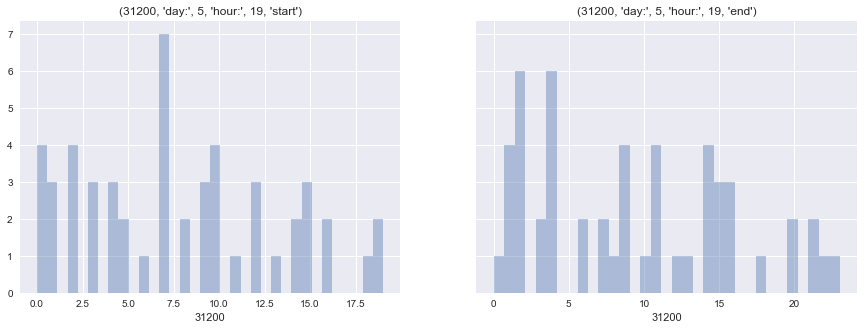

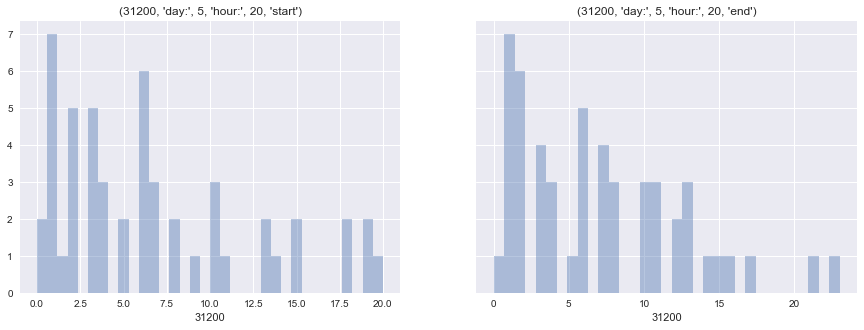

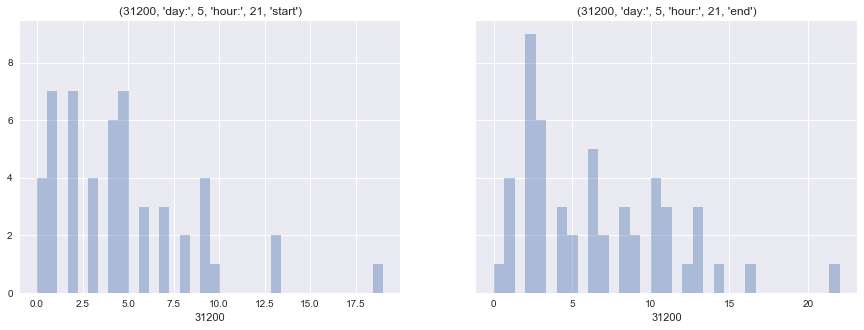

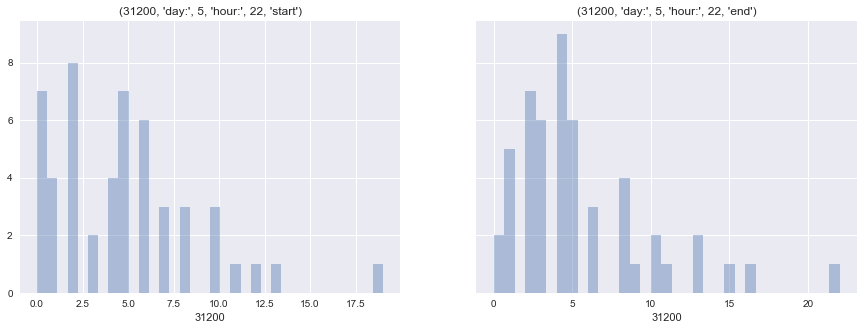

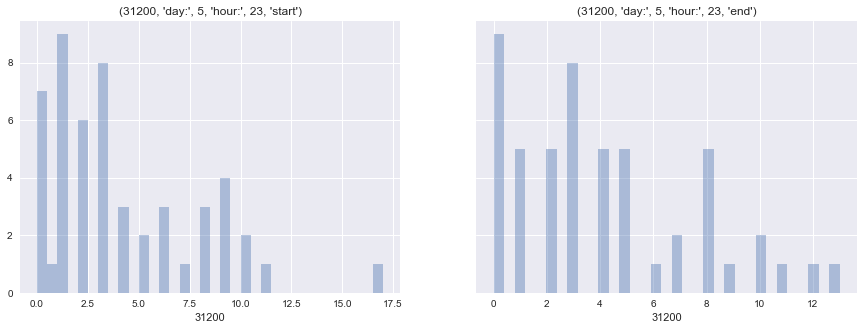

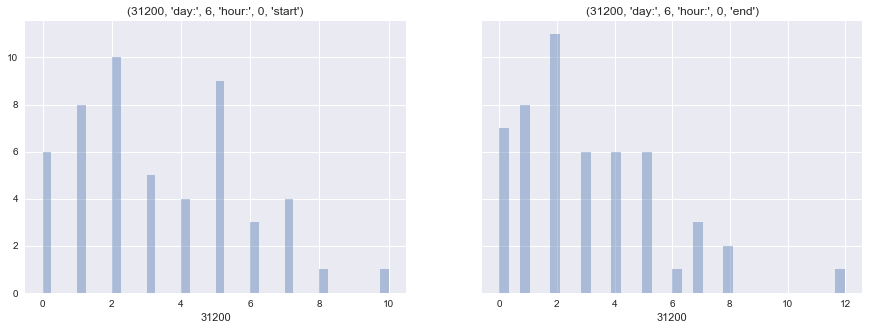

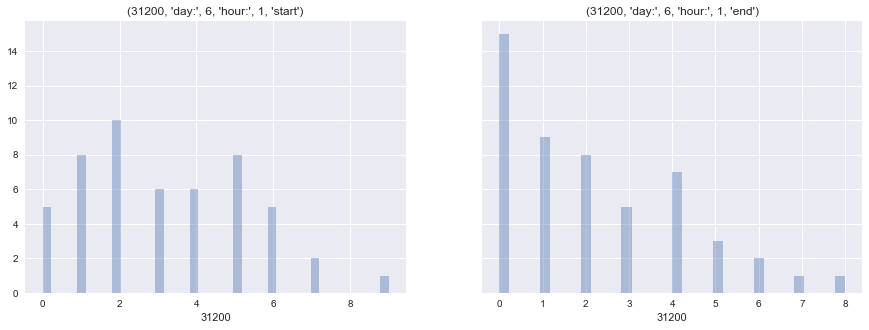

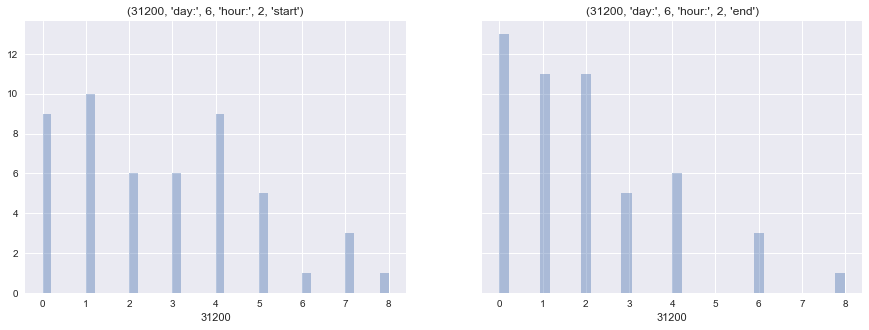

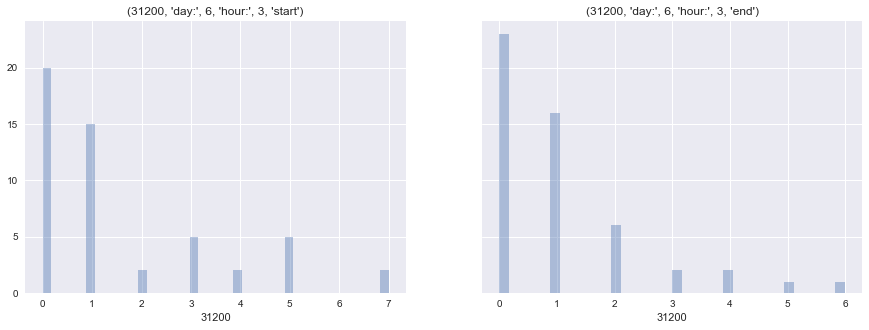

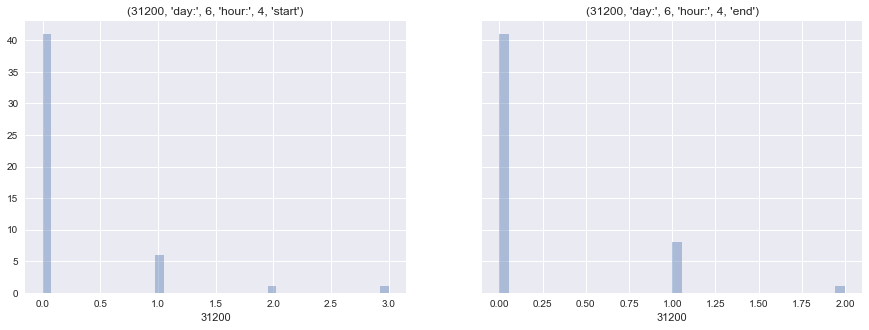

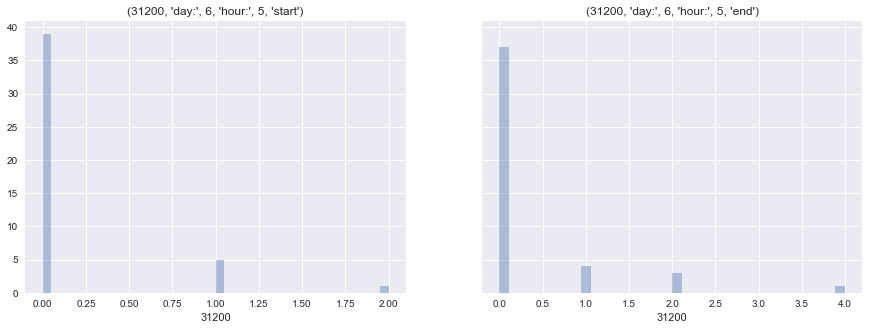

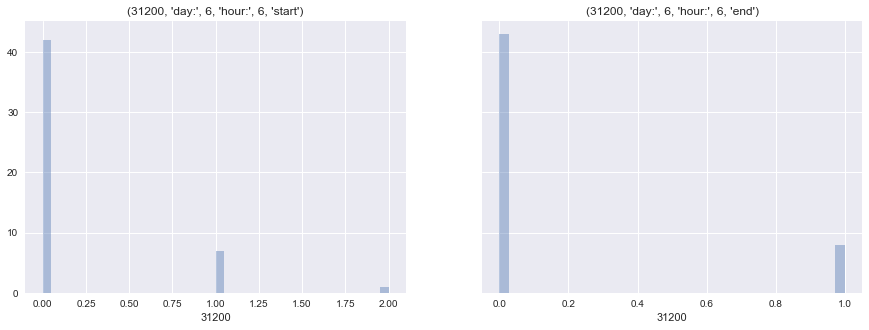

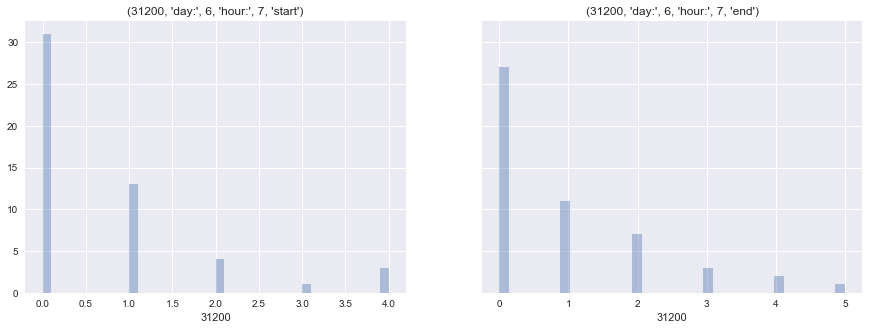

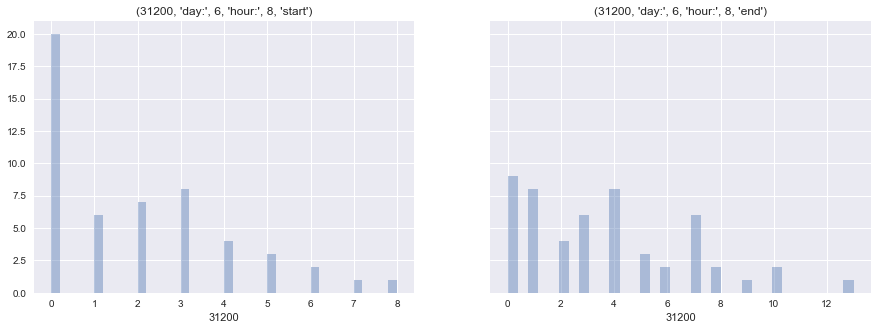

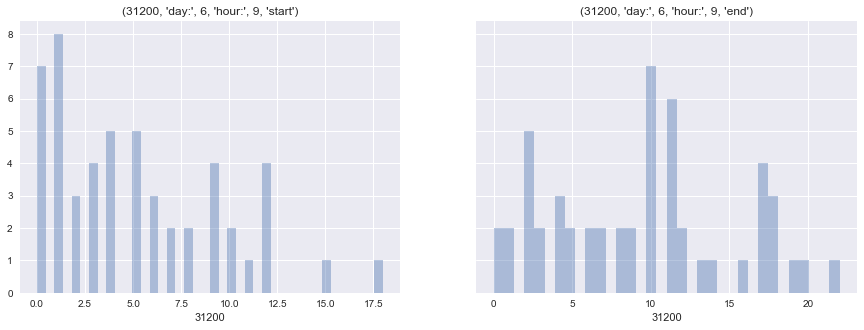

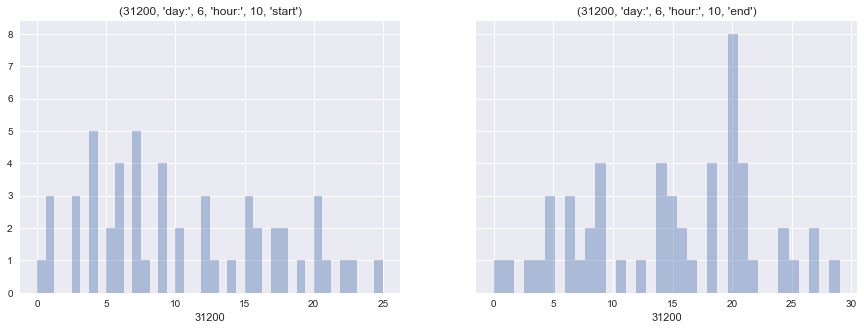

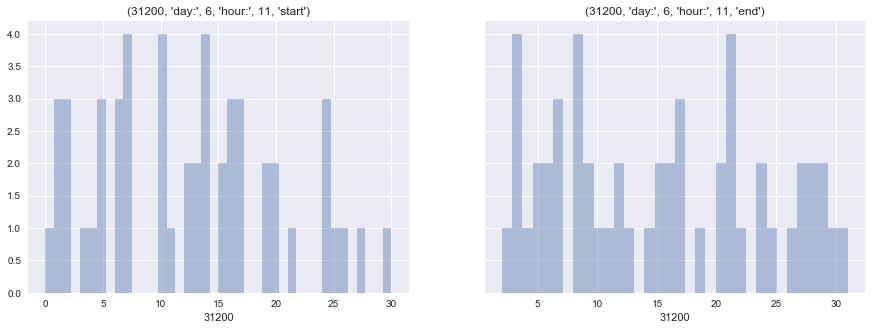

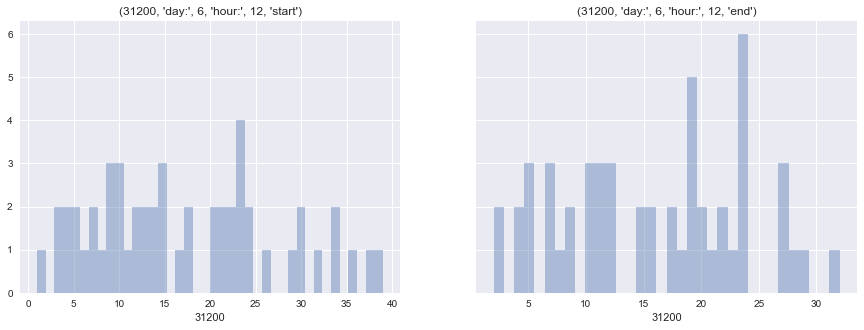

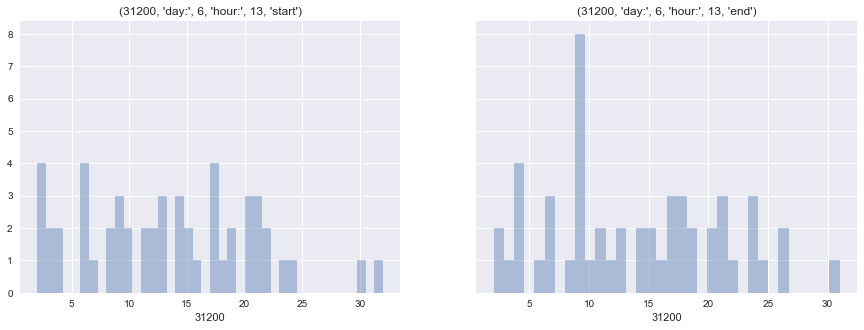

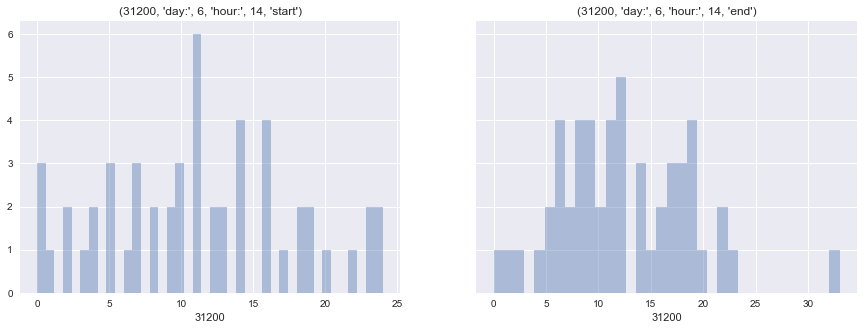

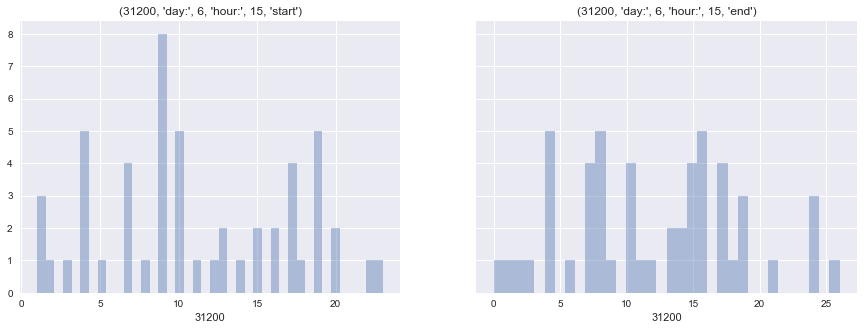

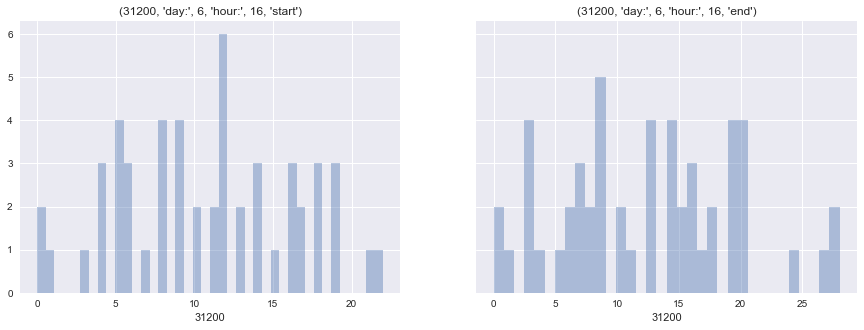

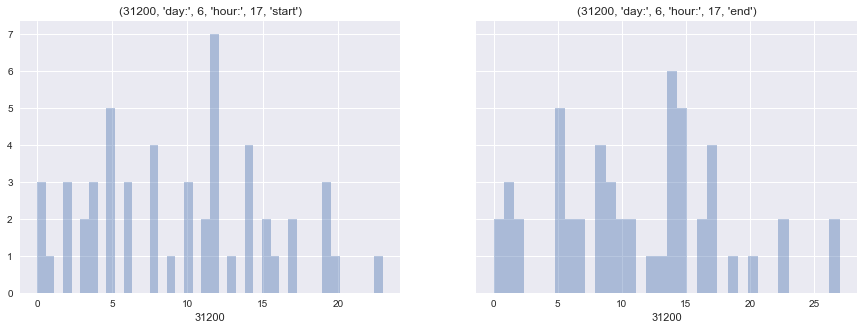

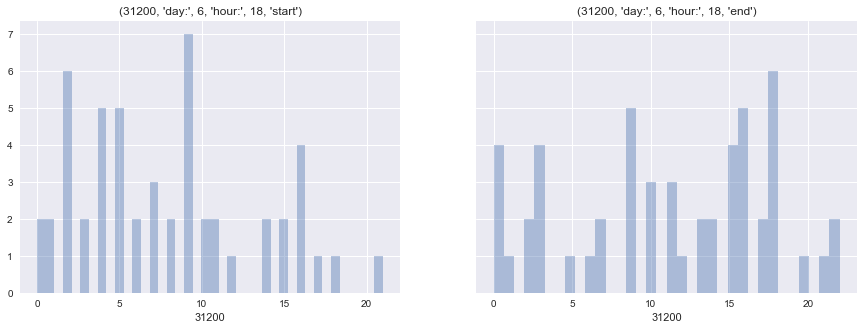

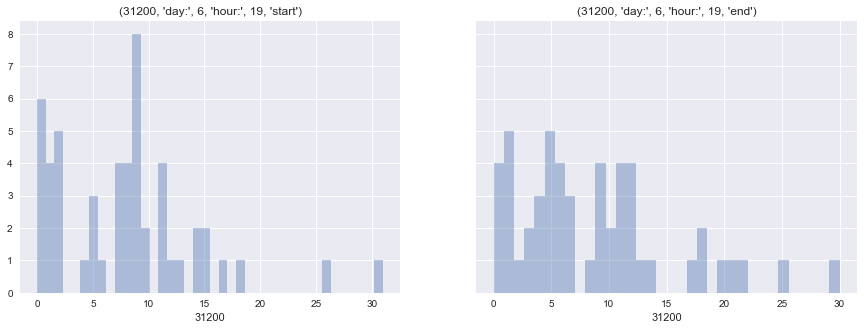

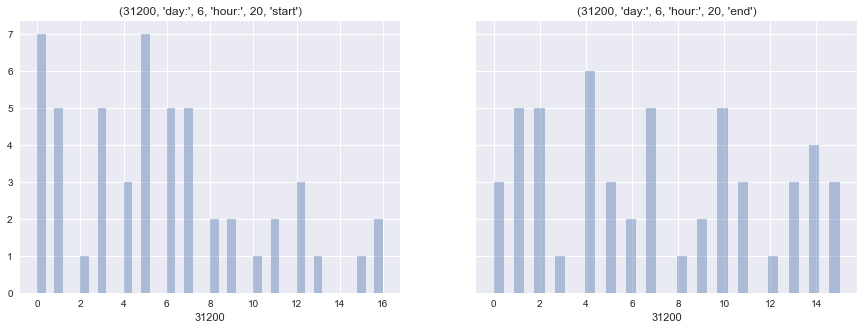

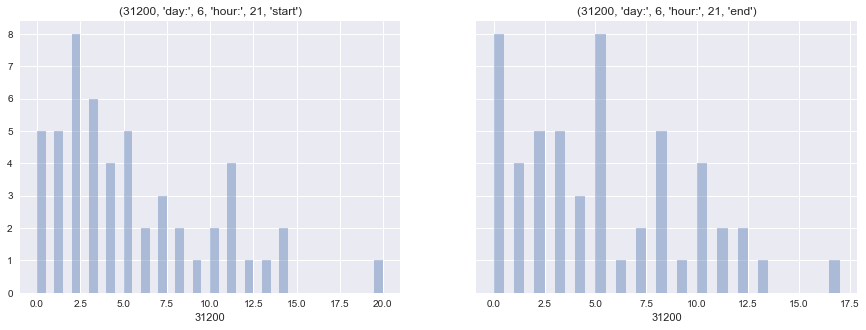

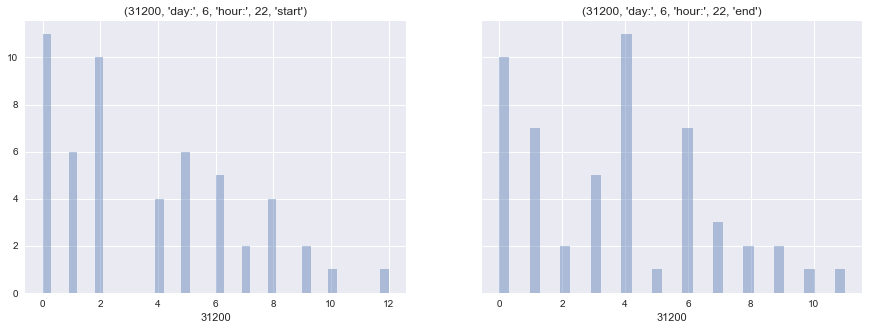

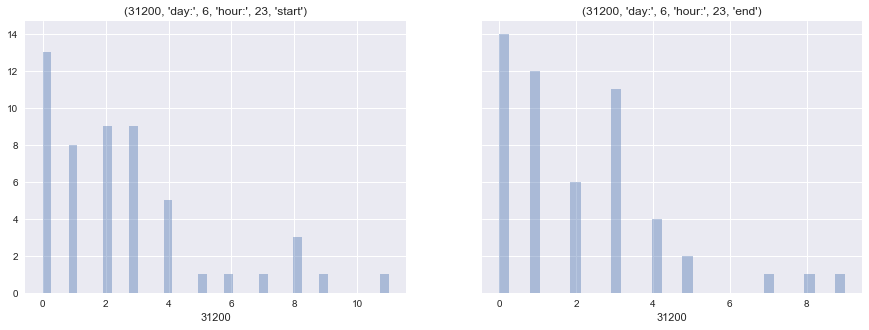

In [12]:
# histograms per site/day of week/hour of day

for site in sample_sites: 
    group_site_start_day = df_hourly_start[[site,'hourofday','dayofweek','weekofyear']].fillna(0).groupby('dayofweek')
    group_site_end_day = df_hourly_end[[site,'hourofday','dayofweek','weekofyear']].fillna(0).groupby('dayofweek')
    print(site)
    for idx,group in group_site_start_day:
        group_end = group_site_end_day.get_group(idx)
        
        df_start_site_day = group.pivot_table(values=site,index=['weekofyear','hourofday'],fill_value=0).reset_index()
        df_end_site_day = group_end.pivot_table(values=site,index=['weekofyear','hourofday'],fill_value=0).reset_index()

        for idx2,group2 in df_start_site_day.groupby(['hourofday']):
            group2_end = df_end_site_day.groupby(['hourofday']).get_group(idx2)
            f, (ax1,ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))
            bin_count_start = np.max(df_start_site_day[site]) - np.min(df_start_site_day[site]) + 1
            bin_count_end = np.max(df_end_site_day[site]) - np.min(df_end_site_day[site]) + 1
            
            sns.distplot(group2[site],bins=bin_count_start,kde=False,ax=ax1)
            ax1.set_title((site,'day:',idx,'hour:',idx2,'start'))
            sns.distplot(group2_end[site],bins=bin_count_end,kde=False,ax=ax2)
            ax2.set_title((site,'day:',idx,'hour:',idx2,'end'))

            plt.show()